<a href="https://colab.research.google.com/github/maksim267/RAG_attractions/blob/main/Copy_of_hf_rag.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

# Домашнее задание. RAG.

В этом домашнем задании вам предстоит создать туристический RAG, провести EDA и проявить креатив! :)

Вам дан набор данных, содержащий информацию о памятниках, архитектуре и других значимых местах. В данных есть:
* название достопримечательности;
* идентификатор на WikiData;
* город расположения;
* координаты долготы и широты;
* описание (извлеченное из WikiData);
* изображение в формате base64;
* сгенерированное описание изображения (генерация с помощью модели BLIP).

Некоторые из памятников могут встречаться несколько раз, но с различными изображениями, из которых не все могут быть качественными. Для компенсации этого даны текстовые описания.

Часть данных взята с Национальной технологической олимпиады студентов по CV. Базовое решение предполагает использование мультимодального ru-CLIP. Но в данном домашнем задании предлагается решить эту задачу творчески, используя NLP подход.

## Установка и импорт библиотек

In [ ]:
# !pip install -q gdown torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-cpu openpyxl datasets langchain-community ragatouille umap-learn

In [ ]:
# !pip install --upgrade --force-reinstall numpy==2.1.0 pandas==2.2.2 packaging==24.2



In [ ]:
# pip install "langchain<0.1.0"

In [ ]:
!pip install --upgrade --force-reinstall \
    numpy==2.1.0 \
    pandas==2.2.2 \
    packaging==24.2 \
    tqdm==4.66.4 \
    plotly==5.22.0 \
    matplotlib==3.8.4 \
    torch==2.3.1 \
    transformers==4.41.2 \
    sentence-transformers==2.7.0 \
    accelerate==0.31.0 \
    bitsandbytes==0.43.1 \
    langchain==0.2.6 \
    langchain-community==0.2.6 \
    faiss-cpu==1.8.0.post1 \
    ragatouille==0.4.4 \
    scikit-learn==1.5.0 \
    gdown==5.1.0


In [5]:
!pip install ragatouille


In [6]:
import gdown
import pandas as pd
from tqdm.notebook import tqdm
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt
from langchain_core.documents import Document as LangchainDocument
from sentence_transformers import SentenceTransformer
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy
import numpy as np
import plotly.express as px
from transformers import pipeline
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from ragatouille import RAGPretrainedModel
from sklearn.feature_extraction.text import TfidfVectorizer
#------------------------------------------------------------------------------------
# from langchain.text_splitter import ... # выберите другую стратегию разбивки на чанки

# pd.set_option("display.max_colwidth", None)

/tmp/ipython-input-2465835846.py:16: UserWarning: 
********************************************************************************
RAGatouille WARNING: Future Release Notice
--------------------------------------------
RAGatouille version 0.0.10 will be migrating to a PyLate backend 
instead of the current Stanford ColBERT backend.
PyLate is a fully mature, feature-equivalent backend, that greatly facilitates compatibility.
However, please pin version <0.0.10 if you require the Stanford ColBERT backend.
********************************************************************************
  from ragatouille import RAGPretrainedModel


## Загрузка данных (4 балла)

In [9]:
url = 'https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk'
output = 'file.csv'

gdown.download(url, output, quiet=False)

data = pd.read_csv('file.csv')

Downloading...
From (original): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk
From (redirected): https://drive.google.com/uc?id=1P1BsvI2jPN3fEqjc2YZxmQ-MTs22WVUk&confirm=t&uuid=ba4b8bf8-6832-40cc-abd1-201535125169
To: /content/file.csv

  0%|          | 0.00/672M [00:00<?, ?B/s]
  0%|          | 1.05M/672M [00:00<01:07, 9.95MB/s]
  1%|          | 4.19M/672M [00:00<00:31, 21.5MB/s]
  1%|          | 7.34M/672M [00:00<00:25, 25.6MB/s]
  2%|▏         | 15.2M/672M [00:00<00:14, 45.1MB/s]
  4%|▎         | 23.6M/672M [00:00<00:11, 58.4MB/s]
  6%|▌         | 37.7M/672M [00:00<00:07, 84.7MB/s]
  7%|▋         | 48.8M/672M [00:00<00:06, 92.5MB/s]
  9%|▊         | 58.2M/672M [00:00<00:06, 89.0MB/s]
 10%|█         | 67.6M/672M [00:00<00:06, 90.6MB/s]
 12%|█▏        | 77.6M/672M [00:01<00:06, 92.8MB/s]
 13%|█▎        | 87.0M/672M [00:01<00:06, 86.9MB/s]
 14%|█▍        | 95.9M/672M [00:01<00:08, 68.6MB/s]
 17%|█▋        | 116M/672M [00:01<00:05, 99.5MB/s] 
 19%|█▉        | 127M/672

In [10]:
data.head()

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there are two people that are standing on a tr...
1,1,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a blue and white exterior...
2,2,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
3,3,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a blue and white building with a cloc...
4,4,Динамо,Q37996725,Екатеринбург,60.600349,56.845398,спорткомплекс в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a boat that is in the water near a bu...


Для декодирования изображений, закодированных в формате base64, можно использовать следующий код:

In [11]:
import base64
import requests
import matplotlib.pyplot as plt
from PIL import Image
import PIL
from io import BytesIO

In [12]:
def get_image(data):
  image = Image.open(BytesIO(base64.b64decode(data))).convert('RGB')
  return image

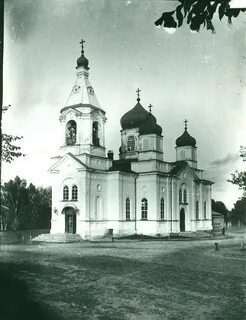

In [13]:
get_image(data.sample(1)['image'].tolist()[0])

В данных есть выбросы — записи, не относящихся к туристическим или историческим объектам. Для очистки данных можно, например, использовать алгоритм TF-IDF: создаем корпус текстов из описаний, применяем TF-IDF, извлекаем наиболее редко или часто встречающиеся слова. Они могут указывать на мусорные данные, такие как мемы, баннеры или личные фото людей. После выделения подозрительных паттернов, можно провести ручную проверку и фильтрацию данных.

Для дальнейшего тестирования и получения чистых сэмплов, рекомендуется взять не менее 100 чистых образцов со стратификацией по городу и названию места. Это можно сделать, выбрав случайным образом несколько образцов из каждой категории (город + название места), чтобы обеспечить равномерное представительство и разнообразие данных.

**!! Важно:** Помните, что чистые сэмплы одного и того же места выдадут примерно одинаковое описание. Есть несколько стратегий, как повысить разнообразие ответов:

- выбор одного самого лучшего:
  - самое длинное описание
  - смое подходящие по мнению LLM
- конкатенация описаний (но важно не сконкатенировать слишком много)

Изображения можно отдать в мета-данные.

In [14]:
corpus = [i for i in data.en_txt]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

words = vectorizer.get_feature_names_out()
mean_tfidf = np.mean(X.toarray(), axis=0)
sorted_indices = np.argsort(mean_tfidf)

print("Часто встречающиеся слова (низкий TF-IDF):")
for idx in sorted_indices[:10]:
  print(words[idx], mean_tfidf[idx])

print("\nРедкие и значимые слова (высокий TF-IDF):")
for idx in sorted_indices[-3:]:
  print(words[idx], mean_tfidf[idx])

Часто встречающиеся слова (низкий TF-IDF):
hams 1.9335221228389175e-05
hoo 1.9335221228389175e-05
chariot 2.1482540732519262e-05
ax 2.1517448092046853e-05
royalty 2.1517448092046853e-05
pouring 2.4160542047303204e-05
blender 2.4160542047303204e-05
bottroonirchich 2.598675544669857e-05
method 2.598675544669857e-05
male 2.645181494631367e-05

Редкие и значимые слова (высокий TF-IDF):
building 0.08166802929596924
with 0.09291067277866477
of 0.10483544416862739


In [15]:
sentens_with_rar_word=[]
strange_words=['royalty','blender','bottroonirchich','method']
for sen in corpus:
  for word in strange_words:
    if word in sen:
      sentens_with_rar_word.append(sen)


In [16]:
sentens_with_rar_word

["yellow building with a sign that says bottroonirchich mark mark's method",
 "yellow building with a sign that says bottroonirchich mark mark's method",
 'woman in black dress pouring coffee into a blender in a coffee shop',
 'a beaver with an ax in his hand and a big axe in his hand royalty illustration']

In [17]:
ind_bad_samples=data.loc[data.en_txt.isin(sentens_with_rar_word)].index

In [18]:
data=data.drop(ind_bad_samples,axis=0)

In [19]:
corpus = [i for i in data.Name]

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(corpus)

words = vectorizer.get_feature_names_out()
mean_tfidf = np.mean(X.toarray(), axis=0)
sorted_indices = np.argsort(mean_tfidf)

print("Часто встречающиеся слова (низкий TF-IDF):")
for idx in sorted_indices[:10]:
  print(words[idx], mean_tfidf[idx])

print("\nРедкие и значимые слова (высокий TF-IDF):")
for idx in sorted_indices[-10:]:
  print(words[idx], mean_tfidf[idx])

Часто встречающиеся слова (низкий TF-IDF):
первой 0.0007069474366771612
пансиона 0.0007069474366771612
магдалины 0.0007069474366771612
святой 0.0007069474366771612
женской 0.0007069474366771612
католической 0.0007289943810780971
костел 0.0007289943810780971
марии 0.0007289943810780971
римско 0.0007289943810780971
девы 0.0007289943810780971

Редкие и значимые слова (высокий TF-IDF):
усадьба 0.011711934078000924
на 0.012638393611830239
театр 0.012925609413828698
монастырь 0.013399762144282137
собор 0.01780335558146583
храм 0.01865633754418668
башня 0.027007449461828953
музей 0.027765741906130178
дом 0.03871906422298334
церковь 0.04031418546606216


In [20]:
data=data.loc[~data.description.isna()]

In [21]:
# short_data = data.groupby("Name").apply(lambda x: x ==max([len(i) for i in x.en_txt])).reset_index()
idx = data.groupby("Name")["description"].apply(lambda x: x.str.len().idxmax())

short_data = data.loc[idx].reset_index(drop=True)

In [22]:
short_data

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt
0,0,Cerkiew Narodzenia Pańskiego w Jarosławiu,Q28058985,Ярославль,39.894360,57.630562,Православный храм в Ярославле,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed building with a green roof and a green ...
1,29,Cerkiew Włodzimierskiej Ikony Matki Bożej w Ja...,Q30913943,Ярославль,39.906563,57.611237,Архитектурный ансамбль в Ярославле,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed brick building with green roof and gree...
2,88,Cerkiew św. Dymitra Sołuńskiego w Jarosławiu,Q28056804,Ярославль,39.881390,57.621670,Церковь великомученика Димитрия Солунского (См...,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,snowy landscape of a church with a green dome ...
3,981,église arménienne de Vladimir,Q18331756,Владимир,40.456497,56.154667,Армянская церковь в г. Владимир России,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed view of a church with a steeple and a s...
4,57,Авиамеханический колледж,Q18786015,Владимир,40.387318,56.126278,Владимирский авиамеханический колледж,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,arafed brick building with a clock tower and a...
...,...,...,...,...,...,...,...,...,...
312,123,№27 Дом Г.Н. Скрябина,Q55232375,Екатеринбург,60.607075,56.834225,Дом Е.Д. Скрябиной,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,cars parked in front of a building with a cloc...
313,97,№28 Здание городской электростанции «Луч»,Q55154121,Екатеринбург,60.607430,56.833691,здание и достопримечательность в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a bridge that is going over a river w...
314,2219,№29 Дом В.И. Чувильдина,Q27921892,Екатеринбург,60.607689,56.832268,Дом купца Чувильдина,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a large building with a clock on top ...
315,41,№32 Дом обороны,Q55209768,Екатеринбург,60.601315,56.834167,здание в Екатеринбурге,/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAUEBAUEAwUFBA...,there is a large building with a helicopter on...


In [23]:
short_data['text']=short_data['Name']+', который описывают как '+short_data['description']+' расположенным в '+short_data['City']+' который выглядит как'+ short_data['en_txt']

In [24]:
short_data.loc[short_data.text=='Дом Е.Д. Скрябиной расположенным в Екатеринбург который описывают: there is a man standing outside of a building with a tree in front of it']

,Unnamed: 0,Name,WikiData,City,Lon,Lat,description,image,en_txt,text


In [25]:
max([len(i) for i in short_data.text])

388

In [26]:
RAW_KNOWLEDGE_BASE = [
    LangchainDocument(
        page_content=doc["text"],
        metadata={"image": doc["image"],
                  'WikiData':doc['WikiData'],
                  'Lon&Lat':str(doc['Lon'])+' '+str(doc['Lat'])
                  }
    ) for _, doc in tqdm(short_data.iterrows())
]

0it [00:00, ?it/s]

Здесь предлагаем вам построить RAG с использованием моделей, которые не были представлены на семинаре (включая другие векторные базы данных). Можно воспользоваться материалами по этой ссылке: [data_connection/vectorstores](https://python.langchain.com/v0.1/docs/modules/data_connection/vectorstores/).

!Важно, не забудьте отранжировать чанки текстов с помощью `ragatouille`. На практике порядок текстов в промпте влияет на точность ответа.

In [27]:
# pip install -U langchain

In [28]:
# embedding_model = HuggingFaceEmbeddings(
#     model_name=EMBEDDING_MODEL_NAME,
#     multi_process=True,
#     model_kwargs={"device": "cuda"},
#     encode_kwargs={"normalize_embeddings": True},  # `True` для косинусного сходства
# )

# KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
#     docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
# )

In [29]:
!pip install chromadb

Exception ignored in: <function tqdm.__del__ at 0x7f0861831c60>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1277, in close
    if self.last_print_t < self.start_t + self.delay:
       ^^^^^^^^^^^^^^^^^
AttributeError: 'tqdm' object has no attribute 'last_print_t'


In [30]:
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langchain_community.embeddings import HuggingFaceEmbeddings
from ragatouille import RAGPretrainedModel

query='достопримечательность в Екатеринбурге'
# 1. Эмбеддинги
embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

vecstore = Chroma.from_documents(RAW_KNOWLEDGE_BASE, embeddings)

# 3. Получаем кандидатов
retriever = vecstore.as_retriever(search_kwargs={"k": 10})
candidates = retriever.get_relevant_documents(query)

# 4. Ранжируем через RAGatouille
rag = RAGPretrainedModel.from_pretrained("colbert-ir/colbertv2.0")
# texts = list(set([doc.page_content for doc in candidates]))
rag.index([doc.page_content for doc in candidates], index_name="my_index")
reranked = rag.search(query, k=5)

# 5. Передаём топ‑5 чанков в LLM
for rank, res in enumerate(reranked, 1):
    print(f"{rank}. {res['content']} (score={res['score']:.4f})")


/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()


---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:24:04] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:24:04] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:24:27] [0] 		 #> Encoding 10 passages..


/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


[Nov 16, 18:24:27] [0] 		 avg_doclen_est = 114.5 	 len(local_sample) = 10
[Nov 16, 18:24:27] [0] 		 Creating 512 partitions.
[Nov 16, 18:24:27] [0] 		 *Estimated* 1,145 embeddings.
[Nov 16, 18:24:27] [0] 		 #> Saving the indexing plan to .ragatouille/colbert/indexes/my_index/plan.json ..
used 5 iterations (0.1397s) to cluster 1088 items into 512 clusters
[Nov 16, 18:24:27] Loading decompress_residuals_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


W1116 18:24:27.780000 8931 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1116 18:24:27.780000 8931 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


[Nov 16, 18:24:27] Loading packbits_cpp extension (set COLBERT_LOAD_TORCH_EXTENSION_VERBOSE=True for more info)...


W1116 18:24:27.868000 8931 torch/utils/cpp_extension.py:2425] TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
W1116 18:24:27.868000 8931 torch/utils/cpp_extension.py:2425] If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'] to specific architectures.


[0.024, 0.021, 0.019, 0.024, 0.024, 0.021, 0.023, 0.025, 0.016, 0.02, 0.026, 0.025, 0.026, 0.022, 0.02, 0.021, 0.022, 0.025, 0.022, 0.027, 0.021, 0.023, 0.025, 0.023, 0.022, 0.024, 0.028, 0.023, 0.021, 0.024, 0.025, 0.023, 0.024, 0.019, 0.02, 0.029, 0.023, 0.021, 0.025, 0.02, 0.019, 0.018, 0.023, 0.024, 0.016, 0.022, 0.022, 0.021, 0.023, 0.022, 0.025, 0.024, 0.017, 0.024, 0.027, 0.022, 0.025, 0.03, 0.024, 0.025, 0.018, 0.022, 0.021, 0.027, 0.024, 0.02, 0.023, 0.019, 0.019, 0.021, 0.021, 0.021, 0.024, 0.022, 0.017, 0.025, 0.023, 0.022, 0.021, 0.02, 0.029, 0.017, 0.023, 0.024, 0.021, 0.022, 0.023, 0.023, 0.024, 0.025, 0.025, 0.026, 0.024, 0.027, 0.028, 0.022, 0.025, 0.023, 0.018, 0.031, 0.023, 0.025, 0.021, 0.017, 0.023, 0.023, 0.021, 0.021, 0.026, 0.023, 0.025, 0.02, 0.026, 0.026, 0.027, 0.02, 0.025, 0.02, 0.026, 0.023, 0.019, 0.023, 0.024, 0.022, 0.027, 0.027, 0.024, 0.024]


0it [00:00, ?it/s]

[Nov 16, 18:24:28] [0] 		 #> Encoding 10 passages..


/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()
1it [00:00,  6.91it/s]
100%|██████████| 1/1 [00:00<00:00, 373.03it/s]

[Nov 16, 18:24:28] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:24:28] #> Building the emb2pid mapping..
[Nov 16, 18:24:28] len(emb2pid) = 1145



100%|██████████| 512/512 [00:00<00:00, 14968.49it/s]

[Nov 16, 18:24:28] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:24:30] #> Loading codec...
[Nov 16, 18:24:31] #> Loading IVF...
[Nov 16, 18:24:31] #> Loading doclens...


/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
100%|██████████| 1/1 [00:00<00:00, 5599.87it/s]

[Nov 16, 18:24:31] #> Loading codes and residuals...



100%|██████████| 1/1 [00:00<00:00, 726.54it/s]


Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: достопримечательность в Екатеринбурге, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  1184, 14150, 29747, 22919, 14150, 29746, 16856, 10325,
        29745, 15290, 29752, 10260, 22919, 15290, 29436, 23742, 18947, 14150,
        29747, 22919, 23742,  1182,  1185, 28598, 22919, 15290, 16856, 10325,
        18947,   102], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1], device='cuda:0')

1. Дом связи (Екатеринбург), который описывают как здание в Екатеринбурге расположенным в Екатеринбург который выглядит какarafed building with a blue sign on the front of it (score=27.0000)
2. Дом Промышленности, который описывают как здание в Екатеринбурге расположенным в Екатеринбург который выглядит какarafed building with a lot of windows and a lot of cars (score

In [31]:
!pip install -U bitsandbytes>=0.41.0

In [33]:
READER_MODEL_NAME = "Qwen/Qwen2.5-3B-Instruct"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME,
    quantization_config=bnb_config,
    device_map="cuda"
)

tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)



Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda


Выполните визуализацию эмбеддингов при помощи метода главных компонент (PCA) и Uniform Manifold Approximation and Projection (UMAP). Пожалуйста, выполните PCA независимо от pacmap.

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


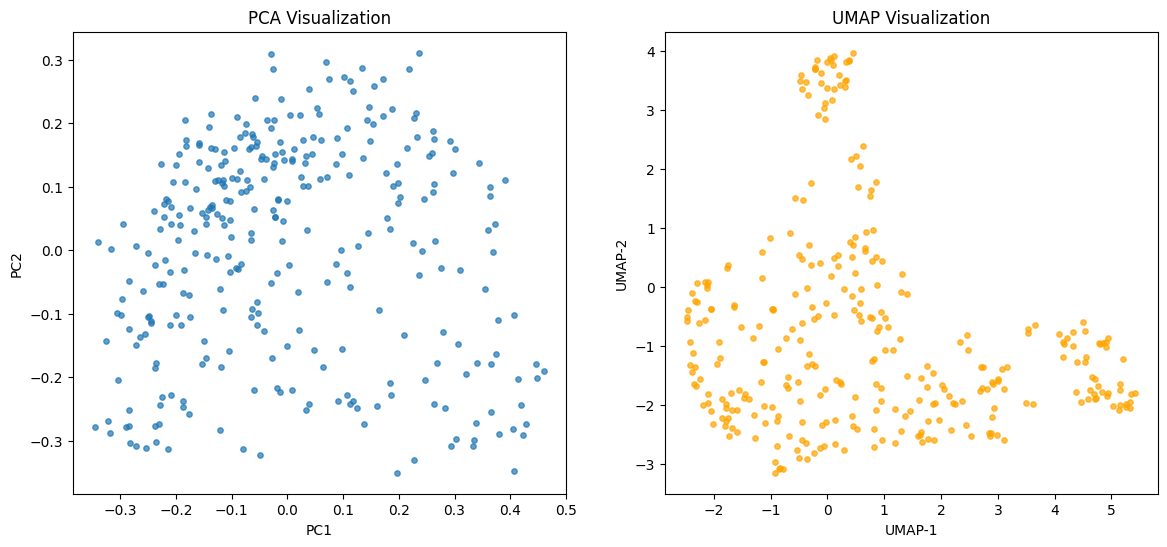

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap.umap_ as umap

emb_matrix = np.array([embeddings.embed_query(doc.page_content) for doc in RAW_KNOWLEDGE_BASE])

# ================
# 1. PCA (2 компоненты)
# ================
pca = PCA(n_components=2, random_state=42)
emb_pca = pca.fit_transform(emb_matrix)

# ================
# 2. UMAP (2 компоненты)
# ================
umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    metric='cosine',
    random_state=42
)
emb_umap = umap_model.fit_transform(emb_matrix)

plt.figure(figsize=(14,6))

# PCA Plot
plt.subplot(1, 2, 1)
plt.scatter(emb_pca[:, 0], emb_pca[:, 1], s=15, alpha=0.7)
plt.title("PCA Visualization")
plt.xlabel("PC1")
plt.ylabel("PC2")

# UMAP Plot
plt.subplot(1, 2, 2)
plt.scatter(emb_umap[:, 0], emb_umap[:, 1], s=15, alpha=0.7, c='orange')
plt.title("UMAP Visualization")
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")

plt.show()


# RAGAS (3 балла)

RAGAS - это система, созданная для автоматической оценки эффективности модели RAG. Она представляет собой комплексный инструмент, способный оценить как качество извлечения информации, так и качество созданного текста. Это достигается благодаря использованию различных метрик, которые анализируют разные аспекты ответов, сгенерированных языковой моделью.



## Метрики оценки в RAGAS

### Faithfulness
Оценивает, насколько ответы языковой модели верно передают информацию, содержащуюся в источниках данных. Это критически важно, чтобы гарантировать, что модель не искажает или не меняет информацию при её интерпретации.

---

$
Faithfulness = \frac{\text{|Number of claims that can be inferred from given context|}}{\text{|Total number of claims in the generated answer|}}
$

### Answer Relevancy
Демонстрирует, насколько ответы соответствуют заданным вопросам. Это важный аспект, так как даже правильный ответ с технической точки зрения может быть ненужным, если он не отвечает на конкретный вопрос пользователя.

---

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} cos(E_{g_i}, E_o)$

$\text{answer relevancy} = \frac{1}{N} \sum_{i=1}^{N} \frac{E_{g_i} \cdot E_o}{\|E_{g_i}\|\|E_o\|}$

Где:

* $E_{g_i}$ - это эмбеддинг сгенерированного ответа $i$

* $E_o$ - это эмбеддинг исходного вопроса.

* $N$ - это количество сгенерированных вопросов, которое по умолчанию равно 3.

### Context Recall и Context Precision
Эти метрики измеряют эффективность модели в учете контекста вопроса для формирования ответа. "Context Recall" оценивает количество использованной информации из контекста в ответе, в то время как "Context Precision" оценивает точность и релевантность использования контекстной информации.

---

* $ \text{context recall} = \frac{\text{|GT sentences that can be attributed to context|}}{\text{|Number of sentences in GT|}} $
* $Context Precision@k = \frac{\sum \text{precision@k}}{\text{total number of relevant items in the top K results}}$
  * $Precision@k = \frac{\text {true positives@k}}{\text{(true positives@k + false positives@k)}}$

### Answer Semantic Similarity
Оценивает степень семантической близости между ответом модели и эталонным ответом. Это позволяет определить, насколько естественно и точно модель способна воссоздавать человеческий язык.

### Answer Correctness
Оценка корректности ответа. Это последний шаг в проверке, чтобы убедиться, предоставляет ли модель точную и достоверную информацию в своем ответе.

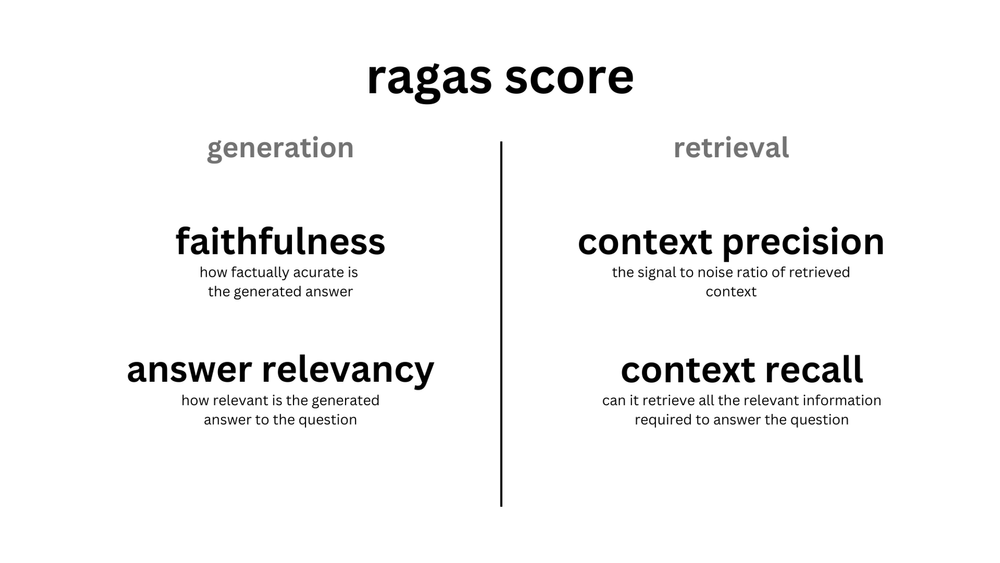

В этом задании вам нужно реализовать метрику answer_relevancy в коде. Опционально за допбаллы можно реализовать другие метрики.

Для этого датасет нужно привести к виду, в котором будут следующие поля:

### 1. question
- Смысл: Эта колонка содержит вопросы, на которые нужно найти ответы. В контексте задач QA, это основная информация, которую модель должна обработать для генерации ответа.
- Пример: "Каковы преимущества RAG?"

### 2. ground_truths
- Смысл: В этой колонке находятся правильные ответы на соответствующие вопросы. Это может использоваться для оценки производительности модели, так как позволяет сравнить сгенерированные ответы с эталонными.
- Пример: "RAG улучшает качество генерации, используя внешние источники информации."

### 3. answer
- Смысл: Эта колонка содержит ответы, которые генерирует модель на основе заданных вопросов. Это может быть результат работы модели, которую вы тестируете или обучаете.
- Пример: "RAG позволяет моделям извлекать информацию из внешних источников, что улучшает их способность отвечать на сложные вопросы."

### 4. contexts
- Смысл: Эта колонка предоставляет контекст или дополнительную информацию, которая может быть полезна для понимания вопроса или для формирования ответа. Это может быть текст, из которого был извлечен ответ, или другие релевантные документы.
- Пример: "RAG (Retrieval-Augmented Generation) — это метод, который использует внешние базы данных для получения информации при генерации текста."

HINT: Поле question можно тоже сгенерировать. Например, можно попросить модель задать вопрос по описанию изображения.

HINT: Для answer_relevancy нужны не все поля

HINT: Инференс такого эксперимента может быть долгим. План минимум: возьмите 100 случайных сэмплов.

In [48]:
def answer_relevancy(question,embeddings,answer,N=3):
  vec_question = embeddings.embed_documents(question)
  vec_ansver = embeddings.embed_documents(answer)
  cos_sim = np.sum(np.array(vec_question) * np.array(vec_ansver), axis=1) / (
    np.linalg.norm(vec_question, axis=1) * np.linalg.norm(vec_ansver, axis=1)
)
  return np.sum(cos_sim/N)

In [36]:
(data['Name']+', который описывают как '+data['description']+' расположенным в '+data['City']+' который выглядит как'+ data['en_txt']).to_csv('data_for_question_rag5.csv')
# для генерации вопросов и ответов я использовал deepseek

###Сгенерированные DeepSeek вопросы и ответы

In [37]:
questions = [
    "What is Dinamo?",
    "Where is Dinamo?",
    "What is Dom Oborony?",
    "What is on Dom Oborony's roof?",
    "What is the 'Luch' Power Station?",
    "Where is the 'Luch' Power Station?",
    "What is the Skryabin House?",
    "Where is the Skryabin House?",
    "What is 'Literary Life of the Urals'?",
    "Where is 'Literary Life of the Urals'?",
    "What is the Bazhov House?",
    "Where is the Bazhov House?",
    "What is the Puppet Theater?",
    "Where is the Puppet Theater?",
    "What is Kharitonovsky Park?",
    "Where is Kharitonovsky Park?",
    "What is the Church of the Ascension?",
    "Where is the Church of the Ascension?",
    "What is the Suvorov School?",
    "Where is the Suvorov School?",
    "What is the Holy Trinity Cathedral?",
    "Where is the Holy Trinity Cathedral?",
    "What is the Mamin-Sibiryak House?",
    "Where is the Mamin-Sibiryak House?",
    "What is the Ernst Neizvestny Museum?",
    "Where is the Ernst Neizvestny Museum?",
    "What is the Ordzhonikidze Monument?",
    "Where is the Ordzhonikidze Monument?",
    "What is the Kuznetsov Monument?",
    "Where is the Kuznetsov Monument?",
    "What is the Uspensky Cathedral?",
    "Where is the Uspensky Cathedral?",
    "What is the Tsarsky Bridge?",
    "Where is the Tsarsky Bridge?",
    "What is Dom Pechati?",
    "Where is Dom Pechati?",
    "What is the Museum of Fine Arts?",
    "Where is the Museum of Fine Arts?",
    "What is the Alexander Nevsky Cathedral?",
    "Where is the Alexander Nevsky Cathedral?",
    "What is the Madrid Hotel?",
    "Where is the Madrid Hotel?",
    "What is the Yekaterinburg Museum of Fine Arts?",
    "Where is the Yekaterinburg Museum of Fine Arts?",
    "What is the Medical University?",
    "Where is the Medical University?",
    "What is the Central Stadium?",
    "Where is the Central Stadium?",
    "What is the Conservatory?",
    "Where is the Conservatory?",
    "What is the Metenkov Photo Museum?",
    "Where is the Metenkov Photo Museum?",
    "What is the Preobrazhenskaya Church?",
    "Where is the Preobrazhenskaya Church?",
    "What is the Geological Museum?",
    "Where is the Geological Museum?",
    "What is Dom Metenkova?",
    "Where is Dom Metenkova?",
    "What is Gymnasium No. 9?",
    "Where is Gymnasium No. 9?",
    "What is the Second House of Soviets?",
    "Where is the Second House of Soviets?",
    "What is the Water Tower?",
    "Where is the Water Tower?",
    "What type of place is Dinamo?",
    "What city is Dinamo in?",
    "What color is Dinamo?",
    "What is on Dom Oborony?",
    "What type of building is Dom Oborony?",
    "What city is Dom Oborony in?",
    "What type of place is 'Luch'?",
    "What material is 'Luch' made of?",
    "What feature does Skryabin House have?",
    "What material is Skryabin House?",
    "What type of place is 'Literary Life of the Urals'?",
    "What type of building houses it?",
    "What type of house is Bazhov House?",
    "What color is its roof?",
    "What feature does Puppet Theater have?",
    "What type of place is Puppet Theater?",
    "What is in Kharitonovsky Park?",
    "What city is the park in?",
    "What color is Church of the Ascension?",
    "What feature does it have?",
    "What type of school is Suvorov?",
    "What is in front of it?",
    "What color is Holy Trinity Cathedral?",
    "What color are its domes?",
    "What color is Mamin-Sibiryak House?",
    "What color is its roof?",
    "What does Neizvestny Museum display?",
    "What type of museum is it?",
    "Where is Ordzhonikidze Monument located?",
    "What type of monument is it?",
    "Where is Kuznetsov Monument located?",
    "What is he holding?",
    "What color are Uspensky Cathedral's domes?",
    "Where is it located?",
    "What river does Tsarsky Bridge cross?",
    "What is on the bridge?",
    "What size is Dom Pechati?",
    "What feature does it have?",
    "What color is Fine Arts Museum's roof?",
    "Where is it located?",
    "What color is Alexander Nevsky Cathedral?",
    "What color are its domes?",
    "What feature does Madrid Hotel have?",
    "What type of place is it?",
    "What does Yekaterinburg Fine Arts Museum display?",
    "What type of place is it?",
    "What feature does Medical University have?",
    "What feature is on the building?",
    "What sport is Central Stadium for?",
    "What color is its roof?",
    "What type of school is Conservatory?",
    "What type of hall does it have?",
    "What color is Metenkov Museum?",
    "What type of museum is it?",
    "What color is Preobrazhenskaya Church?",
    "What color is its roof?",
    "What does Geological Museum display?",
    "What size are the rocks?",
    "What type of place is Dom Metenkova?",
    "What color is the building?",
    "What type of place is Gymnasium No. 9?",
    "What feature does it have?",
    "What size is Second House of Soviets?",
    "What feature does it have?",
    "How tall is Water Tower?",
    "What feature does it have?"
]

answers = [
    "A sports complex",
    "In Yekaterinburg",
    "A building",
    "A plane",
    "A power station",
    "In Yekaterinburg",
    "A house",
    "In Yekaterinburg",
    "A museum",
    "In Yekaterinburg",
    "A house-museum",
    "In Yekaterinburg",
    "A theater",
    "In Yekaterinburg",
    "A park",
    "In Yekaterinburg",
    "A church",
    "In Yekaterinburg",
    "A military school",
    "In Yekaterinburg",
    "A cathedral",
    "In Yekaterinburg",
    "A house-museum",
    "In Yekaterinburg",
    "An art museum",
    "In Yekaterinburg",
    "A monument",
    "In Yekaterinburg",
    "A monument",
    "In Yekaterinburg",
    "A cathedral",
    "On VIZ, Yekaterinburg",
    "A bridge",
    "Over the Iset River, Yekaterinburg",
    "A building",
    "In Yekaterinburg",
    "A museum",
    "In Yekaterinburg",
    "A cathedral",
    "In Yekaterinburg",
    "A hotel",
    "In Yekaterinburg",
    "A museum",
    "In Yekaterinburg",
    "A university",
    "In Yekaterinburg",
    "A stadium",
    "In Yekaterinburg",
    "A music school",
    "In Yekaterinburg",
    "A photo museum",
    "In Yekaterinburg",
    "A church",
    "On Uktus, Yekaterinburg",
    "A museum",
    "In Yekaterinburg",
    "A museum",
    "In Yekaterinburg",
    "A school",
    "In Yekaterinburg",
    "A building",
    "In Yekaterinburg",
    "A tower",
    "In Yekaterinburg",
    "Sports complex",
    "Yekaterinburg",
    "Blue and white",
    "A plane",
    "A building",
    "Yekaterinburg",
    "Power station",
    "Red brick",
    "A clock",
    "Red brick",
    "Museum",
    "Wooden house",
    "Log cabin",
    "Green",
    "Clock tower",
    "Theater",
    "A pond",
    "Yekaterinburg",
    "Blue and white",
    "Clock tower",
    "Military",
    "Statues",
    "Yellow",
    "Golden",
    "Red",
    "Green",
    "Sculptures",
    "Art museum",
    "In a park",
    "A statue",
    "In a park",
    "A flag",
    "Blue",
    "On VIZ",
    "Iset River",
    "Graffiti",
    "Large",
    "A clock",
    "Green",
    "Near a river",
    "White",
    "Gold",
    "Clock tower",
    "Hotel",
    "Paintings",
    "Museum",
    "Columns",
    "A clock",
    "Soccer",
    "Colored",
    "Music",
    "Concert hall",
    "Yellow",
    "Photo museum",
    "White",
    "Green",
    "Rocks",
    "Large",
    "Museum",
    "Yellow",
    "School",
    "A clock",
    "Large",
    "Clock tower",
    "Tall",
    "A clock"
]

In [38]:
row_numbers_used = [
    "0-40", "0-40", "41-96", "41,43,47,50-53,65,66,68,69,80,93", "97-123", "97-123",
    "123-150", "123-150", "151-177", "151-177", "178-207", "178-207", "207-246", "207-246",
    "247-277", "247-277", "278-334", "278-334", "335-367", "335-367", "368-397", "368-397",
    "398-426", "398-426", "427-453", "427-453", "454-510", "454-510", "511-540", "511-540",
    "541-568", "541-568", "569-608", "569-608", "609-638", "609-638", "639-666", "639-666",
    "667-693", "667-693", "694-722", "694-722", "723-750", "723-750", "751-779", "751-779",
    "779-818", "779-818", "819-849", "819-849", "850-908", "850-908", "909-964", "909-964",
    "965-1020", "965-1020", "1021-1050", "1021-1050", "1051-1078", "1051-1078", "1079-1108",
    "1079-1108", "1109-1135", "1109-1135", "0-40", "0-40", "1,2,3,8,9,10,15,22,28,30",
    "41,43,47,50-53,65,66,68,69,80,93", "41-96", "41-96", "97-123", "97-123", "123-150",
    "123-150", "151-177", "151-177", "178-207", "178-207", "207-246", "207-246", "247-277",
    "247-277", "278-334", "278-334", "335-367", "335-367", "368-397", "368-397", "398-426",
    "398-426", "427-453", "427-453", "454-510", "454-510", "511-540", "511-540", "541-568",
    "541-568", "569-608", "569-608", "609-638", "609-638", "639-666", "639-666", "667-693",
    "667-693", "694-722", "694-722", "723-750", "723-750", "751-779", "751-779", "779-818",
    "779-818", "819-849", "819-849", "850-908", "850-908", "909-964", "909-964", "965-1020",
    "965-1020", "1021-1050", "1021-1050", "1051-1078", "1051-1078", "1079-1108", "1079-1108",
    "1109-1135", "1109-1135"
]

###Продолжение

In [39]:
def gen_LLM_answers(questions_list:list,LLm,retriever,rag):
  answers=[]
  for question in tqdm(questions_list):
    candidates = retriever.get_relevant_documents(question)
    rag.index([doc.page_content for doc in candidates], index_name="my_index")
    rest = rag.search(question, k=5)
    prompt_in_chat_format = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
    give a comprehensive answer to the question.
    Respond only to the question asked, response should be concise and relevant to the question.
    Provide the number of the source document when relevant.
    If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
    {context}
    ---
    Now here is the question you need to answer.

    Question: {question}""",
    },
    ]
    RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
      prompt_in_chat_format, tokenize=False, add_generation_prompt=True
    )
    context = "\nExtracted documents:\n"
    context += "".join([
    f"Document {i}:::\n{res['content']}\n"
    for i, res in enumerate(rest)
    ])

    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    answer = READER_LLM(final_prompt)[0]["generated_text"]
    answers.append(answer)

  return answers

# Протестируйте ваш RAG (3 балла)

In [40]:
answers_LLM=gen_LLM_answers(questions,READER_LLM,retriever,rag)

  0%|          | 0/130 [00:00<?, ?it/s]

New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:47:38] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:47:38] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:48:01] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:48:01] [0] 		 avg_doclen_est = 125.9000015258789 	 len(local_sample) = 10
[Nov 16, 18:48:01] [0] 		 Creating 512 partitions.
[Nov 16, 18:48:01] [0] 		 *Estimated* 1,259 embeddings.
[Nov 16, 18:48:01]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0113s) to cluster 1197 items into 512 clusters
[0.023, 0.022, 0.023, 0.02, 0.021, 0.018, 0.019, 0.021, 0.018, 0.021, 0.023, 0.023, 0.023, 0.021, 0.022, 0.018, 0.018, 0.02, 0.02, 0.02, 0.017, 0.019, 0.021, 0.017, 0.019, 0.019, 0.021, 0.023, 0.026, 0.019, 0.022, 0.022, 0.025, 0.022, 0.023, 0.019, 0.028, 0.02, 0.022, 0.018, 0.02, 0.022, 0.02, 0.022, 0.024, 0.023, 0.021, 0.027, 0.021, 0.024, 0.017, 0.025, 0.021, 0.022, 0.021, 0.024, 0.021, 0.032, 0.022, 0.022, 0.021, 0.027, 0.02, 0.024, 0.017, 0.02, 0.025, 0.025, 0.02, 0.019, 0.021, 0.019, 0.021, 0.021, 0.02, 0.025, 0.02, 0.017, 0.021, 0.018, 0.025, 0.021, 0.02, 0.024, 0.019, 0.022, 0.023, 0.021, 0.021, 0.022, 0.017, 0.019, 0.027, 0.019, 0.027, 0.018, 0.02, 0.022, 0.02, 0.017, 0.026, 0.016, 0.019, 0.018, 0.02, 0.019, 0.022, 0.023, 0.025, 0.022, 0.023, 0.019, 0.015, 0.022, 0.025, 0.02, 0.02, 0.024, 0.028, 0.022, 0.019, 0.018, 0.02, 0.019, 0.025, 0.023, 0.02, 0.018]



0it [00:00, ?it/s]

[Nov 16, 18:48:01] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.50it/s]

100%|██████████| 1/1 [00:00<00:00, 557.98it/s]

[Nov 16, 18:48:01] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:48:01] #> Building the emb2pid mapping..
[Nov 16, 18:48:01] len(emb2pid) = 1259




100%|██████████| 512/512 [00:00<00:00, 45366.82it/s]

[Nov 16, 18:48:01] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:48:03] #> Loading codec...
[Nov 16, 18:48:03] #> Loading IVF...
[Nov 16, 18:48:03] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 4934.48it/s]

[Nov 16, 18:48:03] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 483.21it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is Dinamo?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003, 22306,  1029,   102,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:48:08] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:48:08] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:48:30] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:48:30] [0] 		 avg_doclen_est = 127.9000015258789 	 len(local_sample) = 10
[Nov 16, 18:48:30] [0] 		 Creating 512 partitions.
[Nov 16, 18:48:30] [0] 		 *Estimated* 1,279 embeddings.
[Nov 16, 18:48:30]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0039s) to cluster 1216 items into 512 clusters
[0.024, 0.023, 0.025, 0.024, 0.019, 0.023, 0.021, 0.022, 0.019, 0.021, 0.021, 0.017, 0.02, 0.018, 0.023, 0.023, 0.017, 0.021, 0.019, 0.019, 0.02, 0.017, 0.02, 0.016, 0.022, 0.025, 0.024, 0.02, 0.023, 0.023, 0.017, 0.019, 0.029, 0.021, 0.025, 0.017, 0.024, 0.019, 0.025, 0.017, 0.019, 0.02, 0.019, 0.019, 0.017, 0.019, 0.02, 0.021, 0.021, 0.023, 0.023, 0.026, 0.025, 0.019, 0.018, 0.024, 0.021, 0.03, 0.023, 0.02, 0.018, 0.021, 0.021, 0.023, 0.018, 0.021, 0.019, 0.027, 0.018, 0.021, 0.021, 0.022, 0.02, 0.02, 0.019, 0.026, 0.024, 0.018, 0.022, 0.017, 0.024, 0.024, 0.02, 0.021, 0.021, 0.024, 0.022, 0.021, 0.019, 0.02, 0.018, 0.018, 0.03, 0.024, 0.021, 0.021, 0.02, 0.024, 0.024, 0.021, 0.022, 0.02, 0.018, 0.019, 0.024, 0.021, 0.022, 0.025, 0.022, 0.021, 0.022, 0.021, 0.021, 0.019, 0.021, 0.021, 0.017, 0.021, 0.022, 0.024, 0.021, 0.025, 0.021, 0.02, 0.026, 0.018, 0.021, 0.017]



0it [00:00, ?it/s]

[Nov 16, 18:48:30] [0] 		 #> Encoding 10 passages..


1it [00:00, 25.25it/s]

100%|██████████| 1/1 [00:00<00:00, 1402.31it/s]

[Nov 16, 18:48:30] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:48:30] #> Building the emb2pid mapping..
[Nov 16, 18:48:30] len(emb2pid) = 1279




100%|██████████| 512/512 [00:00<00:00, 48498.92it/s]

[Nov 16, 18:48:30] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:48:31] #> Loading codec...
[Nov 16, 18:48:31] #> Loading IVF...
[Nov 16, 18:48:31] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 2371.00it/s]

[Nov 16, 18:48:31] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 357.57it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is Dinamo?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003, 22306,  1029,   102,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:48:36] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:48:36] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:48:58] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:48:58] [0] 		 avg_doclen_est = 126.80000305175781 	 len(local_sample) = 10
[Nov 16, 18:48:58] [0] 		 Creating 512 partitions.
[Nov 16, 18:48:58] [0] 		 *Estimated* 1,268 embeddings.
[Nov 16, 18:48:58

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0042s) to cluster 1205 items into 512 clusters
[0.024, 0.02, 0.022, 0.02, 0.023, 0.019, 0.023, 0.022, 0.025, 0.025, 0.028, 0.025, 0.02, 0.023, 0.027, 0.025, 0.028, 0.028, 0.024, 0.023, 0.025, 0.023, 0.021, 0.016, 0.019, 0.023, 0.026, 0.022, 0.017, 0.021, 0.018, 0.026, 0.021, 0.02, 0.025, 0.019, 0.02, 0.021, 0.023, 0.021, 0.023, 0.022, 0.023, 0.023, 0.022, 0.023, 0.023, 0.03, 0.025, 0.023, 0.028, 0.026, 0.016, 0.02, 0.019, 0.024, 0.026, 0.022, 0.022, 0.019, 0.023, 0.017, 0.022, 0.02, 0.024, 0.022, 0.025, 0.019, 0.02, 0.021, 0.022, 0.023, 0.025, 0.019, 0.023, 0.024, 0.023, 0.024, 0.024, 0.021, 0.025, 0.025, 0.021, 0.025, 0.024, 0.022, 0.021, 0.02, 0.019, 0.021, 0.025, 0.022, 0.021, 0.029, 0.029, 0.028, 0.032, 0.019, 0.02, 0.022, 0.026, 0.016, 0.018, 0.02, 0.021, 0.026, 0.025, 0.022, 0.028, 0.017, 0.022, 0.02, 0.023, 0.019, 0.023, 0.02, 0.024, 0.018, 0.026, 0.022, 0.025, 0.018, 0.022, 0.023, 0.024, 0.025, 0.021, 0.018]



0it [00:00, ?it/s]

[Nov 16, 18:48:58] [0] 		 #> Encoding 10 passages..


1it [00:00, 25.06it/s]

100%|██████████| 1/1 [00:00<00:00, 763.57it/s]

[Nov 16, 18:48:58] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:48:58] #> Building the emb2pid mapping..
[Nov 16, 18:48:58] len(emb2pid) = 1268




100%|██████████| 512/512 [00:00<00:00, 54381.82it/s]

[Nov 16, 18:48:58] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:49:00] #> Loading codec...
[Nov 16, 18:49:00] #> Loading IVF...
[Nov 16, 18:49:00] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5966.29it/s]

[Nov 16, 18:49:00] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 404.82it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is Dom Oborony?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003, 14383, 27885, 14604,  4890,  1029,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:49:07] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:49:07] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:49:29] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:49:29] [0] 		 avg_doclen_est = 128.39999389648438 	 len(local_sample) = 10
[Nov 16, 18:49:29] [0] 		 Creating 512 partitions.
[Nov 16, 18:49:29] [0] 		 *Estimated* 1,283 embeddings.
[Nov 16, 18:49:29

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0033s) to cluster 1220 items into 512 clusters
[0.024, 0.022, 0.028, 0.029, 0.021, 0.024, 0.028, 0.02, 0.02, 0.024, 0.022, 0.026, 0.025, 0.025, 0.02, 0.024, 0.023, 0.027, 0.026, 0.026, 0.023, 0.024, 0.026, 0.021, 0.021, 0.024, 0.025, 0.029, 0.021, 0.024, 0.027, 0.024, 0.018, 0.021, 0.025, 0.019, 0.027, 0.022, 0.024, 0.024, 0.019, 0.026, 0.027, 0.024, 0.025, 0.021, 0.022, 0.026, 0.021, 0.026, 0.029, 0.02, 0.024, 0.02, 0.029, 0.03, 0.027, 0.029, 0.026, 0.027, 0.021, 0.022, 0.02, 0.035, 0.024, 0.021, 0.028, 0.026, 0.026, 0.023, 0.019, 0.022, 0.024, 0.025, 0.026, 0.027, 0.021, 0.024, 0.026, 0.024, 0.022, 0.023, 0.025, 0.022, 0.023, 0.023, 0.024, 0.023, 0.018, 0.021, 0.022, 0.027, 0.021, 0.023, 0.029, 0.027, 0.027, 0.022, 0.025, 0.027, 0.027, 0.024, 0.023, 0.024, 0.025, 0.019, 0.026, 0.02, 0.026, 0.022, 0.024, 0.025, 0.03, 0.021, 0.026, 0.024, 0.027, 0.023, 0.026, 0.02, 0.023, 0.021, 0.026, 0.023, 0.027, 0.024, 0.022, 0.015]



0it [00:00, ?it/s]

[Nov 16, 18:49:29] [0] 		 #> Encoding 10 passages..


1it [00:00, 24.06it/s]

100%|██████████| 1/1 [00:00<00:00, 1282.66it/s]

[Nov 16, 18:49:29] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:49:29] #> Building the emb2pid mapping..
[Nov 16, 18:49:29] len(emb2pid) = 1284




100%|██████████| 512/512 [00:00<00:00, 35080.43it/s]

[Nov 16, 18:49:29] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:49:30] #> Loading codec...
[Nov 16, 18:49:30] #> Loading IVF...
[Nov 16, 18:49:30] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 3189.58it/s]

[Nov 16, 18:49:30] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 663.66it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is on Dom Oborony's roof?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  2006, 14383, 27885, 14604,  4890,  1005,
         1055,  4412,  1029,   102,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:49:36] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:49:36] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:49:58] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:49:58] [0] 		 avg_doclen_est = 130.1999969482422 	 len(local_sample) = 10
[Nov 16, 18:49:58] [0] 		 Creating 512 partitions.
[Nov 16, 18:49:58] [0] 		 *Estimated* 1,301 embeddings.
[Nov 16, 18:49:58]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0126s) to cluster 1237 items into 512 clusters
[0.018, 0.02, 0.015, 0.017, 0.019, 0.021, 0.018, 0.019, 0.018, 0.018, 0.02, 0.023, 0.017, 0.018, 0.018, 0.02, 0.016, 0.016, 0.022, 0.022, 0.022, 0.02, 0.021, 0.017, 0.015, 0.021, 0.021, 0.019, 0.019, 0.022, 0.018, 0.021, 0.02, 0.019, 0.023, 0.018, 0.02, 0.016, 0.024, 0.019, 0.02, 0.027, 0.019, 0.019, 0.022, 0.019, 0.021, 0.018, 0.02, 0.017, 0.021, 0.022, 0.02, 0.018, 0.016, 0.02, 0.029, 0.025, 0.024, 0.024, 0.017, 0.017, 0.019, 0.025, 0.023, 0.019, 0.021, 0.023, 0.016, 0.017, 0.023, 0.02, 0.019, 0.018, 0.019, 0.022, 0.022, 0.018, 0.018, 0.02, 0.017, 0.022, 0.02, 0.021, 0.023, 0.018, 0.021, 0.023, 0.017, 0.02, 0.02, 0.022, 0.02, 0.019, 0.021, 0.017, 0.021, 0.019, 0.019, 0.019, 0.019, 0.014, 0.021, 0.019, 0.023, 0.02, 0.016, 0.023, 0.02, 0.016, 0.015, 0.025, 0.019, 0.019, 0.023, 0.017, 0.019, 0.018, 0.027, 0.019, 0.02, 0.017, 0.017, 0.02, 0.02, 0.02, 0.019, 0.019]



0it [00:00, ?it/s]

[Nov 16, 18:49:58] [0] 		 #> Encoding 10 passages..


1it [00:00, 10.17it/s]

100%|██████████| 1/1 [00:00<00:00, 679.13it/s]

[Nov 16, 18:49:58] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:49:58] #> Building the emb2pid mapping..
[Nov 16, 18:49:58] len(emb2pid) = 1302




100%|██████████| 512/512 [00:00<00:00, 14000.43it/s]

[Nov 16, 18:49:58] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:50:02] #> Loading codec...
[Nov 16, 18:50:02] #> Loading IVF...
[Nov 16, 18:50:02] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 3426.72it/s]

[Nov 16, 18:50:02] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 708.38it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the 'Luch' Power Station?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996,  1005, 12776,  2232,  1005,  2373,
         2276,  1029,   102,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:50:07] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:50:07] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:50:28] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:50:28] [0] 		 avg_doclen_est = 132.39999389648438 	 len(local_sample) = 10
[Nov 16, 18:50:28] [0] 		 Creating 512 partitions.
[Nov 16, 18:50:28] [0] 		 *Estimated* 1,323 embeddings.
[Nov 16, 18:50:28

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0035s) to cluster 1258 items into 512 clusters
[0.025, 0.018, 0.021, 0.019, 0.022, 0.022, 0.022, 0.021, 0.023, 0.022, 0.024, 0.022, 0.02, 0.022, 0.024, 0.021, 0.019, 0.018, 0.027, 0.022, 0.023, 0.024, 0.022, 0.02, 0.017, 0.022, 0.023, 0.026, 0.021, 0.025, 0.018, 0.02, 0.021, 0.019, 0.021, 0.023, 0.018, 0.021, 0.017, 0.021, 0.022, 0.02, 0.022, 0.019, 0.022, 0.024, 0.02, 0.023, 0.02, 0.02, 0.028, 0.022, 0.019, 0.017, 0.021, 0.022, 0.028, 0.024, 0.023, 0.02, 0.018, 0.024, 0.022, 0.019, 0.023, 0.022, 0.019, 0.025, 0.019, 0.025, 0.022, 0.022, 0.025, 0.023, 0.025, 0.021, 0.018, 0.02, 0.019, 0.02, 0.02, 0.025, 0.023, 0.022, 0.022, 0.023, 0.021, 0.024, 0.018, 0.024, 0.02, 0.02, 0.021, 0.027, 0.027, 0.02, 0.021, 0.017, 0.024, 0.026, 0.026, 0.02, 0.024, 0.018, 0.029, 0.021, 0.022, 0.021, 0.025, 0.023, 0.016, 0.027, 0.025, 0.02, 0.026, 0.014, 0.024, 0.028, 0.024, 0.024, 0.025, 0.02, 0.019, 0.021, 0.02, 0.024, 0.019, 0.018]



0it [00:00, ?it/s]

[Nov 16, 18:50:28] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.51it/s]

100%|██████████| 1/1 [00:00<00:00, 724.53it/s]

[Nov 16, 18:50:28] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:50:28] #> Building the emb2pid mapping..
[Nov 16, 18:50:28] len(emb2pid) = 1324




100%|██████████| 512/512 [00:00<00:00, 42194.39it/s]

[Nov 16, 18:50:28] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:50:30] #> Loading codec...
[Nov 16, 18:50:30] #> Loading IVF...
[Nov 16, 18:50:30] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6584.46it/s]

[Nov 16, 18:50:30] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 448.68it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the 'Luch' Power Station?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996,  1005, 12776,  2232,  1005,  2373,
         2276,  1029,   102,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:50:36] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:50:36] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:50:58] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:50:58] [0] 		 avg_doclen_est = 136.1999969482422 	 len(local_sample) = 10
[Nov 16, 18:50:58] [0] 		 Creating 512 partitions.
[Nov 16, 18:50:58] [0] 		 *Estimated* 1,361 embeddings.
[Nov 16, 18:50:58]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0045s) to cluster 1294 items into 512 clusters
[0.026, 0.02, 0.02, 0.02, 0.019, 0.019, 0.018, 0.018, 0.02, 0.022, 0.02, 0.022, 0.02, 0.02, 0.021, 0.021, 0.02, 0.018, 0.024, 0.018, 0.016, 0.017, 0.023, 0.02, 0.019, 0.025, 0.02, 0.022, 0.021, 0.022, 0.024, 0.022, 0.023, 0.018, 0.022, 0.017, 0.022, 0.019, 0.021, 0.019, 0.019, 0.021, 0.02, 0.022, 0.026, 0.017, 0.017, 0.021, 0.02, 0.023, 0.018, 0.018, 0.018, 0.019, 0.017, 0.019, 0.03, 0.026, 0.025, 0.02, 0.025, 0.022, 0.018, 0.026, 0.021, 0.022, 0.019, 0.025, 0.018, 0.017, 0.017, 0.016, 0.022, 0.019, 0.024, 0.026, 0.02, 0.021, 0.02, 0.016, 0.021, 0.023, 0.02, 0.021, 0.022, 0.022, 0.022, 0.021, 0.015, 0.024, 0.016, 0.022, 0.019, 0.024, 0.022, 0.02, 0.025, 0.02, 0.016, 0.024, 0.025, 0.021, 0.017, 0.02, 0.016, 0.018, 0.02, 0.017, 0.02, 0.017, 0.023, 0.02, 0.023, 0.022, 0.024, 0.019, 0.026, 0.019, 0.02, 0.017, 0.02, 0.017, 0.023, 0.017, 0.02, 0.025, 0.021, 0.013]



0it [00:00, ?it/s]

[Nov 16, 18:50:58] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.31it/s]

100%|██████████| 1/1 [00:00<00:00, 666.08it/s]

[Nov 16, 18:50:58] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:50:58] #> Building the emb2pid mapping..
[Nov 16, 18:50:58] len(emb2pid) = 1362




100%|██████████| 512/512 [00:00<00:00, 56509.75it/s]

[Nov 16, 18:50:58] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:50:59] #> Loading codec...
[Nov 16, 18:50:59] #> Loading IVF...
[Nov 16, 18:50:59] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7436.71it/s]

[Nov 16, 18:50:59] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 833.86it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Skryabin House?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996, 15315, 20444,  8428,  2160,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:51:06] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:51:06] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:51:27] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:51:27] [0] 		 avg_doclen_est = 130.39999389648438 	 len(local_sample) = 10
[Nov 16, 18:51:27] [0] 		 Creating 512 partitions.
[Nov 16, 18:51:27] [0] 		 *Estimated* 1,303 embeddings.
[Nov 16, 18:51:27

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0035s) to cluster 1239 items into 512 clusters
[0.019, 0.02, 0.015, 0.02, 0.017, 0.017, 0.021, 0.019, 0.016, 0.024, 0.021, 0.019, 0.019, 0.015, 0.017, 0.017, 0.02, 0.016, 0.016, 0.016, 0.017, 0.018, 0.016, 0.015, 0.017, 0.018, 0.02, 0.02, 0.018, 0.019, 0.02, 0.015, 0.021, 0.016, 0.019, 0.018, 0.018, 0.02, 0.019, 0.016, 0.016, 0.018, 0.013, 0.019, 0.018, 0.017, 0.018, 0.02, 0.016, 0.018, 0.016, 0.016, 0.016, 0.017, 0.016, 0.018, 0.021, 0.022, 0.02, 0.014, 0.018, 0.017, 0.015, 0.022, 0.016, 0.017, 0.017, 0.017, 0.016, 0.021, 0.015, 0.016, 0.019, 0.017, 0.018, 0.018, 0.018, 0.016, 0.022, 0.016, 0.019, 0.018, 0.016, 0.016, 0.023, 0.015, 0.019, 0.016, 0.016, 0.016, 0.019, 0.017, 0.019, 0.02, 0.017, 0.013, 0.019, 0.014, 0.016, 0.019, 0.019, 0.015, 0.019, 0.015, 0.019, 0.017, 0.017, 0.017, 0.02, 0.019, 0.018, 0.018, 0.022, 0.019, 0.02, 0.019, 0.018, 0.016, 0.022, 0.014, 0.019, 0.015, 0.018, 0.015, 0.02, 0.024, 0.016, 0.014]



0it [00:00, ?it/s]

[Nov 16, 18:51:27] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.00it/s]

100%|██████████| 1/1 [00:00<00:00, 509.95it/s]

[Nov 16, 18:51:28] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:51:28] #> Building the emb2pid mapping..
[Nov 16, 18:51:28] len(emb2pid) = 1304




100%|██████████| 512/512 [00:00<00:00, 34088.12it/s]

[Nov 16, 18:51:28] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:51:29] #> Loading codec...
[Nov 16, 18:51:29] #> Loading IVF...
[Nov 16, 18:51:29] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6615.62it/s]

[Nov 16, 18:51:29] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 404.39it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Skryabin House?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996, 15315, 20444,  8428,  2160,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:51:32] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:51:32] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:51:54] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:51:54] [0] 		 avg_doclen_est = 132.6999969482422 	 len(local_sample) = 10
[Nov 16, 18:51:54] [0] 		 Creating 512 partitions.
[Nov 16, 18:51:54] [0] 		 *Estimated* 1,326 embeddings.
[Nov 16, 18:51:54]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0055s) to cluster 1261 items into 512 clusters
[0.03, 0.023, 0.029, 0.022, 0.029, 0.024, 0.027, 0.025, 0.019, 0.026, 0.026, 0.026, 0.022, 0.024, 0.028, 0.029, 0.02, 0.024, 0.027, 0.026, 0.025, 0.025, 0.027, 0.025, 0.023, 0.023, 0.027, 0.023, 0.03, 0.027, 0.023, 0.022, 0.025, 0.027, 0.024, 0.021, 0.028, 0.028, 0.027, 0.021, 0.022, 0.021, 0.025, 0.026, 0.024, 0.023, 0.024, 0.026, 0.027, 0.02, 0.029, 0.023, 0.025, 0.023, 0.014, 0.027, 0.028, 0.029, 0.027, 0.029, 0.021, 0.031, 0.02, 0.033, 0.027, 0.026, 0.023, 0.025, 0.027, 0.021, 0.023, 0.023, 0.026, 0.023, 0.028, 0.026, 0.021, 0.029, 0.019, 0.027, 0.021, 0.025, 0.023, 0.02, 0.026, 0.024, 0.023, 0.028, 0.024, 0.027, 0.027, 0.021, 0.027, 0.023, 0.024, 0.022, 0.03, 0.025, 0.026, 0.032, 0.024, 0.024, 0.025, 0.021, 0.02, 0.023, 0.026, 0.022, 0.024, 0.022, 0.021, 0.025, 0.024, 0.028, 0.024, 0.024, 0.026, 0.02, 0.024, 0.029, 0.025, 0.022, 0.021, 0.024, 0.023, 0.021, 0.025, 0.022]



0it [00:00, ?it/s]

[Nov 16, 18:51:54] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.29it/s]

100%|██████████| 1/1 [00:00<00:00, 1294.94it/s]

[Nov 16, 18:51:54] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:51:54] #> Building the emb2pid mapping..
[Nov 16, 18:51:54] len(emb2pid) = 1327




100%|██████████| 512/512 [00:00<00:00, 41949.59it/s]

[Nov 16, 18:51:54] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:51:55] #> Loading codec...
[Nov 16, 18:51:55] #> Loading IVF...
[Nov 16, 18:51:55] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5991.86it/s]

[Nov 16, 18:51:55] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 263.56it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is 'Literary Life of the Urals'?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1005,  4706,  2166,  1997,  1996, 24471,
         9777,  1005,  1029,   102,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:52:01] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:52:01] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:52:22] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:52:22] [0] 		 avg_doclen_est = 136.60000610351562 	 len(local_sample) = 10
[Nov 16, 18:52:22] [0] 		 Creating 512 partitions.
[Nov 16, 18:52:22] [0] 		 *Estimated* 1,366 embeddings.
[Nov 16, 18:52:22

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0048s) to cluster 1298 items into 512 clusters
[0.032, 0.022, 0.024, 0.026, 0.024, 0.017, 0.026, 0.025, 0.021, 0.025, 0.026, 0.025, 0.021, 0.023, 0.021, 0.021, 0.022, 0.023, 0.026, 0.02, 0.022, 0.024, 0.025, 0.022, 0.023, 0.025, 0.028, 0.02, 0.026, 0.027, 0.025, 0.027, 0.024, 0.024, 0.03, 0.024, 0.022, 0.021, 0.024, 0.026, 0.024, 0.024, 0.024, 0.028, 0.019, 0.023, 0.028, 0.027, 0.023, 0.019, 0.029, 0.029, 0.023, 0.024, 0.025, 0.023, 0.025, 0.026, 0.026, 0.022, 0.023, 0.029, 0.026, 0.032, 0.026, 0.029, 0.027, 0.026, 0.023, 0.022, 0.021, 0.031, 0.028, 0.026, 0.025, 0.028, 0.026, 0.027, 0.021, 0.023, 0.024, 0.023, 0.029, 0.018, 0.026, 0.028, 0.025, 0.026, 0.02, 0.021, 0.022, 0.03, 0.031, 0.027, 0.023, 0.025, 0.028, 0.025, 0.023, 0.029, 0.025, 0.022, 0.02, 0.024, 0.025, 0.028, 0.022, 0.029, 0.032, 0.021, 0.017, 0.026, 0.025, 0.026, 0.032, 0.019, 0.026, 0.024, 0.028, 0.025, 0.028, 0.022, 0.024, 0.025, 0.022, 0.027, 0.021, 0.025]



0it [00:00, ?it/s]

[Nov 16, 18:52:22] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.45it/s]

100%|██████████| 1/1 [00:00<00:00, 711.50it/s]

[Nov 16, 18:52:22] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:52:22] #> Building the emb2pid mapping..
[Nov 16, 18:52:22] len(emb2pid) = 1366




100%|██████████| 512/512 [00:00<00:00, 34413.15it/s]

[Nov 16, 18:52:22] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:52:24] #> Loading codec...
[Nov 16, 18:52:24] #> Loading IVF...
[Nov 16, 18:52:24] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7489.83it/s]

[Nov 16, 18:52:24] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 864.98it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is 'Literary Life of the Urals'?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1005,  4706,  2166,  1997,  1996, 24471,
         9777,  1005,  1029,   102,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:52:34] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:52:34] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:52:55] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:52:55] [0] 		 avg_doclen_est = 128.89999389648438 	 len(local_sample) = 10
[Nov 16, 18:52:55] [0] 		 Creating 512 partitions.
[Nov 16, 18:52:55] [0] 		 *Estimated* 1,288 embeddings.
[Nov 16, 18:52:55

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0037s) to cluster 1225 items into 512 clusters
[0.022, 0.02, 0.02, 0.02, 0.017, 0.019, 0.015, 0.016, 0.02, 0.018, 0.021, 0.02, 0.018, 0.02, 0.017, 0.02, 0.018, 0.025, 0.024, 0.014, 0.018, 0.019, 0.017, 0.018, 0.02, 0.018, 0.019, 0.022, 0.025, 0.018, 0.017, 0.021, 0.021, 0.017, 0.017, 0.02, 0.023, 0.019, 0.021, 0.019, 0.019, 0.017, 0.02, 0.019, 0.018, 0.021, 0.02, 0.018, 0.014, 0.016, 0.02, 0.023, 0.019, 0.022, 0.021, 0.02, 0.026, 0.031, 0.019, 0.02, 0.021, 0.018, 0.016, 0.027, 0.019, 0.024, 0.017, 0.02, 0.015, 0.019, 0.021, 0.016, 0.022, 0.02, 0.021, 0.024, 0.022, 0.02, 0.017, 0.022, 0.022, 0.021, 0.02, 0.014, 0.019, 0.021, 0.02, 0.019, 0.019, 0.019, 0.017, 0.018, 0.021, 0.019, 0.017, 0.019, 0.021, 0.018, 0.016, 0.024, 0.023, 0.021, 0.02, 0.017, 0.02, 0.021, 0.021, 0.016, 0.023, 0.023, 0.016, 0.017, 0.021, 0.018, 0.022, 0.023, 0.017, 0.015, 0.024, 0.019, 0.019, 0.016, 0.021, 0.021, 0.021, 0.024, 0.014, 0.015]



0it [00:00, ?it/s]

[Nov 16, 18:52:56] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.36it/s]

100%|██████████| 1/1 [00:00<00:00, 1364.45it/s]

[Nov 16, 18:52:56] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:52:56] #> Building the emb2pid mapping..
[Nov 16, 18:52:56] len(emb2pid) = 1289




100%|██████████| 512/512 [00:00<00:00, 36051.57it/s]

[Nov 16, 18:52:56] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:52:57] #> Loading codec...
[Nov 16, 18:52:57] #> Loading IVF...
[Nov 16, 18:52:57] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 2121.55it/s]

[Nov 16, 18:52:57] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 754.51it/s]
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Bazhov House?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996,  8670, 27922,  4492,  2160,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situa

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0039s) to cluster 1198 items into 512 clusters
[0.024, 0.024, 0.027, 0.024, 0.021, 0.021, 0.019, 0.024, 0.022, 0.026, 0.023, 0.024, 0.029, 0.021, 0.025, 0.025, 0.025, 0.027, 0.027, 0.024, 0.024, 0.019, 0.021, 0.021, 0.02, 0.029, 0.024, 0.025, 0.027, 0.019, 0.027, 0.026, 0.022, 0.019, 0.026, 0.025, 0.019, 0.025, 0.026, 0.025, 0.021, 0.024, 0.027, 0.026, 0.022, 0.019, 0.024, 0.024, 0.021, 0.019, 0.021, 0.026, 0.022, 0.025, 0.023, 0.024, 0.021, 0.025, 0.024, 0.022, 0.026, 0.026, 0.025, 0.02, 0.027, 0.024, 0.024, 0.021, 0.021, 0.02, 0.022, 0.019, 0.026, 0.024, 0.025, 0.02, 0.024, 0.02, 0.023, 0.019, 0.023, 0.033, 0.024, 0.022, 0.025, 0.022, 0.025, 0.022, 0.021, 0.021, 0.027, 0.022, 0.026, 0.022, 0.026, 0.021, 0.029, 0.02, 0.021, 0.025, 0.026, 0.024, 0.024, 0.023, 0.02, 0.016, 0.024, 0.022, 0.022, 0.023, 0.023, 0.018, 0.019, 0.021, 0.025, 0.022, 0.021, 0.025, 0.025, 0.021, 0.022, 0.025, 0.022, 0.019, 0.026, 0.024, 0.023, 0.015]



0it [00:00, ?it/s]

[Nov 16, 18:53:23] [0] 		 #> Encoding 10 passages..


1it [00:00, 24.13it/s]

100%|██████████| 1/1 [00:00<00:00, 313.26it/s]

[Nov 16, 18:53:23] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:53:23] #> Building the emb2pid mapping..
[Nov 16, 18:53:23] len(emb2pid) = 1261




100%|██████████| 512/512 [00:00<00:00, 37736.06it/s]

[Nov 16, 18:53:23] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:53:25] #> Loading codec...
[Nov 16, 18:53:25] #> Loading IVF...
[Nov 16, 18:53:25] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 3021.83it/s]

[Nov 16, 18:53:25] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 354.04it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Bazhov House?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996,  8670, 27922,  4492,  2160,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:53:29] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:53:29] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:53:51] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:53:51] [0] 		 avg_doclen_est = 140.6999969482422 	 len(local_sample) = 10
[Nov 16, 18:53:51] [0] 		 Creating 512 partitions.
[Nov 16, 18:53:51] [0] 		 *Estimated* 1,406 embeddings.
[Nov 16, 18:53:51]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 9 iterations (0.008s) to cluster 1337 items into 512 clusters
[0.023, 0.021, 0.028, 0.021, 0.019, 0.02, 0.024, 0.02, 0.025, 0.024, 0.021, 0.022, 0.019, 0.019, 0.023, 0.024, 0.021, 0.02, 0.021, 0.02, 0.025, 0.019, 0.019, 0.022, 0.016, 0.02, 0.02, 0.024, 0.022, 0.022, 0.021, 0.021, 0.024, 0.021, 0.018, 0.018, 0.02, 0.025, 0.02, 0.022, 0.022, 0.023, 0.024, 0.022, 0.018, 0.029, 0.021, 0.019, 0.022, 0.021, 0.021, 0.022, 0.018, 0.02, 0.022, 0.027, 0.027, 0.02, 0.024, 0.022, 0.022, 0.02, 0.021, 0.02, 0.025, 0.022, 0.024, 0.024, 0.022, 0.018, 0.021, 0.02, 0.022, 0.023, 0.017, 0.02, 0.028, 0.023, 0.018, 0.022, 0.019, 0.022, 0.022, 0.02, 0.019, 0.024, 0.024, 0.023, 0.018, 0.022, 0.017, 0.018, 0.02, 0.02, 0.02, 0.018, 0.024, 0.026, 0.023, 0.025, 0.025, 0.019, 0.024, 0.022, 0.022, 0.018, 0.021, 0.016, 0.022, 0.021, 0.024, 0.025, 0.022, 0.023, 0.027, 0.021, 0.024, 0.019, 0.021, 0.023, 0.02, 0.021, 0.019, 0.021, 0.023, 0.024, 0.021, 0.02]



0it [00:00, ?it/s]

[Nov 16, 18:53:51] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.39it/s]

100%|██████████| 1/1 [00:00<00:00, 629.40it/s]

[Nov 16, 18:53:51] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:53:51] #> Building the emb2pid mapping..
[Nov 16, 18:53:51] len(emb2pid) = 1407




100%|██████████| 512/512 [00:00<00:00, 38000.49it/s]

[Nov 16, 18:53:51] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:53:53] #> Loading codec...
[Nov 16, 18:53:53] #> Loading IVF...
[Nov 16, 18:53:53] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6123.07it/s]

[Nov 16, 18:53:53] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 279.03it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Puppet Theater?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996, 13997,  4258,  1029,   102,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:53:59] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:53:59] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:54:20] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:54:20] [0] 		 avg_doclen_est = 133.5 	 len(local_sample) = 10
[Nov 16, 18:54:20] [0] 		 Creating 512 partitions.
[Nov 16, 18:54:20] [0] 		 *Estimated* 1,335 embeddings.
[Nov 16, 18:54:20] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0041s) to cluster 1269 items into 512 clusters
[0.025, 0.022, 0.022, 0.02, 0.026, 0.023, 0.022, 0.023, 0.02, 0.022, 0.021, 0.02, 0.018, 0.024, 0.02, 0.024, 0.02, 0.023, 0.022, 0.019, 0.025, 0.022, 0.02, 0.02, 0.018, 0.022, 0.027, 0.024, 0.022, 0.017, 0.021, 0.022, 0.027, 0.019, 0.02, 0.022, 0.026, 0.024, 0.022, 0.021, 0.02, 0.023, 0.02, 0.021, 0.023, 0.028, 0.022, 0.02, 0.021, 0.019, 0.023, 0.021, 0.019, 0.022, 0.02, 0.021, 0.02, 0.032, 0.025, 0.027, 0.02, 0.023, 0.017, 0.025, 0.022, 0.025, 0.025, 0.021, 0.021, 0.022, 0.018, 0.021, 0.025, 0.019, 0.019, 0.02, 0.026, 0.019, 0.021, 0.02, 0.021, 0.024, 0.022, 0.026, 0.021, 0.023, 0.019, 0.021, 0.018, 0.028, 0.017, 0.021, 0.025, 0.023, 0.022, 0.021, 0.025, 0.022, 0.023, 0.022, 0.02, 0.019, 0.02, 0.02, 0.024, 0.021, 0.02, 0.021, 0.023, 0.018, 0.021, 0.025, 0.024, 0.019, 0.025, 0.018, 0.024, 0.024, 0.028, 0.023, 0.025, 0.018, 0.024, 0.02, 0.022, 0.028, 0.026, 0.017]



0it [00:00, ?it/s]

[Nov 16, 18:54:20] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.53it/s]

100%|██████████| 1/1 [00:00<00:00, 736.88it/s]

[Nov 16, 18:54:20] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:54:20] #> Building the emb2pid mapping..
[Nov 16, 18:54:20] len(emb2pid) = 1335




100%|██████████| 512/512 [00:00<00:00, 38598.81it/s]

[Nov 16, 18:54:20] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:54:22] #> Loading codec...
[Nov 16, 18:54:22] #> Loading IVF...
[Nov 16, 18:54:22] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 610.35it/s]

[Nov 16, 18:54:22] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 375.40it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Puppet Theater?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996, 13997,  4258,  1029,   102,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:54:25] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:54:25] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:54:46] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:54:46] [0] 		 avg_doclen_est = 127.30000305175781 	 len(local_sample) = 10
[Nov 16, 18:54:46] [0] 		 Creating 512 partitions.
[Nov 16, 18:54:46] [0] 		 *Estimated* 1,273 embeddings.
[Nov 16, 18:54:46

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0049s) to cluster 1210 items into 512 clusters
[0.024, 0.022, 0.025, 0.023, 0.019, 0.022, 0.019, 0.028, 0.022, 0.024, 0.022, 0.023, 0.022, 0.025, 0.028, 0.027, 0.021, 0.024, 0.025, 0.026, 0.022, 0.026, 0.023, 0.021, 0.023, 0.026, 0.022, 0.032, 0.023, 0.025, 0.021, 0.027, 0.022, 0.024, 0.028, 0.021, 0.027, 0.025, 0.027, 0.023, 0.023, 0.019, 0.027, 0.023, 0.025, 0.022, 0.025, 0.022, 0.015, 0.022, 0.027, 0.018, 0.021, 0.023, 0.018, 0.022, 0.029, 0.03, 0.025, 0.021, 0.021, 0.023, 0.027, 0.027, 0.026, 0.021, 0.025, 0.028, 0.02, 0.018, 0.028, 0.022, 0.024, 0.02, 0.025, 0.024, 0.023, 0.023, 0.02, 0.02, 0.023, 0.025, 0.022, 0.021, 0.025, 0.026, 0.025, 0.024, 0.02, 0.024, 0.021, 0.024, 0.026, 0.029, 0.021, 0.023, 0.032, 0.018, 0.025, 0.031, 0.023, 0.022, 0.02, 0.018, 0.023, 0.024, 0.021, 0.024, 0.024, 0.022, 0.028, 0.02, 0.022, 0.031, 0.029, 0.02, 0.026, 0.023, 0.029, 0.024, 0.024, 0.022, 0.023, 0.018, 0.025, 0.022, 0.02, 0.018]



0it [00:00, ?it/s]

[Nov 16, 18:54:46] [0] 		 #> Encoding 10 passages..


1it [00:00, 24.74it/s]

100%|██████████| 1/1 [00:00<00:00, 1414.13it/s]

[Nov 16, 18:54:47] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:54:47] #> Building the emb2pid mapping..
[Nov 16, 18:54:47] len(emb2pid) = 1273




100%|██████████| 512/512 [00:00<00:00, 34368.54it/s]

[Nov 16, 18:54:47] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:54:48] #> Loading codec...
[Nov 16, 18:54:48] #> Loading IVF...
[Nov 16, 18:54:48] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7825.19it/s]

[Nov 16, 18:54:48] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 529.05it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is Kharitonovsky Park?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1047, 18428,  2669, 21983,  2380,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:54:53] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:54:53] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:55:15] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:55:15] [0] 		 avg_doclen_est = 123.80000305175781 	 len(local_sample) = 10
[Nov 16, 18:55:15] [0] 		 Creating 512 partitions.
[Nov 16, 18:55:15] [0] 		 *Estimated* 1,238 embeddings.
[Nov 16, 18:55:15

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0042s) to cluster 1177 items into 512 clusters
[0.026, 0.02, 0.02, 0.021, 0.027, 0.022, 0.024, 0.024, 0.018, 0.02, 0.022, 0.021, 0.022, 0.023, 0.023, 0.018, 0.026, 0.026, 0.024, 0.018, 0.022, 0.02, 0.02, 0.024, 0.016, 0.024, 0.024, 0.031, 0.02, 0.024, 0.019, 0.018, 0.026, 0.021, 0.027, 0.017, 0.021, 0.025, 0.023, 0.021, 0.017, 0.017, 0.024, 0.022, 0.024, 0.018, 0.021, 0.022, 0.019, 0.02, 0.029, 0.021, 0.019, 0.022, 0.021, 0.022, 0.026, 0.023, 0.029, 0.022, 0.02, 0.02, 0.023, 0.028, 0.025, 0.023, 0.021, 0.026, 0.022, 0.018, 0.027, 0.018, 0.026, 0.018, 0.023, 0.022, 0.026, 0.016, 0.021, 0.019, 0.022, 0.023, 0.02, 0.022, 0.021, 0.019, 0.024, 0.024, 0.02, 0.021, 0.02, 0.021, 0.024, 0.021, 0.02, 0.024, 0.023, 0.02, 0.022, 0.02, 0.024, 0.022, 0.02, 0.02, 0.023, 0.02, 0.022, 0.025, 0.024, 0.021, 0.023, 0.026, 0.023, 0.024, 0.023, 0.018, 0.025, 0.024, 0.023, 0.024, 0.026, 0.019, 0.017, 0.02, 0.029, 0.024, 0.018, 0.02]



0it [00:00, ?it/s]

[Nov 16, 18:55:15] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.74it/s]

100%|██████████| 1/1 [00:00<00:00, 627.80it/s]

[Nov 16, 18:55:15] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:55:15] #> Building the emb2pid mapping..
[Nov 16, 18:55:15] len(emb2pid) = 1238




100%|██████████| 512/512 [00:00<00:00, 37983.01it/s]

[Nov 16, 18:55:15] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:55:17] #> Loading codec...
[Nov 16, 18:55:17] #> Loading IVF...
[Nov 16, 18:55:17] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 1199.74it/s]

[Nov 16, 18:55:17] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 639.47it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is Kharitonovsky Park?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1047, 18428,  2669, 21983,  2380,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:55:20] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:55:20] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:55:42] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:55:42] [0] 		 avg_doclen_est = 126.19999694824219 	 len(local_sample) = 10
[Nov 16, 18:55:42] [0] 		 Creating 512 partitions.
[Nov 16, 18:55:42] [0] 		 *Estimated* 1,261 embeddings.
[Nov 16, 18:55:42

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0077s) to cluster 1199 items into 512 clusters
[0.021, 0.018, 0.018, 0.023, 0.021, 0.021, 0.023, 0.019, 0.022, 0.021, 0.019, 0.022, 0.015, 0.023, 0.026, 0.019, 0.025, 0.018, 0.018, 0.02, 0.019, 0.019, 0.015, 0.02, 0.019, 0.021, 0.015, 0.017, 0.02, 0.021, 0.017, 0.019, 0.02, 0.017, 0.018, 0.016, 0.015, 0.022, 0.019, 0.016, 0.019, 0.022, 0.02, 0.015, 0.018, 0.019, 0.015, 0.025, 0.017, 0.019, 0.019, 0.016, 0.019, 0.019, 0.017, 0.019, 0.023, 0.016, 0.02, 0.015, 0.015, 0.02, 0.021, 0.017, 0.017, 0.018, 0.02, 0.022, 0.019, 0.016, 0.018, 0.017, 0.026, 0.018, 0.016, 0.023, 0.018, 0.02, 0.016, 0.018, 0.016, 0.024, 0.016, 0.022, 0.017, 0.024, 0.01, 0.02, 0.017, 0.024, 0.018, 0.019, 0.022, 0.021, 0.021, 0.02, 0.025, 0.017, 0.018, 0.017, 0.022, 0.015, 0.021, 0.021, 0.026, 0.019, 0.015, 0.024, 0.021, 0.02, 0.018, 0.021, 0.014, 0.021, 0.019, 0.014, 0.021, 0.018, 0.02, 0.02, 0.018, 0.019, 0.019, 0.016, 0.023, 0.018, 0.018, 0.016]



0it [00:00, ?it/s]

[Nov 16, 18:55:42] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.27it/s]

100%|██████████| 1/1 [00:00<00:00, 1353.44it/s]

[Nov 16, 18:55:42] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:55:42] #> Building the emb2pid mapping..
[Nov 16, 18:55:42] len(emb2pid) = 1262




100%|██████████| 512/512 [00:00<00:00, 37814.47it/s]

[Nov 16, 18:55:42] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:55:44] #> Loading codec...
[Nov 16, 18:55:44] #> Loading IVF...
[Nov 16, 18:55:44] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 725.53it/s]

[Nov 16, 18:55:44] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 572.13it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Church of the Ascension?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996,  2277,  1997,  1996, 18071,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:55:52] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:55:52] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:56:15] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:56:15] [0] 		 avg_doclen_est = 128.1999969482422 	 len(local_sample) = 10
[Nov 16, 18:56:15] [0] 		 Creating 512 partitions.
[Nov 16, 18:56:15] [0] 		 *Estimated* 1,281 embeddings.
[Nov 16, 18:56:15]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0114s) to cluster 1218 items into 512 clusters
[0.021, 0.015, 0.015, 0.022, 0.014, 0.017, 0.017, 0.016, 0.018, 0.014, 0.014, 0.018, 0.014, 0.023, 0.017, 0.016, 0.019, 0.014, 0.015, 0.016, 0.014, 0.013, 0.014, 0.015, 0.015, 0.017, 0.017, 0.017, 0.016, 0.017, 0.013, 0.018, 0.014, 0.015, 0.018, 0.014, 0.017, 0.017, 0.016, 0.012, 0.016, 0.016, 0.014, 0.013, 0.015, 0.015, 0.016, 0.015, 0.012, 0.013, 0.017, 0.017, 0.015, 0.014, 0.018, 0.013, 0.019, 0.017, 0.016, 0.013, 0.013, 0.016, 0.016, 0.016, 0.018, 0.018, 0.017, 0.019, 0.012, 0.014, 0.017, 0.014, 0.014, 0.017, 0.016, 0.016, 0.016, 0.019, 0.015, 0.016, 0.017, 0.016, 0.016, 0.018, 0.014, 0.014, 0.016, 0.017, 0.014, 0.014, 0.017, 0.015, 0.015, 0.015, 0.016, 0.013, 0.017, 0.015, 0.016, 0.014, 0.014, 0.016, 0.017, 0.017, 0.024, 0.016, 0.013, 0.018, 0.021, 0.013, 0.017, 0.017, 0.015, 0.015, 0.016, 0.014, 0.018, 0.015, 0.016, 0.016, 0.015, 0.017, 0.014, 0.012, 0.018, 0.02, 0.016, 0.013]



0it [00:00, ?it/s]

[Nov 16, 18:56:15] [0] 		 #> Encoding 10 passages..


1it [00:00, 18.39it/s]

100%|██████████| 1/1 [00:00<00:00, 1461.94it/s]

[Nov 16, 18:56:15] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:56:15] #> Building the emb2pid mapping..
[Nov 16, 18:56:15] len(emb2pid) = 1282




100%|██████████| 512/512 [00:00<00:00, 11881.82it/s]

[Nov 16, 18:56:15] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:56:17] #> Loading codec...
[Nov 16, 18:56:17] #> Loading IVF...
[Nov 16, 18:56:17] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5899.16it/s]

[Nov 16, 18:56:17] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 209.64it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Church of the Ascension?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996,  2277,  1997,  1996, 18071,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:56:44] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:56:44] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:57:06] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:57:06] [0] 		 avg_doclen_est = 127.69999694824219 	 len(local_sample) = 10
[Nov 16, 18:57:06] [0] 		 Creating 512 partitions.
[Nov 16, 18:57:06] [0] 		 *Estimated* 1,276 embeddings.
[Nov 16, 18:57:06

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0221s) to cluster 1214 items into 512 clusters
[0.021, 0.018, 0.02, 0.028, 0.021, 0.021, 0.019, 0.018, 0.02, 0.021, 0.022, 0.018, 0.02, 0.02, 0.022, 0.022, 0.023, 0.018, 0.015, 0.014, 0.02, 0.017, 0.015, 0.018, 0.022, 0.018, 0.022, 0.02, 0.019, 0.018, 0.02, 0.021, 0.021, 0.021, 0.021, 0.02, 0.019, 0.024, 0.018, 0.017, 0.019, 0.016, 0.022, 0.019, 0.022, 0.019, 0.023, 0.022, 0.019, 0.016, 0.023, 0.024, 0.019, 0.02, 0.02, 0.02, 0.02, 0.016, 0.02, 0.019, 0.026, 0.019, 0.023, 0.025, 0.019, 0.019, 0.018, 0.019, 0.016, 0.022, 0.024, 0.02, 0.017, 0.017, 0.023, 0.017, 0.019, 0.019, 0.018, 0.016, 0.021, 0.021, 0.019, 0.021, 0.021, 0.02, 0.015, 0.02, 0.015, 0.026, 0.023, 0.021, 0.019, 0.018, 0.02, 0.02, 0.023, 0.019, 0.02, 0.018, 0.021, 0.017, 0.016, 0.021, 0.029, 0.019, 0.02, 0.018, 0.022, 0.019, 0.017, 0.022, 0.025, 0.019, 0.021, 0.017, 0.021, 0.021, 0.026, 0.023, 0.02, 0.018, 0.017, 0.015, 0.023, 0.017, 0.021, 0.017]



0it [00:00, ?it/s]

[Nov 16, 18:57:06] [0] 		 #> Encoding 10 passages..



1it [00:00,  6.66it/s]

100%|██████████| 1/1 [00:00<00:00, 1113.43it/s]

[Nov 16, 18:57:06] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:57:06] #> Building the emb2pid mapping..
[Nov 16, 18:57:06] len(emb2pid) = 1277




100%|██████████| 512/512 [00:00<00:00, 7805.23it/s]

[Nov 16, 18:57:06] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:57:10] #> Loading codec...
[Nov 16, 18:57:10] #> Loading IVF...
[Nov 16, 18:57:10] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6132.02it/s]

[Nov 16, 18:57:10] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 441.27it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Suvorov School?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996, 15620, 14604,  2615,  2082,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:57:17] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:57:17] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:57:38] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:57:38] [0] 		 avg_doclen_est = 128.0 	 len(local_sample) = 10
[Nov 16, 18:57:38] [0] 		 Creating 512 partitions.
[Nov 16, 18:57:38] [0] 		 *Estimated* 1,280 embeddings.
[Nov 16, 18:57:38] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0051s) to cluster 1216 items into 512 clusters
[0.023, 0.023, 0.019, 0.027, 0.021, 0.021, 0.027, 0.023, 0.018, 0.023, 0.023, 0.026, 0.021, 0.018, 0.023, 0.026, 0.023, 0.02, 0.021, 0.023, 0.024, 0.022, 0.02, 0.022, 0.025, 0.021, 0.026, 0.024, 0.022, 0.024, 0.028, 0.027, 0.023, 0.022, 0.025, 0.024, 0.022, 0.027, 0.025, 0.02, 0.022, 0.021, 0.024, 0.021, 0.023, 0.023, 0.027, 0.026, 0.023, 0.021, 0.025, 0.023, 0.023, 0.025, 0.025, 0.023, 0.026, 0.022, 0.024, 0.02, 0.023, 0.02, 0.024, 0.027, 0.02, 0.02, 0.02, 0.024, 0.022, 0.021, 0.022, 0.021, 0.024, 0.02, 0.022, 0.02, 0.026, 0.021, 0.022, 0.02, 0.027, 0.024, 0.019, 0.027, 0.025, 0.029, 0.018, 0.024, 0.017, 0.024, 0.021, 0.022, 0.023, 0.023, 0.024, 0.02, 0.029, 0.024, 0.017, 0.022, 0.023, 0.022, 0.019, 0.02, 0.033, 0.024, 0.023, 0.022, 0.031, 0.022, 0.022, 0.021, 0.024, 0.027, 0.028, 0.021, 0.023, 0.024, 0.025, 0.021, 0.021, 0.02, 0.021, 0.019, 0.02, 0.025, 0.022, 0.019]



0it [00:00, ?it/s]

[Nov 16, 18:57:38] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.14it/s]

100%|██████████| 1/1 [00:00<00:00, 522.98it/s]

[Nov 16, 18:57:38] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:57:38] #> Building the emb2pid mapping..
[Nov 16, 18:57:38] len(emb2pid) = 1280




100%|██████████| 512/512 [00:00<00:00, 31680.34it/s]

[Nov 16, 18:57:38] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:57:40] #> Loading codec...
[Nov 16, 18:57:40] #> Loading IVF...
[Nov 16, 18:57:40] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5890.88it/s]

[Nov 16, 18:57:40] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 520.13it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Suvorov School?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996, 15620, 14604,  2615,  2082,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:57:43] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:57:43] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:58:04] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:58:04] [0] 		 avg_doclen_est = 127.9000015258789 	 len(local_sample) = 10
[Nov 16, 18:58:04] [0] 		 Creating 512 partitions.
[Nov 16, 18:58:04] [0] 		 *Estimated* 1,279 embeddings.
[Nov 16, 18:58:04]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 8 iterations (0.0069s) to cluster 1216 items into 512 clusters
[0.019, 0.019, 0.015, 0.024, 0.014, 0.012, 0.015, 0.018, 0.016, 0.017, 0.018, 0.017, 0.014, 0.017, 0.016, 0.018, 0.016, 0.015, 0.019, 0.019, 0.015, 0.017, 0.017, 0.017, 0.015, 0.014, 0.019, 0.018, 0.013, 0.019, 0.017, 0.016, 0.017, 0.017, 0.021, 0.012, 0.014, 0.017, 0.018, 0.015, 0.019, 0.016, 0.018, 0.014, 0.017, 0.012, 0.019, 0.019, 0.015, 0.016, 0.02, 0.018, 0.018, 0.018, 0.016, 0.017, 0.018, 0.017, 0.02, 0.013, 0.015, 0.017, 0.018, 0.018, 0.02, 0.016, 0.015, 0.015, 0.016, 0.017, 0.017, 0.014, 0.018, 0.017, 0.017, 0.019, 0.018, 0.017, 0.019, 0.016, 0.019, 0.014, 0.016, 0.018, 0.017, 0.018, 0.016, 0.019, 0.014, 0.016, 0.017, 0.018, 0.015, 0.019, 0.02, 0.017, 0.022, 0.016, 0.017, 0.017, 0.017, 0.019, 0.016, 0.016, 0.023, 0.016, 0.015, 0.02, 0.018, 0.017, 0.017, 0.021, 0.016, 0.016, 0.02, 0.012, 0.019, 0.019, 0.023, 0.018, 0.014, 0.015, 0.015, 0.017, 0.017, 0.017, 0.015, 0.015]



0it [00:00, ?it/s]

[Nov 16, 18:58:04] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.21it/s]

100%|██████████| 1/1 [00:00<00:00, 364.22it/s]

[Nov 16, 18:58:04] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:58:04] #> Building the emb2pid mapping..
[Nov 16, 18:58:04] len(emb2pid) = 1279




100%|██████████| 512/512 [00:00<00:00, 30079.33it/s]

[Nov 16, 18:58:04] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:58:06] #> Loading codec...
[Nov 16, 18:58:06] #> Loading IVF...
[Nov 16, 18:58:06] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5683.34it/s]

[Nov 16, 18:58:06] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 774.14it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Holy Trinity Cathedral?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2003, 1996, 4151, 7124, 5040, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:58:09] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:58:09] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:58:31] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:58:31] [0] 		 avg_doclen_est = 128.39999389648438 	 len(local_sample) = 10
[Nov 16, 18:58:31] [0] 		 Creating 512 partitions.
[Nov 16, 18:58:31] [0] 		 *Estimated* 1,283 embeddings.
[Nov 16, 18:58:31

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0048s) to cluster 1220 items into 512 clusters
[0.02, 0.021, 0.016, 0.02, 0.019, 0.017, 0.015, 0.016, 0.012, 0.021, 0.015, 0.016, 0.015, 0.015, 0.017, 0.019, 0.015, 0.018, 0.019, 0.016, 0.018, 0.015, 0.015, 0.016, 0.015, 0.016, 0.022, 0.018, 0.016, 0.015, 0.013, 0.018, 0.02, 0.017, 0.017, 0.016, 0.014, 0.016, 0.017, 0.017, 0.014, 0.015, 0.014, 0.013, 0.02, 0.017, 0.016, 0.015, 0.014, 0.016, 0.021, 0.018, 0.02, 0.013, 0.016, 0.014, 0.018, 0.013, 0.018, 0.017, 0.015, 0.019, 0.014, 0.019, 0.013, 0.016, 0.014, 0.018, 0.015, 0.015, 0.017, 0.015, 0.017, 0.015, 0.013, 0.017, 0.017, 0.018, 0.018, 0.013, 0.016, 0.017, 0.013, 0.018, 0.015, 0.018, 0.015, 0.018, 0.016, 0.018, 0.017, 0.015, 0.019, 0.014, 0.017, 0.013, 0.019, 0.016, 0.014, 0.016, 0.019, 0.017, 0.014, 0.014, 0.021, 0.017, 0.018, 0.018, 0.019, 0.015, 0.015, 0.017, 0.019, 0.018, 0.019, 0.013, 0.018, 0.019, 0.016, 0.016, 0.019, 0.012, 0.015, 0.017, 0.02, 0.019, 0.015, 0.014]



0it [00:00, ?it/s]

[Nov 16, 18:58:31] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.66it/s]

100%|██████████| 1/1 [00:00<00:00, 492.06it/s]

[Nov 16, 18:58:31] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:58:31] #> Building the emb2pid mapping..
[Nov 16, 18:58:31] len(emb2pid) = 1284




100%|██████████| 512/512 [00:00<00:00, 30400.39it/s]

[Nov 16, 18:58:31] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:58:33] #> Loading codec...
[Nov 16, 18:58:33] #> Loading IVF...
[Nov 16, 18:58:33] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6141.00it/s]

[Nov 16, 18:58:33] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 765.80it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Holy Trinity Cathedral?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2073, 2003, 1996, 4151, 7124, 5040, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:58:36] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:58:36] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:58:58] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:58:58] [0] 		 avg_doclen_est = 137.0 	 len(local_sample) = 10
[Nov 16, 18:58:58] [0] 		 Creating 512 partitions.
[Nov 16, 18:58:58] [0] 		 *Estimated* 1,370 embeddings.
[Nov 16, 18:58:58] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0052s) to cluster 1302 items into 512 clusters
[0.024, 0.022, 0.025, 0.021, 0.022, 0.023, 0.021, 0.024, 0.021, 0.023, 0.021, 0.023, 0.018, 0.022, 0.018, 0.029, 0.016, 0.021, 0.021, 0.023, 0.023, 0.019, 0.026, 0.019, 0.018, 0.023, 0.024, 0.02, 0.021, 0.025, 0.021, 0.023, 0.03, 0.021, 0.025, 0.022, 0.022, 0.024, 0.03, 0.016, 0.022, 0.023, 0.024, 0.023, 0.025, 0.022, 0.024, 0.023, 0.021, 0.022, 0.022, 0.029, 0.022, 0.021, 0.018, 0.019, 0.027, 0.024, 0.027, 0.022, 0.022, 0.023, 0.023, 0.023, 0.02, 0.025, 0.023, 0.021, 0.019, 0.022, 0.02, 0.019, 0.029, 0.022, 0.023, 0.023, 0.024, 0.026, 0.021, 0.024, 0.024, 0.021, 0.029, 0.02, 0.021, 0.02, 0.024, 0.019, 0.019, 0.027, 0.021, 0.029, 0.02, 0.02, 0.022, 0.022, 0.024, 0.025, 0.023, 0.02, 0.023, 0.022, 0.021, 0.021, 0.022, 0.018, 0.026, 0.019, 0.025, 0.02, 0.02, 0.02, 0.022, 0.023, 0.027, 0.024, 0.022, 0.021, 0.023, 0.018, 0.023, 0.019, 0.023, 0.023, 0.023, 0.027, 0.019, 0.017]



0it [00:00, ?it/s]

[Nov 16, 18:58:58] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.90it/s]

100%|██████████| 1/1 [00:00<00:00, 1076.29it/s]

[Nov 16, 18:58:58] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:58:58] #> Building the emb2pid mapping..
[Nov 16, 18:58:58] len(emb2pid) = 1370




100%|██████████| 512/512 [00:00<00:00, 33416.59it/s]

[Nov 16, 18:58:58] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:58:59] #> Loading codec...
[Nov 16, 18:58:59] #> Loading IVF...
[Nov 16, 18:58:59] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6689.48it/s]

[Nov 16, 18:58:59] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 786.04it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Mamin-Sibiryak House?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996,  5003, 10020,  1011,  9033, 17706,
         3148,  2243,  2160,  1029,   102,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:59:06] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:59:06] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:59:28] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:59:28] [0] 		 avg_doclen_est = 128.3000030517578 	 len(local_sample) = 10
[Nov 16, 18:59:28] [0] 		 Creating 512 partitions.
[Nov 16, 18:59:28] [0] 		 *Estimated* 1,283 embeddings.
[Nov 16, 18:59:28]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0065s) to cluster 1219 items into 512 clusters
[0.026, 0.018, 0.021, 0.02, 0.019, 0.021, 0.017, 0.018, 0.015, 0.022, 0.017, 0.026, 0.018, 0.021, 0.02, 0.019, 0.019, 0.018, 0.018, 0.022, 0.023, 0.021, 0.027, 0.014, 0.018, 0.016, 0.021, 0.022, 0.022, 0.019, 0.018, 0.018, 0.026, 0.018, 0.021, 0.02, 0.017, 0.019, 0.021, 0.02, 0.017, 0.019, 0.021, 0.017, 0.02, 0.017, 0.018, 0.02, 0.018, 0.022, 0.021, 0.021, 0.017, 0.016, 0.019, 0.018, 0.023, 0.02, 0.022, 0.017, 0.019, 0.019, 0.021, 0.018, 0.018, 0.021, 0.017, 0.027, 0.016, 0.02, 0.017, 0.018, 0.025, 0.016, 0.018, 0.024, 0.022, 0.015, 0.02, 0.019, 0.022, 0.017, 0.026, 0.019, 0.02, 0.023, 0.019, 0.02, 0.02, 0.024, 0.015, 0.02, 0.021, 0.017, 0.019, 0.016, 0.029, 0.022, 0.018, 0.021, 0.023, 0.015, 0.02, 0.018, 0.018, 0.017, 0.017, 0.016, 0.023, 0.019, 0.017, 0.021, 0.021, 0.023, 0.02, 0.018, 0.021, 0.019, 0.022, 0.024, 0.022, 0.018, 0.019, 0.018, 0.025, 0.025, 0.019, 0.013]



0it [00:00, ?it/s]

[Nov 16, 18:59:28] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.82it/s]

100%|██████████| 1/1 [00:00<00:00, 1433.46it/s]

[Nov 16, 18:59:28] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:59:28] #> Building the emb2pid mapping..
[Nov 16, 18:59:28] len(emb2pid) = 1283




100%|██████████| 512/512 [00:00<00:00, 37434.13it/s]

[Nov 16, 18:59:28] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:59:30] #> Loading codec...
[Nov 16, 18:59:30] #> Loading IVF...
[Nov 16, 18:59:30] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6944.21it/s]

[Nov 16, 18:59:30] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 298.72it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Mamin-Sibiryak House?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996,  5003, 10020,  1011,  9033, 17706,
         3148,  2243,  2160,  1029,   102,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 18:59:34] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 18:59:34] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 18:59:55] [0] 		 #> Encoding 10 passages..
[Nov 16, 18:59:55] [0] 		 avg_doclen_est = 127.19999694824219 	 len(local_sample) = 10
[Nov 16, 18:59:55] [0] 		 Creating 512 partitions.
[Nov 16, 18:59:55] [0] 		 *Estimated* 1,271 embeddings.
[Nov 16, 18:59:55

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0061s) to cluster 1209 items into 512 clusters
[0.02, 0.018, 0.021, 0.022, 0.02, 0.021, 0.017, 0.018, 0.018, 0.02, 0.017, 0.021, 0.019, 0.021, 0.02, 0.019, 0.023, 0.017, 0.017, 0.018, 0.019, 0.022, 0.016, 0.018, 0.015, 0.022, 0.023, 0.017, 0.017, 0.029, 0.016, 0.019, 0.022, 0.022, 0.019, 0.02, 0.02, 0.021, 0.016, 0.018, 0.019, 0.023, 0.02, 0.021, 0.022, 0.018, 0.021, 0.021, 0.021, 0.019, 0.017, 0.018, 0.019, 0.017, 0.02, 0.019, 0.02, 0.022, 0.018, 0.017, 0.017, 0.019, 0.019, 0.023, 0.017, 0.022, 0.02, 0.023, 0.016, 0.018, 0.018, 0.02, 0.02, 0.023, 0.021, 0.02, 0.016, 0.021, 0.024, 0.019, 0.016, 0.019, 0.019, 0.02, 0.015, 0.018, 0.017, 0.019, 0.017, 0.026, 0.019, 0.02, 0.017, 0.02, 0.02, 0.021, 0.024, 0.017, 0.016, 0.021, 0.021, 0.018, 0.018, 0.015, 0.023, 0.017, 0.025, 0.014, 0.019, 0.018, 0.018, 0.017, 0.024, 0.023, 0.019, 0.018, 0.017, 0.018, 0.024, 0.019, 0.019, 0.015, 0.018, 0.02, 0.019, 0.022, 0.016, 0.015]



0it [00:00, ?it/s]

[Nov 16, 18:59:55] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.26it/s]

100%|██████████| 1/1 [00:00<00:00, 1285.02it/s]

[Nov 16, 18:59:55] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 18:59:55] #> Building the emb2pid mapping..
[Nov 16, 18:59:55] len(emb2pid) = 1272




100%|██████████| 512/512 [00:00<00:00, 41615.48it/s]

[Nov 16, 18:59:55] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 18:59:57] #> Loading codec...
[Nov 16, 18:59:57] #> Loading IVF...
[Nov 16, 18:59:57] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 3795.75it/s]

[Nov 16, 18:59:57] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 608.84it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Ernst Neizvestny Museum?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996, 10728, 11265, 10993,  6961,  2102,
         4890,  2688,  1029,   102,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:00:02] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:00:02] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:00:23] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:00:23] [0] 		 avg_doclen_est = 134.1999969482422 	 len(local_sample) = 10
[Nov 16, 19:00:23] [0] 		 Creating 512 partitions.
[Nov 16, 19:00:23] [0] 		 *Estimated* 1,341 embeddings.
[Nov 16, 19:00:23]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0074s) to cluster 1275 items into 512 clusters
[0.019, 0.026, 0.02, 0.025, 0.024, 0.023, 0.02, 0.026, 0.021, 0.022, 0.024, 0.023, 0.024, 0.025, 0.023, 0.023, 0.026, 0.028, 0.022, 0.027, 0.028, 0.028, 0.02, 0.027, 0.023, 0.025, 0.023, 0.025, 0.022, 0.025, 0.023, 0.026, 0.028, 0.021, 0.026, 0.024, 0.023, 0.021, 0.024, 0.023, 0.029, 0.033, 0.026, 0.024, 0.022, 0.021, 0.025, 0.027, 0.022, 0.023, 0.022, 0.029, 0.021, 0.026, 0.026, 0.02, 0.024, 0.028, 0.031, 0.02, 0.023, 0.025, 0.018, 0.029, 0.027, 0.028, 0.024, 0.023, 0.019, 0.025, 0.021, 0.023, 0.026, 0.03, 0.025, 0.025, 0.024, 0.02, 0.028, 0.019, 0.021, 0.024, 0.026, 0.023, 0.022, 0.023, 0.019, 0.024, 0.02, 0.024, 0.026, 0.021, 0.025, 0.018, 0.023, 0.025, 0.028, 0.023, 0.021, 0.027, 0.026, 0.021, 0.02, 0.022, 0.024, 0.017, 0.026, 0.025, 0.027, 0.021, 0.019, 0.028, 0.03, 0.024, 0.027, 0.021, 0.019, 0.018, 0.03, 0.024, 0.022, 0.023, 0.022, 0.023, 0.027, 0.028, 0.021, 0.019]



0it [00:00, ?it/s]

[Nov 16, 19:00:23] [0] 		 #> Encoding 10 passages..


1it [00:00, 20.38it/s]

100%|██████████| 1/1 [00:00<00:00, 1463.47it/s]

[Nov 16, 19:00:23] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:00:23] #> Building the emb2pid mapping..
[Nov 16, 19:00:23] len(emb2pid) = 1342




100%|██████████| 512/512 [00:00<00:00, 36138.93it/s]

[Nov 16, 19:00:23] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:00:25] #> Loading codec...
[Nov 16, 19:00:25] #> Loading IVF...
[Nov 16, 19:00:25] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6288.31it/s]

[Nov 16, 19:00:25] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 771.15it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Ernst Neizvestny Museum?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996, 10728, 11265, 10993,  6961,  2102,
         4890,  2688,  1029,   102,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:00:35] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:00:35] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:00:57] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:00:57] [0] 		 avg_doclen_est = 127.5999984741211 	 len(local_sample) = 10
[Nov 16, 19:00:57] [0] 		 Creating 512 partitions.
[Nov 16, 19:00:57] [0] 		 *Estimated* 1,275 embeddings.
[Nov 16, 19:00:57]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0065s) to cluster 1213 items into 512 clusters
[0.026, 0.019, 0.021, 0.024, 0.022, 0.022, 0.021, 0.018, 0.018, 0.025, 0.02, 0.024, 0.019, 0.028, 0.022, 0.021, 0.018, 0.027, 0.021, 0.018, 0.021, 0.02, 0.021, 0.019, 0.016, 0.021, 0.022, 0.024, 0.022, 0.021, 0.021, 0.022, 0.021, 0.018, 0.019, 0.017, 0.023, 0.019, 0.015, 0.02, 0.017, 0.02, 0.021, 0.023, 0.022, 0.018, 0.022, 0.019, 0.019, 0.023, 0.027, 0.02, 0.018, 0.018, 0.019, 0.02, 0.023, 0.023, 0.022, 0.018, 0.018, 0.022, 0.021, 0.024, 0.018, 0.021, 0.024, 0.026, 0.017, 0.017, 0.021, 0.021, 0.026, 0.024, 0.022, 0.02, 0.017, 0.019, 0.017, 0.022, 0.024, 0.02, 0.021, 0.019, 0.02, 0.02, 0.021, 0.018, 0.022, 0.023, 0.022, 0.019, 0.023, 0.022, 0.024, 0.023, 0.027, 0.018, 0.019, 0.025, 0.023, 0.023, 0.02, 0.021, 0.023, 0.02, 0.02, 0.025, 0.024, 0.018, 0.022, 0.024, 0.019, 0.02, 0.022, 0.019, 0.021, 0.021, 0.024, 0.021, 0.017, 0.018, 0.018, 0.022, 0.024, 0.019, 0.017, 0.018]



0it [00:00, ?it/s]

[Nov 16, 19:00:57] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.70it/s]

100%|██████████| 1/1 [00:00<00:00, 1346.05it/s]

[Nov 16, 19:00:57] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:00:57] #> Building the emb2pid mapping..
[Nov 16, 19:00:57] len(emb2pid) = 1276




100%|██████████| 512/512 [00:00<00:00, 27281.41it/s]

[Nov 16, 19:00:57] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:00:59] #> Loading codec...
[Nov 16, 19:00:59] #> Loading IVF...
[Nov 16, 19:00:59] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 2841.67it/s]

[Nov 16, 19:00:59] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 395.69it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Ordzhonikidze Monument?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996,  2030,  2094, 27922, 10698,  3211,
         2094,  4371,  6104,  1029,   102,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:01:05] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:01:05] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:01:27] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:01:27] [0] 		 avg_doclen_est = 126.0999984741211 	 len(local_sample) = 10
[Nov 16, 19:01:27] [0] 		 Creating 512 partitions.
[Nov 16, 19:01:27] [0] 		 *Estimated* 1,260 embeddings.
[Nov 16, 19:01:27]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0064s) to cluster 1198 items into 512 clusters
[0.023, 0.019, 0.026, 0.021, 0.021, 0.022, 0.024, 0.02, 0.02, 0.019, 0.019, 0.024, 0.018, 0.02, 0.02, 0.021, 0.021, 0.019, 0.023, 0.019, 0.022, 0.021, 0.018, 0.02, 0.018, 0.022, 0.025, 0.021, 0.02, 0.023, 0.015, 0.024, 0.018, 0.021, 0.024, 0.017, 0.02, 0.023, 0.021, 0.023, 0.018, 0.021, 0.025, 0.018, 0.018, 0.019, 0.023, 0.019, 0.018, 0.021, 0.025, 0.018, 0.019, 0.018, 0.024, 0.023, 0.025, 0.022, 0.024, 0.021, 0.024, 0.022, 0.02, 0.021, 0.024, 0.02, 0.022, 0.023, 0.017, 0.02, 0.019, 0.02, 0.02, 0.022, 0.025, 0.021, 0.022, 0.02, 0.016, 0.02, 0.023, 0.02, 0.024, 0.017, 0.02, 0.022, 0.018, 0.024, 0.02, 0.022, 0.023, 0.021, 0.023, 0.02, 0.023, 0.021, 0.027, 0.02, 0.024, 0.022, 0.019, 0.023, 0.015, 0.019, 0.021, 0.02, 0.022, 0.019, 0.025, 0.023, 0.021, 0.017, 0.023, 0.019, 0.026, 0.017, 0.022, 0.019, 0.022, 0.019, 0.021, 0.018, 0.018, 0.02, 0.019, 0.015, 0.018, 0.018]



0it [00:00, ?it/s]

[Nov 16, 19:01:27] [0] 		 #> Encoding 10 passages..


1it [00:00, 24.01it/s]

100%|██████████| 1/1 [00:00<00:00, 1393.46it/s]

[Nov 16, 19:01:27] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:01:27] #> Building the emb2pid mapping..
[Nov 16, 19:01:27] len(emb2pid) = 1261




100%|██████████| 512/512 [00:00<00:00, 40212.79it/s]

[Nov 16, 19:01:27] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:01:29] #> Loading codec...
[Nov 16, 19:01:29] #> Loading IVF...
[Nov 16, 19:01:29] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6668.21it/s]

[Nov 16, 19:01:29] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 780.63it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Ordzhonikidze Monument?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996,  2030,  2094, 27922, 10698,  3211,
         2094,  4371,  6104,  1029,   102,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:01:33] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:01:33] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:01:55] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:01:55] [0] 		 avg_doclen_est = 125.5999984741211 	 len(local_sample) = 10
[Nov 16, 19:01:55] [0] 		 Creating 512 partitions.
[Nov 16, 19:01:55] [0] 		 *Estimated* 1,255 embeddings.
[Nov 16, 19:01:55]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0044s) to cluster 1194 items into 512 clusters
[0.02, 0.021, 0.016, 0.019, 0.016, 0.019, 0.02, 0.017, 0.018, 0.022, 0.017, 0.025, 0.017, 0.016, 0.019, 0.018, 0.015, 0.02, 0.018, 0.018, 0.019, 0.023, 0.015, 0.014, 0.016, 0.02, 0.017, 0.023, 0.018, 0.02, 0.016, 0.019, 0.019, 0.019, 0.017, 0.018, 0.022, 0.018, 0.018, 0.016, 0.018, 0.017, 0.023, 0.017, 0.015, 0.02, 0.022, 0.021, 0.017, 0.018, 0.017, 0.017, 0.017, 0.017, 0.018, 0.022, 0.023, 0.023, 0.016, 0.014, 0.019, 0.019, 0.019, 0.018, 0.017, 0.019, 0.016, 0.022, 0.017, 0.014, 0.015, 0.016, 0.025, 0.02, 0.018, 0.02, 0.02, 0.017, 0.018, 0.017, 0.019, 0.015, 0.017, 0.017, 0.016, 0.014, 0.018, 0.016, 0.016, 0.015, 0.02, 0.021, 0.016, 0.018, 0.02, 0.02, 0.021, 0.014, 0.016, 0.016, 0.021, 0.018, 0.017, 0.013, 0.018, 0.017, 0.017, 0.018, 0.016, 0.017, 0.018, 0.016, 0.018, 0.016, 0.02, 0.017, 0.018, 0.018, 0.019, 0.016, 0.016, 0.013, 0.016, 0.016, 0.018, 0.022, 0.014, 0.016]



0it [00:00, ?it/s]

[Nov 16, 19:01:55] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.16it/s]

100%|██████████| 1/1 [00:00<00:00, 1358.26it/s]

[Nov 16, 19:01:55] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:01:55] #> Building the emb2pid mapping..
[Nov 16, 19:01:55] len(emb2pid) = 1256




100%|██████████| 512/512 [00:00<00:00, 39316.08it/s]

[Nov 16, 19:01:55] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:01:57] #> Loading codec...
[Nov 16, 19:01:57] #> Loading IVF...
[Nov 16, 19:01:57] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6808.94it/s]

[Nov 16, 19:01:57] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 353.56it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Kuznetsov Monument?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996, 13970,  2480, 22781,  4492,  6104,
         1029,   102,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:02:00] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:02:00] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:02:21] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:02:21] [0] 		 avg_doclen_est = 125.5999984741211 	 len(local_sample) = 10
[Nov 16, 19:02:21] [0] 		 Creating 512 partitions.
[Nov 16, 19:02:21] [0] 		 *Estimated* 1,255 embeddings.
[Nov 16, 19:02:21]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0063s) to cluster 1194 items into 512 clusters
[0.019, 0.017, 0.016, 0.015, 0.017, 0.019, 0.019, 0.019, 0.02, 0.023, 0.018, 0.021, 0.016, 0.022, 0.015, 0.02, 0.014, 0.019, 0.021, 0.017, 0.018, 0.021, 0.017, 0.017, 0.015, 0.022, 0.017, 0.02, 0.016, 0.018, 0.015, 0.017, 0.02, 0.023, 0.015, 0.015, 0.021, 0.026, 0.015, 0.015, 0.017, 0.02, 0.024, 0.021, 0.016, 0.02, 0.022, 0.021, 0.016, 0.015, 0.018, 0.019, 0.018, 0.015, 0.016, 0.02, 0.017, 0.025, 0.019, 0.016, 0.021, 0.018, 0.02, 0.018, 0.019, 0.018, 0.019, 0.02, 0.014, 0.013, 0.014, 0.014, 0.022, 0.017, 0.021, 0.025, 0.02, 0.018, 0.019, 0.019, 0.019, 0.021, 0.019, 0.018, 0.018, 0.013, 0.015, 0.017, 0.016, 0.019, 0.017, 0.018, 0.016, 0.018, 0.02, 0.017, 0.018, 0.017, 0.018, 0.013, 0.019, 0.02, 0.016, 0.014, 0.018, 0.018, 0.018, 0.018, 0.022, 0.021, 0.019, 0.016, 0.02, 0.02, 0.016, 0.019, 0.019, 0.025, 0.02, 0.015, 0.017, 0.014, 0.018, 0.019, 0.017, 0.021, 0.021, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:02:21] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.45it/s]

100%|██████████| 1/1 [00:00<00:00, 1349.08it/s]

[Nov 16, 19:02:22] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:02:22] #> Building the emb2pid mapping..
[Nov 16, 19:02:22] len(emb2pid) = 1256




100%|██████████| 512/512 [00:00<00:00, 43140.35it/s]

[Nov 16, 19:02:22] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:02:23] #> Loading codec...
[Nov 16, 19:02:23] #> Loading IVF...
[Nov 16, 19:02:23] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7157.52it/s]

[Nov 16, 19:02:23] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 251.07it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Kuznetsov Monument?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996, 13970,  2480, 22781,  4492,  6104,
         1029,   102,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:02:27] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:02:27] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:02:48] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:02:48] [0] 		 avg_doclen_est = 127.0999984741211 	 len(local_sample) = 10
[Nov 16, 19:02:48] [0] 		 Creating 512 partitions.
[Nov 16, 19:02:48] [0] 		 *Estimated* 1,270 embeddings.
[Nov 16, 19:02:48]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0044s) to cluster 1208 items into 512 clusters
[0.026, 0.019, 0.017, 0.022, 0.02, 0.018, 0.014, 0.018, 0.015, 0.019, 0.017, 0.022, 0.016, 0.018, 0.018, 0.016, 0.021, 0.018, 0.018, 0.018, 0.018, 0.015, 0.018, 0.016, 0.017, 0.018, 0.025, 0.019, 0.014, 0.022, 0.015, 0.022, 0.019, 0.018, 0.014, 0.017, 0.011, 0.018, 0.019, 0.014, 0.015, 0.018, 0.021, 0.016, 0.02, 0.016, 0.019, 0.02, 0.016, 0.017, 0.019, 0.014, 0.019, 0.017, 0.011, 0.017, 0.021, 0.019, 0.021, 0.014, 0.015, 0.018, 0.016, 0.023, 0.014, 0.016, 0.017, 0.022, 0.016, 0.015, 0.014, 0.016, 0.02, 0.016, 0.015, 0.017, 0.017, 0.019, 0.02, 0.016, 0.018, 0.015, 0.017, 0.019, 0.019, 0.021, 0.013, 0.018, 0.017, 0.018, 0.016, 0.017, 0.017, 0.017, 0.017, 0.017, 0.02, 0.016, 0.017, 0.018, 0.014, 0.014, 0.014, 0.016, 0.028, 0.016, 0.019, 0.018, 0.02, 0.015, 0.017, 0.024, 0.019, 0.021, 0.021, 0.015, 0.017, 0.016, 0.02, 0.023, 0.02, 0.014, 0.016, 0.016, 0.023, 0.018, 0.016, 0.013]



0it [00:00, ?it/s]

[Nov 16, 19:02:48] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.64it/s]

100%|██████████| 1/1 [00:00<00:00, 589.25it/s]

[Nov 16, 19:02:48] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:02:48] #> Building the emb2pid mapping..
[Nov 16, 19:02:48] len(emb2pid) = 1271




100%|██████████| 512/512 [00:00<00:00, 35264.19it/s]

[Nov 16, 19:02:48] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:02:50] #> Loading codec...
[Nov 16, 19:02:50] #> Loading IVF...
[Nov 16, 19:02:50] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6668.21it/s]

[Nov 16, 19:02:50] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 398.36it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Uspensky Cathedral?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996,  2149, 11837,  5874,  5040,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:02:58] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:02:58] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:03:20] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:03:20] [0] 		 avg_doclen_est = 129.0 	 len(local_sample) = 10
[Nov 16, 19:03:20] [0] 		 Creating 512 partitions.
[Nov 16, 19:03:20] [0] 		 *Estimated* 1,290 embeddings.
[Nov 16, 19:03:20] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0066s) to cluster 1226 items into 512 clusters
[0.022, 0.019, 0.017, 0.019, 0.019, 0.014, 0.016, 0.017, 0.013, 0.017, 0.014, 0.022, 0.016, 0.015, 0.022, 0.015, 0.021, 0.018, 0.02, 0.016, 0.018, 0.017, 0.013, 0.016, 0.013, 0.017, 0.021, 0.019, 0.013, 0.012, 0.017, 0.017, 0.021, 0.018, 0.017, 0.019, 0.018, 0.015, 0.014, 0.015, 0.014, 0.016, 0.017, 0.017, 0.018, 0.021, 0.017, 0.013, 0.016, 0.015, 0.016, 0.02, 0.02, 0.018, 0.018, 0.016, 0.026, 0.015, 0.02, 0.013, 0.015, 0.016, 0.014, 0.022, 0.018, 0.016, 0.015, 0.024, 0.015, 0.015, 0.014, 0.018, 0.018, 0.019, 0.015, 0.014, 0.017, 0.019, 0.018, 0.015, 0.018, 0.015, 0.02, 0.016, 0.016, 0.019, 0.018, 0.016, 0.014, 0.021, 0.017, 0.018, 0.017, 0.02, 0.02, 0.015, 0.022, 0.016, 0.015, 0.02, 0.021, 0.018, 0.012, 0.014, 0.024, 0.016, 0.018, 0.019, 0.021, 0.017, 0.017, 0.021, 0.021, 0.017, 0.02, 0.014, 0.019, 0.021, 0.02, 0.023, 0.018, 0.014, 0.019, 0.014, 0.018, 0.014, 0.019, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:03:20] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.64it/s]

100%|██████████| 1/1 [00:00<00:00, 1522.43it/s]

[Nov 16, 19:03:20] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:03:20] #> Building the emb2pid mapping..
[Nov 16, 19:03:20] len(emb2pid) = 1290




100%|██████████| 512/512 [00:00<00:00, 28234.44it/s]

[Nov 16, 19:03:20] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:03:22] #> Loading codec...
[Nov 16, 19:03:22] #> Loading IVF...
[Nov 16, 19:03:22] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6195.43it/s]

[Nov 16, 19:03:22] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 367.57it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Uspensky Cathedral?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996,  2149, 11837,  5874,  5040,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:03:25] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:03:25] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:03:46] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:03:46] [0] 		 avg_doclen_est = 126.19999694824219 	 len(local_sample) = 10
[Nov 16, 19:03:46] [0] 		 Creating 512 partitions.
[Nov 16, 19:03:46] [0] 		 *Estimated* 1,261 embeddings.
[Nov 16, 19:03:46

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 10 iterations (0.0081s) to cluster 1199 items into 512 clusters
[0.021, 0.027, 0.02, 0.019, 0.021, 0.022, 0.019, 0.023, 0.022, 0.022, 0.023, 0.024, 0.02, 0.021, 0.027, 0.021, 0.017, 0.023, 0.024, 0.018, 0.022, 0.015, 0.018, 0.018, 0.021, 0.022, 0.025, 0.022, 0.02, 0.021, 0.021, 0.021, 0.027, 0.024, 0.026, 0.021, 0.021, 0.024, 0.023, 0.017, 0.02, 0.025, 0.02, 0.018, 0.018, 0.019, 0.018, 0.02, 0.023, 0.018, 0.02, 0.023, 0.02, 0.026, 0.022, 0.023, 0.025, 0.027, 0.026, 0.02, 0.023, 0.02, 0.021, 0.023, 0.028, 0.022, 0.022, 0.021, 0.021, 0.021, 0.019, 0.019, 0.021, 0.025, 0.021, 0.026, 0.022, 0.022, 0.02, 0.02, 0.026, 0.016, 0.021, 0.024, 0.022, 0.022, 0.023, 0.021, 0.023, 0.023, 0.017, 0.024, 0.021, 0.026, 0.024, 0.024, 0.026, 0.026, 0.025, 0.027, 0.029, 0.021, 0.026, 0.021, 0.021, 0.019, 0.022, 0.019, 0.023, 0.02, 0.02, 0.02, 0.021, 0.019, 0.024, 0.02, 0.02, 0.026, 0.03, 0.025, 0.022, 0.019, 0.016, 0.023, 0.02, 0.022, 0.018, 0.02]



0it [00:00, ?it/s]

[Nov 16, 19:03:46] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.08it/s]

100%|██████████| 1/1 [00:00<00:00, 1231.45it/s]

[Nov 16, 19:03:46] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:03:46] #> Building the emb2pid mapping..
[Nov 16, 19:03:46] len(emb2pid) = 1262




100%|██████████| 512/512 [00:00<00:00, 33589.60it/s]

[Nov 16, 19:03:46] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:03:48] #> Loading codec...
[Nov 16, 19:03:48] #> Loading IVF...
[Nov 16, 19:03:48] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5974.79it/s]

[Nov 16, 19:03:48] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 763.57it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Tsarsky Bridge?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996, 17608,  5874,  2958,  1029,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:03:51] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:03:51] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:04:13] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:04:13] [0] 		 avg_doclen_est = 126.19999694824219 	 len(local_sample) = 10
[Nov 16, 19:04:13] [0] 		 Creating 512 partitions.
[Nov 16, 19:04:13] [0] 		 *Estimated* 1,261 embeddings.
[Nov 16, 19:04:13

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0043s) to cluster 1199 items into 512 clusters
[0.022, 0.026, 0.02, 0.018, 0.024, 0.023, 0.019, 0.02, 0.02, 0.02, 0.02, 0.021, 0.017, 0.022, 0.022, 0.02, 0.022, 0.019, 0.02, 0.018, 0.021, 0.018, 0.015, 0.017, 0.017, 0.026, 0.024, 0.02, 0.02, 0.023, 0.02, 0.018, 0.028, 0.021, 0.029, 0.018, 0.019, 0.02, 0.021, 0.017, 0.018, 0.022, 0.022, 0.022, 0.016, 0.018, 0.018, 0.024, 0.019, 0.017, 0.025, 0.024, 0.017, 0.023, 0.021, 0.02, 0.026, 0.028, 0.018, 0.023, 0.017, 0.021, 0.017, 0.018, 0.026, 0.021, 0.022, 0.026, 0.021, 0.016, 0.02, 0.018, 0.025, 0.021, 0.022, 0.026, 0.021, 0.02, 0.02, 0.019, 0.022, 0.025, 0.02, 0.022, 0.018, 0.023, 0.021, 0.019, 0.019, 0.023, 0.019, 0.023, 0.022, 0.025, 0.02, 0.02, 0.019, 0.024, 0.021, 0.023, 0.024, 0.022, 0.023, 0.018, 0.019, 0.02, 0.018, 0.024, 0.023, 0.02, 0.017, 0.021, 0.023, 0.021, 0.022, 0.019, 0.02, 0.023, 0.027, 0.021, 0.02, 0.02, 0.019, 0.018, 0.024, 0.029, 0.017, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:04:13] [0] 		 #> Encoding 10 passages..


1it [00:00, 24.12it/s]

100%|██████████| 1/1 [00:00<00:00, 519.29it/s]

[Nov 16, 19:04:13] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:04:13] #> Building the emb2pid mapping..
[Nov 16, 19:04:13] len(emb2pid) = 1262




100%|██████████| 512/512 [00:00<00:00, 32406.53it/s]

[Nov 16, 19:04:13] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:04:15] #> Loading codec...
[Nov 16, 19:04:15] #> Loading IVF...
[Nov 16, 19:04:15] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 4013.69it/s]

[Nov 16, 19:04:15] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 371.28it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Tsarsky Bridge?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996, 17608,  5874,  2958,  1029,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:04:23] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:04:23] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:04:44] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:04:44] [0] 		 avg_doclen_est = 122.19999694824219 	 len(local_sample) = 10
[Nov 16, 19:04:44] [0] 		 Creating 512 partitions.
[Nov 16, 19:04:44] [0] 		 *Estimated* 1,221 embeddings.
[Nov 16, 19:04:44

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0089s) to cluster 1161 items into 512 clusters
[0.022, 0.02, 0.021, 0.021, 0.02, 0.021, 0.02, 0.022, 0.022, 0.022, 0.027, 0.019, 0.018, 0.02, 0.018, 0.019, 0.019, 0.02, 0.023, 0.02, 0.018, 0.02, 0.018, 0.023, 0.017, 0.023, 0.023, 0.024, 0.022, 0.017, 0.019, 0.019, 0.026, 0.019, 0.021, 0.023, 0.018, 0.023, 0.025, 0.018, 0.018, 0.022, 0.019, 0.022, 0.023, 0.022, 0.018, 0.024, 0.018, 0.022, 0.023, 0.025, 0.021, 0.021, 0.019, 0.023, 0.025, 0.021, 0.023, 0.02, 0.021, 0.022, 0.027, 0.026, 0.023, 0.02, 0.021, 0.022, 0.023, 0.018, 0.022, 0.017, 0.023, 0.02, 0.02, 0.023, 0.021, 0.021, 0.022, 0.021, 0.024, 0.022, 0.018, 0.019, 0.015, 0.019, 0.02, 0.024, 0.017, 0.027, 0.022, 0.024, 0.021, 0.029, 0.023, 0.024, 0.022, 0.018, 0.018, 0.021, 0.022, 0.02, 0.018, 0.02, 0.023, 0.018, 0.024, 0.02, 0.019, 0.018, 0.018, 0.02, 0.021, 0.02, 0.024, 0.021, 0.023, 0.025, 0.021, 0.024, 0.02, 0.018, 0.02, 0.02, 0.02, 0.028, 0.02, 0.016]



0it [00:00, ?it/s]

[Nov 16, 19:04:44] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.96it/s]

100%|██████████| 1/1 [00:00<00:00, 1368.01it/s]

[Nov 16, 19:04:44] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:04:44] #> Building the emb2pid mapping..
[Nov 16, 19:04:44] len(emb2pid) = 1222




100%|██████████| 512/512 [00:00<00:00, 26931.41it/s]

[Nov 16, 19:04:44] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:04:46] #> Loading codec...
[Nov 16, 19:04:46] #> Loading IVF...
[Nov 16, 19:04:46] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6721.64it/s]

[Nov 16, 19:04:46] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 457.59it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is Dom Pechati?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003, 14383, 21877,  7507,  3775,  1029,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:04:49] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:04:49] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:05:11] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:05:11] [0] 		 avg_doclen_est = 119.0999984741211 	 len(local_sample) = 10
[Nov 16, 19:05:11] [0] 		 Creating 512 partitions.
[Nov 16, 19:05:11] [0] 		 *Estimated* 1,190 embeddings.
[Nov 16, 19:05:11]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0044s) to cluster 1132 items into 512 clusters
[0.025, 0.017, 0.021, 0.02, 0.02, 0.021, 0.017, 0.018, 0.015, 0.02, 0.017, 0.019, 0.019, 0.021, 0.016, 0.022, 0.024, 0.021, 0.019, 0.019, 0.019, 0.02, 0.014, 0.019, 0.018, 0.016, 0.017, 0.022, 0.021, 0.02, 0.015, 0.021, 0.029, 0.018, 0.021, 0.017, 0.018, 0.018, 0.023, 0.019, 0.02, 0.02, 0.02, 0.021, 0.02, 0.019, 0.016, 0.021, 0.02, 0.017, 0.018, 0.018, 0.019, 0.018, 0.017, 0.022, 0.018, 0.02, 0.023, 0.019, 0.017, 0.025, 0.015, 0.02, 0.02, 0.017, 0.02, 0.017, 0.013, 0.021, 0.02, 0.017, 0.023, 0.017, 0.016, 0.017, 0.019, 0.022, 0.022, 0.017, 0.022, 0.024, 0.018, 0.018, 0.018, 0.019, 0.016, 0.016, 0.017, 0.02, 0.016, 0.018, 0.022, 0.02, 0.018, 0.018, 0.024, 0.015, 0.015, 0.016, 0.016, 0.019, 0.019, 0.018, 0.024, 0.018, 0.014, 0.021, 0.021, 0.02, 0.015, 0.017, 0.018, 0.02, 0.018, 0.018, 0.027, 0.019, 0.022, 0.019, 0.02, 0.017, 0.019, 0.017, 0.02, 0.017, 0.017, 0.012]



0it [00:00, ?it/s]

[Nov 16, 19:05:11] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.61it/s]

100%|██████████| 1/1 [00:00<00:00, 663.03it/s]

[Nov 16, 19:05:11] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:05:11] #> Building the emb2pid mapping..
[Nov 16, 19:05:11] len(emb2pid) = 1191




100%|██████████| 512/512 [00:00<00:00, 41370.96it/s]

[Nov 16, 19:05:11] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:05:13] #> Loading codec...
[Nov 16, 19:05:13] #> Loading IVF...
[Nov 16, 19:05:13] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6186.29it/s]

[Nov 16, 19:05:13] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 756.28it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is Dom Pechati?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003, 14383, 21877,  7507,  3775,  1029,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:05:21] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:05:21] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:05:43] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:05:43] [0] 		 avg_doclen_est = 139.0 	 len(local_sample) = 10
[Nov 16, 19:05:43] [0] 		 Creating 512 partitions.
[Nov 16, 19:05:43] [0] 		 *Estimated* 1,390 embeddings.
[Nov 16, 19:05:43] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0059s) to cluster 1321 items into 512 clusters
[0.019, 0.029, 0.023, 0.022, 0.021, 0.023, 0.02, 0.019, 0.018, 0.017, 0.02, 0.017, 0.017, 0.026, 0.023, 0.021, 0.018, 0.025, 0.022, 0.02, 0.021, 0.019, 0.018, 0.02, 0.016, 0.019, 0.02, 0.021, 0.021, 0.025, 0.022, 0.019, 0.02, 0.022, 0.022, 0.018, 0.019, 0.023, 0.022, 0.018, 0.021, 0.023, 0.018, 0.02, 0.019, 0.02, 0.02, 0.018, 0.02, 0.022, 0.021, 0.02, 0.019, 0.019, 0.018, 0.026, 0.027, 0.024, 0.025, 0.017, 0.018, 0.018, 0.022, 0.023, 0.024, 0.023, 0.024, 0.023, 0.018, 0.023, 0.018, 0.017, 0.021, 0.017, 0.021, 0.024, 0.026, 0.02, 0.02, 0.025, 0.016, 0.019, 0.018, 0.02, 0.021, 0.016, 0.021, 0.021, 0.021, 0.019, 0.02, 0.016, 0.02, 0.022, 0.02, 0.022, 0.028, 0.016, 0.018, 0.023, 0.016, 0.015, 0.019, 0.018, 0.02, 0.017, 0.018, 0.02, 0.022, 0.019, 0.018, 0.018, 0.022, 0.02, 0.018, 0.017, 0.021, 0.022, 0.024, 0.022, 0.019, 0.018, 0.016, 0.017, 0.024, 0.032, 0.016, 0.018]



0it [00:00, ?it/s]

[Nov 16, 19:05:43] [0] 		 #> Encoding 10 passages..


1it [00:00, 20.70it/s]

100%|██████████| 1/1 [00:00<00:00, 1232.89it/s]

[Nov 16, 19:05:43] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:05:43] #> Building the emb2pid mapping..
[Nov 16, 19:05:43] len(emb2pid) = 1390




100%|██████████| 512/512 [00:00<00:00, 36055.20it/s]

[Nov 16, 19:05:43] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:05:45] #> Loading codec...
[Nov 16, 19:05:45] #> Loading IVF...
[Nov 16, 19:05:45] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7884.03it/s]

[Nov 16, 19:05:45] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 834.02it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Museum of Fine Arts?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2003, 1996, 2688, 1997, 2986, 2840, 1029,  102,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:05:48] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:05:48] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:06:10] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:06:10] [0] 		 avg_doclen_est = 138.60000610351562 	 len(local_sample) = 10
[Nov 16, 19:06:10] [0] 		 Creating 512 partitions.
[Nov 16, 19:06:10] [0] 		 *Estimated* 1,386 embeddings.
[Nov 16, 19:06:10

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0073s) to cluster 1317 items into 512 clusters
[0.022, 0.023, 0.018, 0.018, 0.018, 0.02, 0.019, 0.017, 0.018, 0.023, 0.023, 0.022, 0.019, 0.02, 0.02, 0.018, 0.018, 0.024, 0.018, 0.017, 0.014, 0.019, 0.017, 0.023, 0.02, 0.02, 0.019, 0.026, 0.018, 0.021, 0.015, 0.019, 0.021, 0.017, 0.023, 0.019, 0.021, 0.024, 0.019, 0.016, 0.02, 0.021, 0.018, 0.019, 0.018, 0.019, 0.017, 0.021, 0.018, 0.018, 0.018, 0.016, 0.017, 0.019, 0.018, 0.02, 0.025, 0.024, 0.021, 0.018, 0.02, 0.019, 0.019, 0.022, 0.022, 0.021, 0.023, 0.022, 0.019, 0.019, 0.019, 0.017, 0.022, 0.02, 0.021, 0.018, 0.026, 0.018, 0.02, 0.02, 0.024, 0.019, 0.02, 0.017, 0.02, 0.021, 0.019, 0.019, 0.017, 0.023, 0.019, 0.021, 0.022, 0.019, 0.015, 0.023, 0.024, 0.017, 0.019, 0.019, 0.019, 0.016, 0.018, 0.019, 0.021, 0.016, 0.022, 0.019, 0.02, 0.017, 0.017, 0.02, 0.019, 0.016, 0.02, 0.015, 0.022, 0.017, 0.027, 0.023, 0.021, 0.016, 0.018, 0.021, 0.024, 0.025, 0.018, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:06:10] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.38it/s]

100%|██████████| 1/1 [00:00<00:00, 1157.69it/s]

[Nov 16, 19:06:10] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:06:10] #> Building the emb2pid mapping..
[Nov 16, 19:06:10] len(emb2pid) = 1386




100%|██████████| 512/512 [00:00<00:00, 32015.20it/s]

[Nov 16, 19:06:10] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:06:12] #> Loading codec...
[Nov 16, 19:06:12] #> Loading IVF...
[Nov 16, 19:06:12] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6990.51it/s]

[Nov 16, 19:06:12] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 510.38it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Museum of Fine Arts?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2073, 2003, 1996, 2688, 1997, 2986, 2840, 1029,  102,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:06:15] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:06:15] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:06:36] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:06:37] [0] 		 avg_doclen_est = 128.1999969482422 	 len(local_sample) = 10
[Nov 16, 19:06:37] [0] 		 Creating 512 partitions.
[Nov 16, 19:06:37] [0] 		 *Estimated* 1,281 embeddings.
[Nov 16, 19:06:37]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0047s) to cluster 1218 items into 512 clusters
[0.019, 0.02, 0.018, 0.021, 0.02, 0.014, 0.022, 0.021, 0.014, 0.021, 0.018, 0.02, 0.017, 0.018, 0.017, 0.021, 0.017, 0.019, 0.018, 0.024, 0.019, 0.019, 0.019, 0.02, 0.018, 0.022, 0.022, 0.021, 0.018, 0.022, 0.017, 0.021, 0.018, 0.02, 0.021, 0.017, 0.021, 0.02, 0.026, 0.017, 0.013, 0.02, 0.018, 0.013, 0.018, 0.021, 0.018, 0.016, 0.02, 0.018, 0.021, 0.022, 0.018, 0.016, 0.022, 0.021, 0.023, 0.017, 0.022, 0.016, 0.021, 0.019, 0.019, 0.016, 0.018, 0.024, 0.017, 0.018, 0.018, 0.017, 0.018, 0.016, 0.019, 0.018, 0.017, 0.02, 0.014, 0.02, 0.016, 0.018, 0.02, 0.02, 0.017, 0.02, 0.016, 0.019, 0.017, 0.022, 0.016, 0.021, 0.019, 0.019, 0.019, 0.018, 0.021, 0.017, 0.021, 0.019, 0.017, 0.023, 0.017, 0.021, 0.016, 0.017, 0.02, 0.015, 0.018, 0.017, 0.02, 0.014, 0.016, 0.021, 0.018, 0.017, 0.02, 0.015, 0.021, 0.02, 0.02, 0.021, 0.021, 0.016, 0.02, 0.021, 0.022, 0.017, 0.02, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:06:37] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.86it/s]

100%|██████████| 1/1 [00:00<00:00, 721.91it/s]

[Nov 16, 19:06:37] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:06:37] #> Building the emb2pid mapping..
[Nov 16, 19:06:37] len(emb2pid) = 1282




100%|██████████| 512/512 [00:00<00:00, 39154.08it/s]

[Nov 16, 19:06:37] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:06:38] #> Loading codec...
[Nov 16, 19:06:38] #> Loading IVF...
[Nov 16, 19:06:38] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5223.29it/s]

[Nov 16, 19:06:38] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 310.41it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Alexander Nevsky Cathedral?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996,  3656, 11265, 15904,  5040,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:06:43] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:06:43] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:07:05] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:07:05] [0] 		 avg_doclen_est = 128.1999969482422 	 len(local_sample) = 10
[Nov 16, 19:07:05] [0] 		 Creating 512 partitions.
[Nov 16, 19:07:05] [0] 		 *Estimated* 1,281 embeddings.
[Nov 16, 19:07:05]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0047s) to cluster 1218 items into 512 clusters
[0.021, 0.021, 0.019, 0.019, 0.022, 0.015, 0.021, 0.02, 0.017, 0.019, 0.02, 0.023, 0.017, 0.017, 0.016, 0.02, 0.019, 0.019, 0.018, 0.025, 0.017, 0.02, 0.017, 0.019, 0.019, 0.023, 0.021, 0.022, 0.019, 0.02, 0.018, 0.021, 0.018, 0.019, 0.021, 0.016, 0.021, 0.02, 0.024, 0.017, 0.013, 0.02, 0.019, 0.014, 0.019, 0.02, 0.018, 0.02, 0.019, 0.019, 0.02, 0.022, 0.018, 0.017, 0.021, 0.022, 0.024, 0.017, 0.024, 0.016, 0.018, 0.017, 0.021, 0.016, 0.018, 0.023, 0.017, 0.016, 0.014, 0.017, 0.016, 0.017, 0.021, 0.018, 0.016, 0.019, 0.016, 0.021, 0.016, 0.016, 0.016, 0.02, 0.016, 0.021, 0.017, 0.019, 0.017, 0.023, 0.015, 0.02, 0.019, 0.017, 0.018, 0.019, 0.021, 0.017, 0.02, 0.021, 0.017, 0.023, 0.017, 0.021, 0.013, 0.016, 0.023, 0.014, 0.017, 0.021, 0.021, 0.014, 0.018, 0.021, 0.017, 0.019, 0.021, 0.015, 0.019, 0.018, 0.019, 0.02, 0.021, 0.018, 0.02, 0.018, 0.017, 0.016, 0.02, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:07:05] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.12it/s]

100%|██████████| 1/1 [00:00<00:00, 1376.08it/s]

[Nov 16, 19:07:05] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:07:05] #> Building the emb2pid mapping..
[Nov 16, 19:07:05] len(emb2pid) = 1282




100%|██████████| 512/512 [00:00<00:00, 29256.07it/s]

[Nov 16, 19:07:05] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:07:07] #> Loading codec...
[Nov 16, 19:07:07] #> Loading IVF...
[Nov 16, 19:07:07] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6689.48it/s]

[Nov 16, 19:07:07] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 513.63it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Alexander Nevsky Cathedral?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996,  3656, 11265, 15904,  5040,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:07:10] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:07:10] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:07:32] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:07:32] [0] 		 avg_doclen_est = 122.9000015258789 	 len(local_sample) = 10
[Nov 16, 19:07:32] [0] 		 Creating 512 partitions.
[Nov 16, 19:07:32] [0] 		 *Estimated* 1,229 embeddings.
[Nov 16, 19:07:32]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0058s) to cluster 1168 items into 512 clusters
[0.025, 0.023, 0.022, 0.019, 0.016, 0.018, 0.021, 0.021, 0.018, 0.019, 0.022, 0.02, 0.017, 0.019, 0.021, 0.019, 0.019, 0.021, 0.014, 0.029, 0.02, 0.017, 0.022, 0.022, 0.02, 0.018, 0.019, 0.022, 0.015, 0.03, 0.018, 0.022, 0.029, 0.018, 0.02, 0.022, 0.02, 0.021, 0.023, 0.02, 0.016, 0.022, 0.023, 0.018, 0.023, 0.021, 0.015, 0.019, 0.02, 0.023, 0.022, 0.017, 0.019, 0.02, 0.017, 0.026, 0.022, 0.027, 0.019, 0.022, 0.018, 0.022, 0.021, 0.023, 0.02, 0.019, 0.025, 0.026, 0.012, 0.02, 0.019, 0.02, 0.028, 0.02, 0.023, 0.021, 0.02, 0.019, 0.019, 0.016, 0.02, 0.02, 0.024, 0.017, 0.025, 0.018, 0.022, 0.022, 0.017, 0.027, 0.02, 0.017, 0.025, 0.022, 0.025, 0.017, 0.022, 0.02, 0.019, 0.018, 0.02, 0.018, 0.014, 0.02, 0.02, 0.016, 0.017, 0.024, 0.021, 0.017, 0.019, 0.02, 0.025, 0.019, 0.021, 0.016, 0.021, 0.019, 0.021, 0.019, 0.023, 0.021, 0.021, 0.02, 0.023, 0.02, 0.02, 0.018]



0it [00:00, ?it/s]

[Nov 16, 19:07:32] [0] 		 #> Encoding 10 passages..


1it [00:00, 18.46it/s]

100%|██████████| 1/1 [00:00<00:00, 1379.71it/s]

[Nov 16, 19:07:32] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:07:32] #> Building the emb2pid mapping..
[Nov 16, 19:07:32] len(emb2pid) = 1229




100%|██████████| 512/512 [00:00<00:00, 54554.51it/s]

[Nov 16, 19:07:32] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:07:34] #> Loading codec...
[Nov 16, 19:07:34] #> Loading IVF...
[Nov 16, 19:07:34] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 2659.67it/s]

[Nov 16, 19:07:34] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 303.67it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Madrid Hotel?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2003, 1996, 6921, 3309, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:07:37] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:07:37] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:07:59] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:07:59] [0] 		 avg_doclen_est = 120.30000305175781 	 len(local_sample) = 10
[Nov 16, 19:07:59] [0] 		 Creating 512 partitions.
[Nov 16, 19:07:59] [0] 		 *Estimated* 1,203 embeddings.
[Nov 16, 19:07:59

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0059s) to cluster 1143 items into 512 clusters
[0.023, 0.019, 0.023, 0.017, 0.019, 0.018, 0.024, 0.022, 0.02, 0.02, 0.021, 0.022, 0.019, 0.017, 0.016, 0.018, 0.023, 0.021, 0.021, 0.018, 0.019, 0.017, 0.02, 0.021, 0.02, 0.024, 0.018, 0.024, 0.025, 0.021, 0.02, 0.021, 0.029, 0.02, 0.021, 0.021, 0.022, 0.024, 0.024, 0.02, 0.017, 0.022, 0.021, 0.021, 0.022, 0.019, 0.018, 0.017, 0.02, 0.018, 0.025, 0.016, 0.018, 0.017, 0.016, 0.019, 0.022, 0.021, 0.024, 0.018, 0.019, 0.022, 0.022, 0.022, 0.02, 0.02, 0.024, 0.025, 0.015, 0.019, 0.019, 0.018, 0.021, 0.024, 0.021, 0.02, 0.024, 0.02, 0.02, 0.021, 0.02, 0.022, 0.024, 0.019, 0.017, 0.021, 0.022, 0.018, 0.014, 0.021, 0.016, 0.016, 0.022, 0.02, 0.018, 0.018, 0.022, 0.017, 0.023, 0.023, 0.02, 0.017, 0.014, 0.014, 0.022, 0.016, 0.018, 0.019, 0.021, 0.02, 0.018, 0.021, 0.025, 0.019, 0.023, 0.015, 0.026, 0.016, 0.022, 0.018, 0.019, 0.019, 0.016, 0.015, 0.023, 0.021, 0.02, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:07:59] [0] 		 #> Encoding 10 passages..


1it [00:00, 24.70it/s]

100%|██████████| 1/1 [00:00<00:00, 1079.61it/s]

[Nov 16, 19:07:59] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:07:59] #> Building the emb2pid mapping..
[Nov 16, 19:07:59] len(emb2pid) = 1203




100%|██████████| 512/512 [00:00<00:00, 33618.52it/s]

[Nov 16, 19:07:59] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:08:01] #> Loading codec...
[Nov 16, 19:08:01] #> Loading IVF...
[Nov 16, 19:08:01] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 2898.62it/s]

[Nov 16, 19:08:01] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 502.91it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Madrid Hotel?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2073, 2003, 1996, 6921, 3309, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:08:06] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:08:06] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:08:27] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:08:27] [0] 		 avg_doclen_est = 131.1999969482422 	 len(local_sample) = 10
[Nov 16, 19:08:27] [0] 		 Creating 512 partitions.
[Nov 16, 19:08:27] [0] 		 *Estimated* 1,311 embeddings.
[Nov 16, 19:08:27]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 8 iterations (0.0062s) to cluster 1247 items into 512 clusters
[0.027, 0.023, 0.021, 0.024, 0.024, 0.025, 0.02, 0.018, 0.019, 0.022, 0.02, 0.024, 0.022, 0.022, 0.024, 0.024, 0.023, 0.024, 0.023, 0.023, 0.018, 0.017, 0.021, 0.029, 0.021, 0.026, 0.021, 0.03, 0.024, 0.021, 0.019, 0.023, 0.024, 0.023, 0.023, 0.023, 0.031, 0.014, 0.023, 0.023, 0.019, 0.027, 0.022, 0.022, 0.022, 0.022, 0.021, 0.022, 0.028, 0.02, 0.026, 0.021, 0.02, 0.021, 0.025, 0.022, 0.022, 0.025, 0.026, 0.023, 0.019, 0.022, 0.021, 0.023, 0.026, 0.029, 0.021, 0.022, 0.019, 0.02, 0.018, 0.023, 0.021, 0.026, 0.026, 0.025, 0.028, 0.02, 0.026, 0.023, 0.024, 0.02, 0.026, 0.024, 0.021, 0.024, 0.019, 0.027, 0.014, 0.026, 0.018, 0.02, 0.023, 0.024, 0.025, 0.024, 0.025, 0.016, 0.024, 0.026, 0.025, 0.024, 0.02, 0.019, 0.029, 0.025, 0.025, 0.021, 0.023, 0.017, 0.018, 0.023, 0.026, 0.021, 0.027, 0.017, 0.021, 0.022, 0.028, 0.024, 0.022, 0.018, 0.023, 0.018, 0.027, 0.026, 0.022, 0.019]



0it [00:00, ?it/s]

[Nov 16, 19:08:27] [0] 		 #> Encoding 10 passages..


1it [00:00, 17.48it/s]

100%|██████████| 1/1 [00:00<00:00, 1050.94it/s]

[Nov 16, 19:08:27] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:08:27] #> Building the emb2pid mapping..
[Nov 16, 19:08:27] len(emb2pid) = 1312




100%|██████████| 512/512 [00:00<00:00, 39810.24it/s]

[Nov 16, 19:08:27] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:08:29] #> Loading codec...
[Nov 16, 19:08:29] #> Loading IVF...
[Nov 16, 19:08:29] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6732.43it/s]

[Nov 16, 19:08:29] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 327.76it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Yekaterinburg Museum of Fine Arts?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996,  6300, 24498, 23282,  4645,  2688,
         1997,  2986,  2840,  1029,   102,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:08:34] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:08:34] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:08:55] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:08:55] [0] 		 avg_doclen_est = 134.10000610351562 	 len(local_sample) = 10
[Nov 16, 19:08:55] [0] 		 Creating 512 partitions.
[Nov 16, 19:08:55] [0] 		 *Estimated* 1,341 embeddings.
[Nov 16, 19:08:55

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0056s) to cluster 1274 items into 512 clusters
[0.025, 0.022, 0.022, 0.025, 0.025, 0.02, 0.023, 0.021, 0.02, 0.02, 0.025, 0.025, 0.021, 0.021, 0.026, 0.021, 0.019, 0.025, 0.021, 0.023, 0.018, 0.017, 0.021, 0.022, 0.025, 0.023, 0.02, 0.023, 0.022, 0.021, 0.017, 0.025, 0.022, 0.02, 0.023, 0.022, 0.02, 0.017, 0.023, 0.02, 0.02, 0.021, 0.023, 0.019, 0.021, 0.02, 0.022, 0.027, 0.021, 0.021, 0.025, 0.019, 0.018, 0.017, 0.018, 0.021, 0.026, 0.024, 0.017, 0.018, 0.02, 0.022, 0.023, 0.024, 0.019, 0.026, 0.019, 0.021, 0.019, 0.022, 0.018, 0.019, 0.027, 0.026, 0.027, 0.023, 0.029, 0.018, 0.022, 0.02, 0.02, 0.021, 0.023, 0.018, 0.019, 0.019, 0.024, 0.024, 0.018, 0.016, 0.019, 0.017, 0.021, 0.021, 0.024, 0.024, 0.026, 0.022, 0.02, 0.016, 0.022, 0.02, 0.023, 0.02, 0.026, 0.019, 0.024, 0.019, 0.024, 0.018, 0.02, 0.023, 0.026, 0.021, 0.021, 0.018, 0.022, 0.022, 0.03, 0.021, 0.024, 0.02, 0.02, 0.019, 0.023, 0.031, 0.019, 0.016]



0it [00:00, ?it/s]

[Nov 16, 19:08:56] [0] 		 #> Encoding 10 passages..


1it [00:00, 20.26it/s]

100%|██████████| 1/1 [00:00<00:00, 1421.32it/s]

[Nov 16, 19:08:56] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:08:56] #> Building the emb2pid mapping..
[Nov 16, 19:08:56] len(emb2pid) = 1341




100%|██████████| 512/512 [00:00<00:00, 33891.23it/s]

[Nov 16, 19:08:56] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:08:57] #> Loading codec...
[Nov 16, 19:08:57] #> Loading IVF...
[Nov 16, 19:08:57] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5940.94it/s]

[Nov 16, 19:08:57] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 436.50it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Yekaterinburg Museum of Fine Arts?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996,  6300, 24498, 23282,  4645,  2688,
         1997,  2986,  2840,  1029,   102,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:09:03] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:09:03] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:09:24] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:09:24] [0] 		 avg_doclen_est = 123.5999984741211 	 len(local_sample) = 10
[Nov 16, 19:09:24] [0] 		 Creating 512 partitions.
[Nov 16, 19:09:24] [0] 		 *Estimated* 1,235 embeddings.
[Nov 16, 19:09:24]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 8 iterations (0.0077s) to cluster 1175 items into 512 clusters
[0.025, 0.02, 0.021, 0.017, 0.021, 0.018, 0.022, 0.019, 0.019, 0.02, 0.021, 0.023, 0.018, 0.024, 0.023, 0.024, 0.025, 0.026, 0.026, 0.022, 0.023, 0.023, 0.022, 0.024, 0.019, 0.025, 0.02, 0.021, 0.02, 0.023, 0.018, 0.024, 0.022, 0.02, 0.02, 0.02, 0.021, 0.024, 0.022, 0.022, 0.026, 0.024, 0.021, 0.019, 0.016, 0.025, 0.026, 0.023, 0.023, 0.02, 0.026, 0.023, 0.02, 0.021, 0.019, 0.026, 0.027, 0.022, 0.018, 0.016, 0.02, 0.025, 0.02, 0.028, 0.023, 0.022, 0.019, 0.026, 0.026, 0.02, 0.018, 0.021, 0.027, 0.016, 0.02, 0.025, 0.025, 0.021, 0.02, 0.016, 0.022, 0.021, 0.025, 0.024, 0.02, 0.02, 0.021, 0.024, 0.021, 0.022, 0.02, 0.021, 0.022, 0.022, 0.025, 0.019, 0.024, 0.023, 0.021, 0.026, 0.025, 0.021, 0.016, 0.019, 0.024, 0.022, 0.018, 0.025, 0.025, 0.019, 0.021, 0.024, 0.025, 0.024, 0.023, 0.018, 0.021, 0.024, 0.021, 0.022, 0.023, 0.015, 0.023, 0.02, 0.019, 0.024, 0.018, 0.018]



0it [00:00, ?it/s]

[Nov 16, 19:09:24] [0] 		 #> Encoding 10 passages..


1it [00:00, 24.50it/s]

100%|██████████| 1/1 [00:00<00:00, 1579.18it/s]

[Nov 16, 19:09:25] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:09:25] #> Building the emb2pid mapping..
[Nov 16, 19:09:25] len(emb2pid) = 1236




100%|██████████| 512/512 [00:00<00:00, 37488.37it/s]

[Nov 16, 19:09:25] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:09:26] #> Loading codec...
[Nov 16, 19:09:26] #> Loading IVF...
[Nov 16, 19:09:26] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 3775.25it/s]

[Nov 16, 19:09:26] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 477.71it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Medical University?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2003, 1996, 2966, 2118, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:09:29] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:09:29] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:09:51] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:09:51] [0] 		 avg_doclen_est = 122.0999984741211 	 len(local_sample) = 10
[Nov 16, 19:09:51] [0] 		 Creating 512 partitions.
[Nov 16, 19:09:51] [0] 		 *Estimated* 1,220 embeddings.
[Nov 16, 19:09:51]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0053s) to cluster 1160 items into 512 clusters
[0.024, 0.022, 0.018, 0.02, 0.02, 0.017, 0.018, 0.019, 0.021, 0.023, 0.021, 0.024, 0.019, 0.02, 0.019, 0.018, 0.018, 0.02, 0.021, 0.017, 0.018, 0.017, 0.017, 0.019, 0.016, 0.024, 0.018, 0.02, 0.018, 0.02, 0.015, 0.022, 0.025, 0.018, 0.019, 0.024, 0.019, 0.019, 0.019, 0.016, 0.017, 0.022, 0.022, 0.019, 0.019, 0.022, 0.016, 0.018, 0.022, 0.018, 0.025, 0.017, 0.021, 0.015, 0.021, 0.017, 0.019, 0.017, 0.021, 0.015, 0.016, 0.016, 0.019, 0.02, 0.017, 0.016, 0.019, 0.022, 0.015, 0.019, 0.017, 0.021, 0.025, 0.02, 0.021, 0.025, 0.021, 0.018, 0.02, 0.018, 0.018, 0.02, 0.023, 0.02, 0.018, 0.02, 0.021, 0.02, 0.017, 0.018, 0.016, 0.019, 0.021, 0.015, 0.016, 0.019, 0.024, 0.022, 0.021, 0.018, 0.018, 0.015, 0.012, 0.023, 0.023, 0.018, 0.02, 0.02, 0.02, 0.019, 0.018, 0.024, 0.022, 0.022, 0.024, 0.017, 0.022, 0.019, 0.019, 0.019, 0.018, 0.016, 0.018, 0.02, 0.021, 0.02, 0.019, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:09:51] [0] 		 #> Encoding 10 passages..


1it [00:00, 24.18it/s]

100%|██████████| 1/1 [00:00<00:00, 1480.52it/s]

[Nov 16, 19:09:51] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:09:51] #> Building the emb2pid mapping..
[Nov 16, 19:09:51] len(emb2pid) = 1221




100%|██████████| 512/512 [00:00<00:00, 28461.59it/s]

[Nov 16, 19:09:51] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:09:52] #> Loading codec...
[Nov 16, 19:09:52] #> Loading IVF...
[Nov 16, 19:09:52] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6393.76it/s]

[Nov 16, 19:09:52] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 705.52it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Medical University?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2073, 2003, 1996, 2966, 2118, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:10:01] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:10:01] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:10:23] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:10:23] [0] 		 avg_doclen_est = 129.1999969482422 	 len(local_sample) = 10
[Nov 16, 19:10:23] [0] 		 Creating 512 partitions.
[Nov 16, 19:10:23] [0] 		 *Estimated* 1,291 embeddings.
[Nov 16, 19:10:23]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0057s) to cluster 1228 items into 512 clusters
[0.02, 0.016, 0.019, 0.019, 0.018, 0.023, 0.02, 0.019, 0.02, 0.019, 0.018, 0.017, 0.017, 0.014, 0.023, 0.018, 0.02, 0.02, 0.02, 0.018, 0.022, 0.025, 0.02, 0.018, 0.016, 0.021, 0.02, 0.018, 0.019, 0.019, 0.019, 0.017, 0.023, 0.017, 0.02, 0.019, 0.019, 0.023, 0.021, 0.015, 0.017, 0.014, 0.022, 0.019, 0.019, 0.018, 0.019, 0.024, 0.019, 0.019, 0.021, 0.018, 0.02, 0.02, 0.019, 0.025, 0.023, 0.025, 0.021, 0.015, 0.017, 0.018, 0.021, 0.014, 0.017, 0.023, 0.024, 0.018, 0.013, 0.015, 0.015, 0.019, 0.022, 0.021, 0.019, 0.021, 0.019, 0.019, 0.022, 0.019, 0.018, 0.017, 0.019, 0.018, 0.017, 0.022, 0.022, 0.02, 0.017, 0.018, 0.019, 0.017, 0.021, 0.025, 0.02, 0.016, 0.019, 0.016, 0.02, 0.017, 0.022, 0.019, 0.018, 0.018, 0.022, 0.019, 0.02, 0.017, 0.025, 0.016, 0.014, 0.019, 0.017, 0.019, 0.022, 0.014, 0.017, 0.02, 0.02, 0.02, 0.023, 0.013, 0.019, 0.018, 0.017, 0.021, 0.017, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:10:23] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.95it/s]

100%|██████████| 1/1 [00:00<00:00, 1389.76it/s]

[Nov 16, 19:10:23] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:10:23] #> Building the emb2pid mapping..
[Nov 16, 19:10:23] len(emb2pid) = 1292




100%|██████████| 512/512 [00:00<00:00, 38648.14it/s]

[Nov 16, 19:10:23] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:10:25] #> Loading codec...
[Nov 16, 19:10:25] #> Loading IVF...
[Nov 16, 19:10:25] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7653.84it/s]

[Nov 16, 19:10:25] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 462.59it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Central Stadium?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2003, 1996, 2430, 3346, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:10:32] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:10:32] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:10:53] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:10:53] [0] 		 avg_doclen_est = 124.0999984741211 	 len(local_sample) = 10
[Nov 16, 19:10:53] [0] 		 Creating 512 partitions.
[Nov 16, 19:10:53] [0] 		 *Estimated* 1,240 embeddings.
[Nov 16, 19:10:53]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0051s) to cluster 1179 items into 512 clusters
[0.025, 0.021, 0.025, 0.02, 0.022, 0.023, 0.018, 0.021, 0.019, 0.021, 0.018, 0.022, 0.021, 0.022, 0.022, 0.019, 0.02, 0.021, 0.016, 0.019, 0.026, 0.017, 0.02, 0.021, 0.018, 0.017, 0.021, 0.023, 0.022, 0.022, 0.019, 0.02, 0.027, 0.015, 0.023, 0.022, 0.025, 0.022, 0.019, 0.013, 0.017, 0.019, 0.018, 0.015, 0.026, 0.02, 0.02, 0.022, 0.017, 0.019, 0.029, 0.017, 0.021, 0.021, 0.017, 0.023, 0.027, 0.026, 0.024, 0.018, 0.017, 0.021, 0.019, 0.018, 0.022, 0.021, 0.019, 0.024, 0.016, 0.019, 0.02, 0.017, 0.021, 0.025, 0.02, 0.02, 0.019, 0.02, 0.025, 0.013, 0.019, 0.021, 0.022, 0.02, 0.019, 0.022, 0.019, 0.019, 0.016, 0.022, 0.016, 0.019, 0.026, 0.021, 0.022, 0.017, 0.019, 0.016, 0.022, 0.02, 0.019, 0.018, 0.022, 0.02, 0.022, 0.018, 0.018, 0.022, 0.018, 0.02, 0.017, 0.021, 0.017, 0.02, 0.018, 0.02, 0.02, 0.019, 0.021, 0.024, 0.023, 0.018, 0.022, 0.018, 0.02, 0.02, 0.022, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:10:53] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.99it/s]

100%|██████████| 1/1 [00:00<00:00, 1410.80it/s]

[Nov 16, 19:10:53] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:10:53] #> Building the emb2pid mapping..
[Nov 16, 19:10:53] len(emb2pid) = 1241




100%|██████████| 512/512 [00:00<00:00, 38109.74it/s]

[Nov 16, 19:10:53] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:10:55] #> Loading codec...
[Nov 16, 19:10:55] #> Loading IVF...
[Nov 16, 19:10:55] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5041.23it/s]

[Nov 16, 19:10:55] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 407.53it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Central Stadium?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2073, 2003, 1996, 2430, 3346, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:10:58] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:10:58] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:11:20] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:11:20] [0] 		 avg_doclen_est = 132.5 	 len(local_sample) = 10
[Nov 16, 19:11:20] [0] 		 Creating 512 partitions.
[Nov 16, 19:11:20] [0] 		 *Estimated* 1,325 embeddings.
[Nov 16, 19:11:20] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0047s) to cluster 1259 items into 512 clusters
[0.02, 0.02, 0.018, 0.015, 0.013, 0.018, 0.017, 0.02, 0.016, 0.02, 0.018, 0.023, 0.019, 0.022, 0.017, 0.02, 0.016, 0.016, 0.017, 0.015, 0.019, 0.02, 0.018, 0.016, 0.016, 0.023, 0.017, 0.02, 0.017, 0.02, 0.016, 0.016, 0.021, 0.019, 0.02, 0.02, 0.019, 0.017, 0.024, 0.02, 0.016, 0.021, 0.021, 0.015, 0.014, 0.016, 0.015, 0.021, 0.02, 0.018, 0.022, 0.019, 0.016, 0.018, 0.017, 0.022, 0.022, 0.024, 0.023, 0.019, 0.021, 0.022, 0.018, 0.02, 0.016, 0.015, 0.019, 0.018, 0.014, 0.019, 0.017, 0.019, 0.019, 0.019, 0.023, 0.016, 0.024, 0.014, 0.016, 0.017, 0.017, 0.018, 0.017, 0.018, 0.02, 0.02, 0.018, 0.018, 0.018, 0.019, 0.021, 0.016, 0.018, 0.018, 0.019, 0.015, 0.022, 0.018, 0.022, 0.02, 0.017, 0.018, 0.016, 0.018, 0.025, 0.02, 0.019, 0.019, 0.016, 0.016, 0.015, 0.016, 0.017, 0.017, 0.023, 0.018, 0.018, 0.016, 0.019, 0.017, 0.016, 0.014, 0.012, 0.019, 0.024, 0.022, 0.015, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:11:20] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.19it/s]

100%|██████████| 1/1 [00:00<00:00, 1489.45it/s]

[Nov 16, 19:11:20] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:11:20] #> Building the emb2pid mapping..
[Nov 16, 19:11:20] len(emb2pid) = 1325




100%|██████████| 512/512 [00:00<00:00, 39181.94it/s]

[Nov 16, 19:11:20] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:11:22] #> Loading codec...
[Nov 16, 19:11:22] #> Loading IVF...
[Nov 16, 19:11:22] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6786.90it/s]

[Nov 16, 19:11:22] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 384.87it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Conservatory?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996, 11879,  1029,   102,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:11:25] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:11:25] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:11:46] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:11:47] [0] 		 avg_doclen_est = 118.0999984741211 	 len(local_sample) = 10
[Nov 16, 19:11:47] [0] 		 Creating 512 partitions.
[Nov 16, 19:11:47] [0] 		 *Estimated* 1,180 embeddings.
[Nov 16, 19:11:47]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 4 iterations (0.0059s) to cluster 1122 items into 512 clusters
[0.02, 0.017, 0.015, 0.018, 0.016, 0.015, 0.019, 0.018, 0.015, 0.018, 0.015, 0.016, 0.016, 0.015, 0.019, 0.018, 0.018, 0.016, 0.02, 0.015, 0.021, 0.018, 0.015, 0.019, 0.016, 0.022, 0.017, 0.022, 0.013, 0.019, 0.015, 0.014, 0.02, 0.015, 0.019, 0.015, 0.014, 0.017, 0.02, 0.015, 0.018, 0.018, 0.021, 0.016, 0.014, 0.017, 0.015, 0.016, 0.014, 0.017, 0.017, 0.017, 0.016, 0.017, 0.013, 0.019, 0.025, 0.017, 0.023, 0.017, 0.017, 0.015, 0.018, 0.018, 0.017, 0.018, 0.018, 0.02, 0.014, 0.014, 0.018, 0.018, 0.017, 0.015, 0.014, 0.018, 0.021, 0.013, 0.011, 0.014, 0.018, 0.015, 0.018, 0.016, 0.018, 0.013, 0.016, 0.017, 0.014, 0.019, 0.019, 0.015, 0.018, 0.017, 0.011, 0.015, 0.016, 0.015, 0.017, 0.015, 0.017, 0.015, 0.015, 0.015, 0.022, 0.013, 0.014, 0.018, 0.018, 0.012, 0.012, 0.017, 0.014, 0.016, 0.016, 0.014, 0.02, 0.017, 0.021, 0.017, 0.017, 0.015, 0.013, 0.016, 0.019, 0.017, 0.016, 0.011]



0it [00:00, ?it/s]

[Nov 16, 19:11:47] [0] 		 #> Encoding 10 passages..


1it [00:00, 17.38it/s]

100%|██████████| 1/1 [00:00<00:00, 1288.97it/s]

[Nov 16, 19:11:47] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:11:47] #> Building the emb2pid mapping..
[Nov 16, 19:11:47] len(emb2pid) = 1181




100%|██████████| 512/512 [00:00<00:00, 39989.64it/s]

[Nov 16, 19:11:47] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:11:48] #> Loading codec...
[Nov 16, 19:11:48] #> Loading IVF...
[Nov 16, 19:11:48] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5555.37it/s]

[Nov 16, 19:11:48] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 501.17it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Conservatory?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996, 11879,  1029,   102,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:11:52] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:11:52] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:12:14] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:12:14] [0] 		 avg_doclen_est = 122.80000305175781 	 len(local_sample) = 10
[Nov 16, 19:12:14] [0] 		 Creating 512 partitions.
[Nov 16, 19:12:14] [0] 		 *Estimated* 1,228 embeddings.
[Nov 16, 19:12:14

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0044s) to cluster 1167 items into 512 clusters
[0.021, 0.024, 0.021, 0.028, 0.021, 0.021, 0.019, 0.022, 0.017, 0.023, 0.022, 0.022, 0.024, 0.018, 0.024, 0.021, 0.022, 0.019, 0.024, 0.024, 0.021, 0.023, 0.019, 0.02, 0.018, 0.024, 0.028, 0.027, 0.021, 0.023, 0.025, 0.022, 0.023, 0.023, 0.019, 0.024, 0.019, 0.022, 0.023, 0.023, 0.021, 0.02, 0.026, 0.018, 0.024, 0.023, 0.022, 0.027, 0.021, 0.023, 0.027, 0.023, 0.022, 0.025, 0.023, 0.021, 0.023, 0.025, 0.024, 0.021, 0.017, 0.023, 0.028, 0.026, 0.022, 0.021, 0.019, 0.02, 0.017, 0.024, 0.025, 0.024, 0.021, 0.021, 0.018, 0.026, 0.021, 0.023, 0.026, 0.024, 0.024, 0.02, 0.024, 0.021, 0.027, 0.022, 0.019, 0.023, 0.02, 0.028, 0.02, 0.021, 0.02, 0.029, 0.023, 0.021, 0.028, 0.023, 0.022, 0.024, 0.02, 0.018, 0.02, 0.021, 0.022, 0.023, 0.023, 0.022, 0.021, 0.018, 0.025, 0.021, 0.022, 0.025, 0.024, 0.023, 0.022, 0.019, 0.027, 0.02, 0.02, 0.016, 0.026, 0.023, 0.019, 0.022, 0.021, 0.02]



0it [00:00, ?it/s]

[Nov 16, 19:12:14] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.46it/s]

100%|██████████| 1/1 [00:00<00:00, 1437.39it/s]

[Nov 16, 19:12:14] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:12:14] #> Building the emb2pid mapping..
[Nov 16, 19:12:14] len(emb2pid) = 1228




100%|██████████| 512/512 [00:00<00:00, 38815.09it/s]

[Nov 16, 19:12:14] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:12:16] #> Loading codec...
[Nov 16, 19:12:16] #> Loading IVF...
[Nov 16, 19:12:16] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7025.63it/s]

[Nov 16, 19:12:16] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 417.14it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Metenkov Photo Museum?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996,  2777, 17868,  2615,  6302,  2688,
         1029,   102,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:12:20] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:12:20] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:12:41] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:12:41] [0] 		 avg_doclen_est = 122.0999984741211 	 len(local_sample) = 10
[Nov 16, 19:12:41] [0] 		 Creating 512 partitions.
[Nov 16, 19:12:41] [0] 		 *Estimated* 1,220 embeddings.
[Nov 16, 19:12:41]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0053s) to cluster 1160 items into 512 clusters
[0.024, 0.017, 0.026, 0.024, 0.026, 0.024, 0.02, 0.027, 0.02, 0.024, 0.028, 0.024, 0.022, 0.021, 0.025, 0.019, 0.024, 0.021, 0.02, 0.024, 0.021, 0.026, 0.019, 0.021, 0.021, 0.027, 0.029, 0.031, 0.02, 0.024, 0.026, 0.022, 0.024, 0.025, 0.022, 0.028, 0.019, 0.028, 0.019, 0.018, 0.018, 0.02, 0.023, 0.021, 0.023, 0.024, 0.022, 0.028, 0.018, 0.019, 0.023, 0.024, 0.019, 0.03, 0.023, 0.025, 0.027, 0.025, 0.022, 0.023, 0.025, 0.024, 0.026, 0.025, 0.021, 0.024, 0.026, 0.026, 0.02, 0.021, 0.019, 0.023, 0.02, 0.022, 0.024, 0.024, 0.024, 0.023, 0.027, 0.017, 0.025, 0.02, 0.023, 0.02, 0.018, 0.019, 0.019, 0.026, 0.021, 0.027, 0.021, 0.023, 0.021, 0.031, 0.027, 0.022, 0.032, 0.018, 0.02, 0.023, 0.026, 0.016, 0.021, 0.02, 0.024, 0.023, 0.028, 0.022, 0.025, 0.017, 0.018, 0.02, 0.018, 0.023, 0.022, 0.022, 0.022, 0.021, 0.028, 0.022, 0.021, 0.02, 0.021, 0.022, 0.02, 0.028, 0.02, 0.018]



0it [00:00, ?it/s]

[Nov 16, 19:12:41] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.16it/s]

100%|██████████| 1/1 [00:00<00:00, 1278.75it/s]

[Nov 16, 19:12:41] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:12:41] #> Building the emb2pid mapping..
[Nov 16, 19:12:41] len(emb2pid) = 1221




100%|██████████| 512/512 [00:00<00:00, 41633.23it/s]

[Nov 16, 19:12:41] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:12:43] #> Loading codec...
[Nov 16, 19:12:43] #> Loading IVF...
[Nov 16, 19:12:43] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5269.23it/s]

[Nov 16, 19:12:43] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 795.28it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Metenkov Photo Museum?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996,  2777, 17868,  2615,  6302,  2688,
         1029,   102,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:12:51] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:12:51] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:13:13] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:13:13] [0] 		 avg_doclen_est = 130.1999969482422 	 len(local_sample) = 10
[Nov 16, 19:13:13] [0] 		 Creating 512 partitions.
[Nov 16, 19:13:13] [0] 		 *Estimated* 1,301 embeddings.
[Nov 16, 19:13:13]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0056s) to cluster 1237 items into 512 clusters
[0.026, 0.022, 0.022, 0.024, 0.019, 0.018, 0.016, 0.019, 0.018, 0.019, 0.02, 0.028, 0.02, 0.022, 0.022, 0.021, 0.023, 0.018, 0.018, 0.022, 0.022, 0.022, 0.02, 0.022, 0.015, 0.018, 0.018, 0.027, 0.015, 0.022, 0.018, 0.024, 0.018, 0.021, 0.019, 0.018, 0.019, 0.023, 0.025, 0.018, 0.017, 0.022, 0.023, 0.017, 0.018, 0.025, 0.02, 0.021, 0.017, 0.02, 0.024, 0.023, 0.018, 0.022, 0.017, 0.022, 0.023, 0.018, 0.028, 0.017, 0.019, 0.018, 0.019, 0.022, 0.014, 0.022, 0.019, 0.019, 0.016, 0.018, 0.021, 0.017, 0.021, 0.021, 0.02, 0.018, 0.02, 0.024, 0.022, 0.017, 0.019, 0.017, 0.024, 0.021, 0.02, 0.024, 0.019, 0.022, 0.019, 0.017, 0.021, 0.018, 0.024, 0.02, 0.023, 0.018, 0.025, 0.017, 0.015, 0.02, 0.022, 0.018, 0.017, 0.019, 0.026, 0.016, 0.021, 0.022, 0.025, 0.018, 0.017, 0.025, 0.02, 0.021, 0.023, 0.02, 0.021, 0.019, 0.024, 0.028, 0.017, 0.014, 0.015, 0.018, 0.022, 0.019, 0.016, 0.013]



0it [00:00, ?it/s]

[Nov 16, 19:13:13] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.90it/s]

100%|██████████| 1/1 [00:00<00:00, 1541.46it/s]

[Nov 16, 19:13:13] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:13:13] #> Building the emb2pid mapping..
[Nov 16, 19:13:13] len(emb2pid) = 1302




100%|██████████| 512/512 [00:00<00:00, 39533.94it/s]

[Nov 16, 19:13:13] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:13:14] #> Loading codec...
[Nov 16, 19:13:14] #> Loading IVF...
[Nov 16, 19:13:14] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6462.72it/s]

[Nov 16, 19:13:14] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 546.77it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Preobrazhenskaya Church?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996,  3653, 16429, 20409, 10222, 23070,
         2277,  1029,   102,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:13:18] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:13:18] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:13:39] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:13:39] [0] 		 avg_doclen_est = 129.3000030517578 	 len(local_sample) = 10
[Nov 16, 19:13:39] [0] 		 Creating 512 partitions.
[Nov 16, 19:13:39] [0] 		 *Estimated* 1,293 embeddings.
[Nov 16, 19:13:39]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0047s) to cluster 1229 items into 512 clusters
[0.018, 0.021, 0.017, 0.024, 0.016, 0.015, 0.019, 0.02, 0.014, 0.018, 0.019, 0.019, 0.014, 0.015, 0.019, 0.02, 0.02, 0.018, 0.018, 0.018, 0.02, 0.02, 0.018, 0.021, 0.018, 0.019, 0.017, 0.019, 0.013, 0.019, 0.015, 0.019, 0.018, 0.021, 0.017, 0.014, 0.014, 0.018, 0.02, 0.015, 0.015, 0.016, 0.014, 0.014, 0.014, 0.013, 0.017, 0.017, 0.015, 0.015, 0.02, 0.022, 0.019, 0.015, 0.017, 0.017, 0.02, 0.013, 0.018, 0.015, 0.017, 0.018, 0.015, 0.014, 0.012, 0.017, 0.016, 0.018, 0.016, 0.016, 0.014, 0.016, 0.017, 0.02, 0.015, 0.019, 0.016, 0.017, 0.018, 0.019, 0.019, 0.017, 0.016, 0.019, 0.016, 0.015, 0.016, 0.019, 0.015, 0.014, 0.014, 0.017, 0.016, 0.016, 0.017, 0.017, 0.018, 0.017, 0.017, 0.019, 0.02, 0.015, 0.015, 0.02, 0.022, 0.016, 0.015, 0.02, 0.014, 0.017, 0.015, 0.019, 0.02, 0.013, 0.017, 0.012, 0.019, 0.019, 0.02, 0.019, 0.02, 0.016, 0.015, 0.014, 0.017, 0.02, 0.015, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:13:39] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.13it/s]

100%|██████████| 1/1 [00:00<00:00, 1363.11it/s]

[Nov 16, 19:13:39] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:13:39] #> Building the emb2pid mapping..
[Nov 16, 19:13:39] len(emb2pid) = 1293




100%|██████████| 512/512 [00:00<00:00, 32043.39it/s]

[Nov 16, 19:13:39] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:13:41] #> Loading codec...
[Nov 16, 19:13:41] #> Loading IVF...
[Nov 16, 19:13:41] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6678.83it/s]

[Nov 16, 19:13:41] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 758.88it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Preobrazhenskaya Church?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996,  3653, 16429, 20409, 10222, 23070,
         2277,  1029,   102,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:13:48] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:13:48] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:14:09] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:14:09] [0] 		 avg_doclen_est = 135.0 	 len(local_sample) = 10
[Nov 16, 19:14:09] [0] 		 Creating 512 partitions.
[Nov 16, 19:14:09] [0] 		 *Estimated* 1,350 embeddings.
[Nov 16, 19:14:09] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0063s) to cluster 1283 items into 512 clusters
[0.023, 0.029, 0.019, 0.023, 0.02, 0.02, 0.019, 0.024, 0.02, 0.026, 0.026, 0.024, 0.02, 0.025, 0.027, 0.023, 0.019, 0.026, 0.021, 0.023, 0.025, 0.021, 0.021, 0.02, 0.021, 0.025, 0.022, 0.023, 0.02, 0.022, 0.019, 0.023, 0.028, 0.019, 0.019, 0.02, 0.023, 0.024, 0.03, 0.022, 0.019, 0.021, 0.023, 0.024, 0.023, 0.02, 0.02, 0.032, 0.028, 0.022, 0.022, 0.027, 0.022, 0.025, 0.02, 0.024, 0.024, 0.024, 0.026, 0.021, 0.021, 0.024, 0.024, 0.029, 0.023, 0.022, 0.021, 0.021, 0.019, 0.025, 0.022, 0.023, 0.024, 0.018, 0.022, 0.026, 0.028, 0.02, 0.02, 0.021, 0.02, 0.019, 0.018, 0.024, 0.019, 0.023, 0.017, 0.025, 0.019, 0.02, 0.023, 0.022, 0.02, 0.02, 0.023, 0.02, 0.026, 0.02, 0.022, 0.03, 0.021, 0.022, 0.018, 0.022, 0.033, 0.027, 0.02, 0.022, 0.021, 0.02, 0.021, 0.024, 0.022, 0.024, 0.027, 0.024, 0.021, 0.017, 0.026, 0.027, 0.022, 0.016, 0.023, 0.02, 0.028, 0.021, 0.021, 0.022]



0it [00:00, ?it/s]

[Nov 16, 19:14:09] [0] 		 #> Encoding 10 passages..


1it [00:00, 17.45it/s]

100%|██████████| 1/1 [00:00<00:00, 1100.29it/s]

[Nov 16, 19:14:09] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:14:09] #> Building the emb2pid mapping..
[Nov 16, 19:14:09] len(emb2pid) = 1350




100%|██████████| 512/512 [00:00<00:00, 27710.90it/s]

[Nov 16, 19:14:09] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:14:11] #> Loading codec...
[Nov 16, 19:14:11] #> Loading IVF...
[Nov 16, 19:14:11] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6898.53it/s]

[Nov 16, 19:14:11] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 749.79it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Geological Museum?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2003, 1996, 9843, 2688, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:14:14] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:14:14] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:14:35] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:14:36] [0] 		 avg_doclen_est = 136.60000610351562 	 len(local_sample) = 10
[Nov 16, 19:14:36] [0] 		 Creating 512 partitions.
[Nov 16, 19:14:36] [0] 		 *Estimated* 1,366 embeddings.
[Nov 16, 19:14:36

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0051s) to cluster 1298 items into 512 clusters
[0.025, 0.028, 0.023, 0.024, 0.023, 0.022, 0.019, 0.021, 0.018, 0.02, 0.024, 0.026, 0.019, 0.026, 0.022, 0.02, 0.021, 0.025, 0.021, 0.021, 0.023, 0.019, 0.02, 0.022, 0.017, 0.023, 0.023, 0.027, 0.024, 0.019, 0.014, 0.022, 0.024, 0.026, 0.023, 0.02, 0.022, 0.02, 0.02, 0.018, 0.019, 0.021, 0.022, 0.02, 0.013, 0.018, 0.023, 0.025, 0.022, 0.022, 0.019, 0.019, 0.02, 0.021, 0.023, 0.02, 0.025, 0.021, 0.018, 0.021, 0.019, 0.02, 0.021, 0.022, 0.021, 0.026, 0.023, 0.027, 0.019, 0.02, 0.016, 0.017, 0.024, 0.024, 0.021, 0.015, 0.023, 0.02, 0.018, 0.021, 0.024, 0.023, 0.018, 0.022, 0.019, 0.024, 0.022, 0.023, 0.022, 0.022, 0.021, 0.024, 0.015, 0.022, 0.024, 0.021, 0.025, 0.02, 0.02, 0.02, 0.021, 0.02, 0.021, 0.022, 0.024, 0.018, 0.02, 0.018, 0.021, 0.021, 0.017, 0.021, 0.019, 0.025, 0.026, 0.019, 0.02, 0.018, 0.023, 0.023, 0.024, 0.019, 0.019, 0.021, 0.024, 0.022, 0.018, 0.02]



0it [00:00, ?it/s]

[Nov 16, 19:14:36] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.37it/s]

100%|██████████| 1/1 [00:00<00:00, 597.82it/s]

[Nov 16, 19:14:36] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:14:36] #> Building the emb2pid mapping..
[Nov 16, 19:14:36] len(emb2pid) = 1366




100%|██████████| 512/512 [00:00<00:00, 35924.31it/s]

[Nov 16, 19:14:36] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:14:37] #> Loading codec...
[Nov 16, 19:14:37] #> Loading IVF...
[Nov 16, 19:14:37] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7013.89it/s]

[Nov 16, 19:14:37] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 455.36it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Geological Museum?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2073, 2003, 1996, 9843, 2688, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:14:40] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:14:40] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:15:02] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:15:02] [0] 		 avg_doclen_est = 124.4000015258789 	 len(local_sample) = 10
[Nov 16, 19:15:02] [0] 		 Creating 512 partitions.
[Nov 16, 19:15:02] [0] 		 *Estimated* 1,244 embeddings.
[Nov 16, 19:15:02]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0052s) to cluster 1182 items into 512 clusters
[0.017, 0.016, 0.019, 0.018, 0.017, 0.017, 0.017, 0.017, 0.018, 0.019, 0.018, 0.019, 0.015, 0.019, 0.02, 0.016, 0.018, 0.022, 0.018, 0.018, 0.023, 0.02, 0.021, 0.016, 0.017, 0.02, 0.02, 0.02, 0.018, 0.02, 0.017, 0.025, 0.019, 0.017, 0.019, 0.018, 0.02, 0.019, 0.016, 0.015, 0.018, 0.021, 0.019, 0.019, 0.018, 0.016, 0.018, 0.018, 0.018, 0.018, 0.017, 0.017, 0.016, 0.024, 0.02, 0.018, 0.022, 0.022, 0.014, 0.02, 0.02, 0.018, 0.018, 0.021, 0.017, 0.018, 0.016, 0.019, 0.018, 0.017, 0.019, 0.022, 0.019, 0.019, 0.018, 0.016, 0.017, 0.015, 0.021, 0.016, 0.016, 0.015, 0.019, 0.017, 0.016, 0.018, 0.014, 0.014, 0.018, 0.025, 0.016, 0.015, 0.016, 0.022, 0.02, 0.019, 0.024, 0.019, 0.016, 0.018, 0.019, 0.017, 0.017, 0.018, 0.021, 0.022, 0.019, 0.019, 0.022, 0.013, 0.02, 0.019, 0.023, 0.015, 0.015, 0.016, 0.02, 0.018, 0.022, 0.014, 0.017, 0.019, 0.019, 0.019, 0.018, 0.024, 0.016, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:15:02] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.76it/s]

100%|██████████| 1/1 [00:00<00:00, 926.10it/s]

[Nov 16, 19:15:02] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:15:02] #> Building the emb2pid mapping..
[Nov 16, 19:15:02] len(emb2pid) = 1244




100%|██████████| 512/512 [00:00<00:00, 45830.58it/s]

[Nov 16, 19:15:02] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:15:04] #> Loading codec...
[Nov 16, 19:15:04] #> Loading IVF...
[Nov 16, 19:15:04] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 2199.43it/s]

[Nov 16, 19:15:04] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 248.08it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is Dom Metenkova?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003, 14383,  2777, 17868,  3567,  1029,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:15:06] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:15:06] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:15:28] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:15:28] [0] 		 avg_doclen_est = 125.5 	 len(local_sample) = 10
[Nov 16, 19:15:28] [0] 		 Creating 512 partitions.
[Nov 16, 19:15:28] [0] 		 *Estimated* 1,255 embeddings.
[Nov 16, 19:15:28] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 8 iterations (0.0065s) to cluster 1193 items into 512 clusters
[0.025, 0.028, 0.025, 0.025, 0.027, 0.024, 0.022, 0.027, 0.025, 0.026, 0.023, 0.03, 0.02, 0.026, 0.025, 0.022, 0.02, 0.03, 0.024, 0.023, 0.028, 0.024, 0.022, 0.03, 0.018, 0.023, 0.027, 0.025, 0.018, 0.024, 0.02, 0.019, 0.024, 0.024, 0.028, 0.017, 0.025, 0.022, 0.02, 0.021, 0.022, 0.03, 0.022, 0.032, 0.026, 0.025, 0.025, 0.023, 0.023, 0.026, 0.032, 0.022, 0.02, 0.024, 0.026, 0.027, 0.028, 0.025, 0.027, 0.022, 0.025, 0.028, 0.025, 0.019, 0.025, 0.023, 0.025, 0.025, 0.022, 0.023, 0.025, 0.026, 0.025, 0.022, 0.025, 0.025, 0.02, 0.021, 0.027, 0.02, 0.021, 0.025, 0.027, 0.024, 0.02, 0.026, 0.026, 0.026, 0.018, 0.027, 0.027, 0.031, 0.031, 0.03, 0.027, 0.022, 0.032, 0.022, 0.023, 0.02, 0.028, 0.022, 0.024, 0.027, 0.021, 0.024, 0.018, 0.028, 0.024, 0.023, 0.019, 0.025, 0.026, 0.021, 0.028, 0.018, 0.031, 0.02, 0.025, 0.019, 0.023, 0.025, 0.025, 0.023, 0.02, 0.031, 0.023, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:15:28] [0] 		 #> Encoding 10 passages..


1it [00:00, 16.72it/s]

100%|██████████| 1/1 [00:00<00:00, 574.25it/s]

[Nov 16, 19:15:28] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:15:28] #> Building the emb2pid mapping..
[Nov 16, 19:15:28] len(emb2pid) = 1255




100%|██████████| 512/512 [00:00<00:00, 33620.62it/s]

[Nov 16, 19:15:28] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:15:30] #> Loading codec...
[Nov 16, 19:15:30] #> Loading IVF...
[Nov 16, 19:15:30] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 2181.13it/s]

[Nov 16, 19:15:30] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 695.92it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is Dom Metenkova?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003, 14383,  2777, 17868,  3567,  1029,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:15:35] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:15:35] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:15:57] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:15:57] [0] 		 avg_doclen_est = 129.39999389648438 	 len(local_sample) = 10
[Nov 16, 19:15:57] [0] 		 Creating 512 partitions.
[Nov 16, 19:15:57] [0] 		 *Estimated* 1,293 embeddings.
[Nov 16, 19:15:57

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0073s) to cluster 1230 items into 512 clusters
[0.026, 0.023, 0.023, 0.026, 0.022, 0.025, 0.022, 0.023, 0.019, 0.029, 0.019, 0.022, 0.026, 0.022, 0.024, 0.017, 0.021, 0.022, 0.026, 0.026, 0.025, 0.022, 0.023, 0.026, 0.021, 0.022, 0.022, 0.023, 0.02, 0.024, 0.021, 0.026, 0.031, 0.02, 0.021, 0.025, 0.025, 0.021, 0.026, 0.025, 0.021, 0.024, 0.023, 0.023, 0.025, 0.021, 0.024, 0.025, 0.018, 0.021, 0.025, 0.02, 0.02, 0.022, 0.023, 0.023, 0.026, 0.027, 0.029, 0.018, 0.023, 0.021, 0.016, 0.026, 0.021, 0.023, 0.021, 0.025, 0.021, 0.023, 0.019, 0.018, 0.029, 0.021, 0.023, 0.022, 0.023, 0.024, 0.025, 0.021, 0.02, 0.031, 0.026, 0.026, 0.023, 0.026, 0.02, 0.021, 0.02, 0.023, 0.018, 0.023, 0.021, 0.019, 0.02, 0.017, 0.026, 0.028, 0.027, 0.022, 0.023, 0.022, 0.017, 0.023, 0.023, 0.019, 0.019, 0.021, 0.021, 0.025, 0.021, 0.024, 0.024, 0.017, 0.026, 0.021, 0.028, 0.023, 0.024, 0.023, 0.022, 0.026, 0.023, 0.019, 0.023, 0.026, 0.023, 0.019]



0it [00:00, ?it/s]

[Nov 16, 19:15:57] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.46it/s]

100%|██████████| 1/1 [00:00<00:00, 1613.81it/s]

[Nov 16, 19:15:57] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:15:57] #> Building the emb2pid mapping..
[Nov 16, 19:15:57] len(emb2pid) = 1294




100%|██████████| 512/512 [00:00<00:00, 34992.40it/s]

[Nov 16, 19:15:57] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:15:59] #> Loading codec...
[Nov 16, 19:15:59] #> Loading IVF...
[Nov 16, 19:15:59] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6132.02it/s]

[Nov 16, 19:15:59] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 316.19it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is Gymnasium No. 9?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003, 11288,  2053,  1012,  1023,  1029,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:16:03] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:16:03] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:16:25] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:16:25] [0] 		 avg_doclen_est = 126.5999984741211 	 len(local_sample) = 10
[Nov 16, 19:16:25] [0] 		 Creating 512 partitions.
[Nov 16, 19:16:25] [0] 		 *Estimated* 1,265 embeddings.
[Nov 16, 19:16:25]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0051s) to cluster 1203 items into 512 clusters
[0.028, 0.022, 0.022, 0.024, 0.022, 0.023, 0.023, 0.025, 0.021, 0.026, 0.02, 0.026, 0.021, 0.019, 0.022, 0.022, 0.023, 0.018, 0.02, 0.023, 0.027, 0.024, 0.023, 0.021, 0.019, 0.022, 0.023, 0.025, 0.017, 0.023, 0.02, 0.023, 0.027, 0.018, 0.025, 0.022, 0.023, 0.022, 0.021, 0.022, 0.015, 0.02, 0.022, 0.024, 0.021, 0.019, 0.025, 0.029, 0.023, 0.021, 0.027, 0.02, 0.024, 0.02, 0.024, 0.027, 0.021, 0.032, 0.027, 0.026, 0.019, 0.023, 0.029, 0.027, 0.022, 0.022, 0.023, 0.021, 0.017, 0.017, 0.023, 0.019, 0.026, 0.022, 0.028, 0.024, 0.022, 0.024, 0.017, 0.023, 0.019, 0.02, 0.021, 0.022, 0.026, 0.027, 0.027, 0.023, 0.019, 0.02, 0.018, 0.019, 0.023, 0.022, 0.02, 0.021, 0.033, 0.023, 0.027, 0.023, 0.024, 0.022, 0.022, 0.023, 0.022, 0.02, 0.023, 0.026, 0.021, 0.026, 0.021, 0.021, 0.023, 0.023, 0.026, 0.02, 0.025, 0.023, 0.025, 0.024, 0.024, 0.02, 0.024, 0.02, 0.022, 0.027, 0.023, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:16:25] [0] 		 #> Encoding 10 passages..


1it [00:00, 18.10it/s]

100%|██████████| 1/1 [00:00<00:00, 1461.43it/s]

[Nov 16, 19:16:25] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:16:25] #> Building the emb2pid mapping..
[Nov 16, 19:16:25] len(emb2pid) = 1266




100%|██████████| 512/512 [00:00<00:00, 36761.91it/s]

[Nov 16, 19:16:25] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:16:27] #> Loading codec...
[Nov 16, 19:16:27] #> Loading IVF...
[Nov 16, 19:16:27] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 2868.88it/s]

[Nov 16, 19:16:27] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 774.00it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is Gymnasium No. 9?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003, 11288,  2053,  1012,  1023,  1029,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:16:33] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:16:33] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:16:55] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:16:55] [0] 		 avg_doclen_est = 133.5 	 len(local_sample) = 10
[Nov 16, 19:16:55] [0] 		 Creating 512 partitions.
[Nov 16, 19:16:55] [0] 		 *Estimated* 1,335 embeddings.
[Nov 16, 19:16:55] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0048s) to cluster 1269 items into 512 clusters
[0.023, 0.022, 0.019, 0.02, 0.018, 0.025, 0.023, 0.016, 0.018, 0.021, 0.02, 0.019, 0.018, 0.022, 0.019, 0.022, 0.019, 0.02, 0.021, 0.022, 0.02, 0.019, 0.023, 0.02, 0.02, 0.019, 0.02, 0.022, 0.02, 0.019, 0.02, 0.02, 0.025, 0.022, 0.019, 0.022, 0.021, 0.026, 0.022, 0.015, 0.02, 0.024, 0.02, 0.021, 0.019, 0.021, 0.021, 0.021, 0.019, 0.022, 0.022, 0.023, 0.02, 0.022, 0.019, 0.018, 0.028, 0.026, 0.022, 0.018, 0.018, 0.02, 0.017, 0.027, 0.016, 0.021, 0.021, 0.023, 0.018, 0.022, 0.018, 0.018, 0.023, 0.022, 0.022, 0.022, 0.022, 0.016, 0.019, 0.015, 0.023, 0.022, 0.021, 0.014, 0.018, 0.022, 0.02, 0.02, 0.019, 0.017, 0.015, 0.021, 0.027, 0.018, 0.016, 0.017, 0.026, 0.019, 0.021, 0.025, 0.021, 0.017, 0.019, 0.022, 0.022, 0.023, 0.023, 0.018, 0.032, 0.018, 0.022, 0.019, 0.021, 0.019, 0.018, 0.021, 0.018, 0.017, 0.021, 0.021, 0.017, 0.021, 0.02, 0.017, 0.021, 0.02, 0.022, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:16:55] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.98it/s]

100%|██████████| 1/1 [00:00<00:00, 1358.70it/s]

[Nov 16, 19:16:55] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:16:55] #> Building the emb2pid mapping..
[Nov 16, 19:16:55] len(emb2pid) = 1335




100%|██████████| 512/512 [00:00<00:00, 40151.89it/s]

[Nov 16, 19:16:55] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:16:57] #> Loading codec...
[Nov 16, 19:16:57] #> Loading IVF...
[Nov 16, 19:16:57] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7206.71it/s]

[Nov 16, 19:16:57] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 834.85it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Second House of Soviets?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1996,  2117,  2160,  1997, 15269,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:17:00] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:17:00] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:17:22] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:17:22] [0] 		 avg_doclen_est = 136.3000030517578 	 len(local_sample) = 10
[Nov 16, 19:17:22] [0] 		 Creating 512 partitions.
[Nov 16, 19:17:22] [0] 		 *Estimated* 1,363 embeddings.
[Nov 16, 19:17:22]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0049s) to cluster 1295 items into 512 clusters
[0.026, 0.029, 0.027, 0.022, 0.018, 0.02, 0.022, 0.018, 0.02, 0.021, 0.024, 0.022, 0.025, 0.02, 0.019, 0.023, 0.027, 0.025, 0.021, 0.024, 0.022, 0.021, 0.02, 0.017, 0.02, 0.022, 0.026, 0.025, 0.023, 0.023, 0.02, 0.026, 0.023, 0.023, 0.021, 0.021, 0.026, 0.022, 0.026, 0.021, 0.02, 0.023, 0.024, 0.026, 0.021, 0.022, 0.022, 0.026, 0.019, 0.023, 0.021, 0.021, 0.018, 0.026, 0.025, 0.026, 0.024, 0.03, 0.03, 0.025, 0.02, 0.023, 0.021, 0.021, 0.025, 0.022, 0.024, 0.025, 0.02, 0.022, 0.023, 0.021, 0.026, 0.021, 0.022, 0.026, 0.024, 0.025, 0.023, 0.025, 0.022, 0.025, 0.025, 0.019, 0.018, 0.023, 0.018, 0.02, 0.019, 0.026, 0.022, 0.019, 0.024, 0.02, 0.022, 0.019, 0.026, 0.017, 0.022, 0.025, 0.024, 0.024, 0.021, 0.024, 0.021, 0.019, 0.022, 0.02, 0.026, 0.022, 0.018, 0.023, 0.023, 0.021, 0.025, 0.017, 0.018, 0.02, 0.025, 0.021, 0.02, 0.019, 0.018, 0.021, 0.022, 0.025, 0.021, 0.019]



0it [00:00, ?it/s]

[Nov 16, 19:17:22] [0] 		 #> Encoding 10 passages..


1it [00:00, 24.06it/s]

100%|██████████| 1/1 [00:00<00:00, 1311.54it/s]

[Nov 16, 19:17:22] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:17:22] #> Building the emb2pid mapping..
[Nov 16, 19:17:22] len(emb2pid) = 1363




100%|██████████| 512/512 [00:00<00:00, 46022.11it/s]

[Nov 16, 19:17:22] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:17:24] #> Loading codec...
[Nov 16, 19:17:24] #> Loading IVF...
[Nov 16, 19:17:24] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 1773.49it/s]

[Nov 16, 19:17:24] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 308.40it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Second House of Soviets?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  1996,  2117,  2160,  1997, 15269,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:17:31] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:17:31] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:17:52] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:17:52] [0] 		 avg_doclen_est = 126.9000015258789 	 len(local_sample) = 10
[Nov 16, 19:17:52] [0] 		 Creating 512 partitions.
[Nov 16, 19:17:52] [0] 		 *Estimated* 1,269 embeddings.
[Nov 16, 19:17:52]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0048s) to cluster 1206 items into 512 clusters
[0.022, 0.021, 0.023, 0.02, 0.019, 0.019, 0.021, 0.017, 0.012, 0.018, 0.016, 0.026, 0.023, 0.022, 0.02, 0.02, 0.021, 0.018, 0.017, 0.023, 0.021, 0.021, 0.018, 0.019, 0.017, 0.024, 0.025, 0.02, 0.019, 0.02, 0.022, 0.02, 0.021, 0.017, 0.021, 0.022, 0.021, 0.017, 0.018, 0.022, 0.021, 0.02, 0.02, 0.016, 0.022, 0.018, 0.019, 0.025, 0.019, 0.025, 0.023, 0.021, 0.013, 0.019, 0.017, 0.022, 0.025, 0.023, 0.026, 0.021, 0.018, 0.02, 0.016, 0.021, 0.021, 0.02, 0.024, 0.023, 0.016, 0.022, 0.024, 0.02, 0.024, 0.016, 0.023, 0.021, 0.019, 0.021, 0.018, 0.024, 0.019, 0.022, 0.021, 0.02, 0.02, 0.02, 0.02, 0.021, 0.013, 0.022, 0.018, 0.018, 0.021, 0.016, 0.021, 0.017, 0.024, 0.021, 0.017, 0.021, 0.022, 0.017, 0.021, 0.015, 0.024, 0.022, 0.02, 0.018, 0.018, 0.016, 0.016, 0.022, 0.016, 0.019, 0.021, 0.018, 0.019, 0.017, 0.022, 0.02, 0.02, 0.016, 0.02, 0.019, 0.019, 0.023, 0.018, 0.016]



0it [00:00, ?it/s]

[Nov 16, 19:17:52] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.85it/s]

100%|██████████| 1/1 [00:00<00:00, 1365.78it/s]

[Nov 16, 19:17:52] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:17:52] #> Building the emb2pid mapping..
[Nov 16, 19:17:52] len(emb2pid) = 1269




100%|██████████| 512/512 [00:00<00:00, 38391.80it/s]

[Nov 16, 19:17:53] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:17:54] #> Loading codec...
[Nov 16, 19:17:54] #> Loading IVF...
[Nov 16, 19:17:54] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6765.01it/s]

[Nov 16, 19:17:54] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 773.14it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is the Water Tower?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2003, 1996, 2300, 3578, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:17:59] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:17:59] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:18:20] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:18:20] [0] 		 avg_doclen_est = 130.6999969482422 	 len(local_sample) = 10
[Nov 16, 19:18:20] [0] 		 Creating 512 partitions.
[Nov 16, 19:18:20] [0] 		 *Estimated* 1,306 embeddings.
[Nov 16, 19:18:20]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.007s) to cluster 1242 items into 512 clusters
[0.022, 0.019, 0.016, 0.018, 0.015, 0.016, 0.021, 0.016, 0.016, 0.019, 0.016, 0.024, 0.021, 0.021, 0.019, 0.016, 0.024, 0.019, 0.015, 0.02, 0.017, 0.017, 0.019, 0.015, 0.017, 0.02, 0.022, 0.024, 0.018, 0.021, 0.02, 0.022, 0.018, 0.018, 0.018, 0.02, 0.02, 0.019, 0.02, 0.02, 0.019, 0.019, 0.017, 0.016, 0.023, 0.019, 0.014, 0.021, 0.018, 0.02, 0.02, 0.025, 0.016, 0.015, 0.017, 0.02, 0.024, 0.02, 0.023, 0.016, 0.019, 0.02, 0.017, 0.018, 0.02, 0.016, 0.019, 0.021, 0.015, 0.019, 0.019, 0.018, 0.023, 0.017, 0.019, 0.024, 0.022, 0.019, 0.018, 0.019, 0.018, 0.02, 0.017, 0.02, 0.02, 0.021, 0.015, 0.019, 0.013, 0.021, 0.017, 0.02, 0.02, 0.02, 0.018, 0.015, 0.022, 0.018, 0.017, 0.02, 0.025, 0.016, 0.019, 0.018, 0.019, 0.018, 0.02, 0.018, 0.021, 0.019, 0.017, 0.016, 0.021, 0.018, 0.023, 0.019, 0.022, 0.018, 0.025, 0.022, 0.018, 0.017, 0.016, 0.018, 0.018, 0.022, 0.019, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:18:20] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.94it/s]

100%|██████████| 1/1 [00:00<00:00, 1031.81it/s]

[Nov 16, 19:18:20] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:18:20] #> Building the emb2pid mapping..
[Nov 16, 19:18:20] len(emb2pid) = 1307




100%|██████████| 512/512 [00:00<00:00, 38731.78it/s]

[Nov 16, 19:18:20] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:18:22] #> Loading codec...
[Nov 16, 19:18:22] #> Loading IVF...
[Nov 16, 19:18:22] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7489.83it/s]

[Nov 16, 19:18:22] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 385.22it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is the Water Tower?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2073, 2003, 1996, 2300, 3578, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:18:27] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:18:27] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:18:49] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:18:49] [0] 		 avg_doclen_est = 132.89999389648438 	 len(local_sample) = 10
[Nov 16, 19:18:49] [0] 		 Creating 512 partitions.
[Nov 16, 19:18:49] [0] 		 *Estimated* 1,328 embeddings.
[Nov 16, 19:18:49

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.005s) to cluster 1263 items into 512 clusters
[0.019, 0.021, 0.025, 0.021, 0.019, 0.025, 0.024, 0.025, 0.019, 0.018, 0.023, 0.018, 0.021, 0.02, 0.02, 0.021, 0.023, 0.022, 0.027, 0.021, 0.017, 0.021, 0.019, 0.018, 0.014, 0.02, 0.021, 0.022, 0.018, 0.025, 0.024, 0.022, 0.025, 0.021, 0.02, 0.021, 0.024, 0.027, 0.023, 0.02, 0.018, 0.025, 0.021, 0.018, 0.024, 0.021, 0.021, 0.022, 0.023, 0.025, 0.026, 0.025, 0.021, 0.024, 0.023, 0.025, 0.027, 0.026, 0.019, 0.023, 0.021, 0.024, 0.024, 0.026, 0.021, 0.022, 0.023, 0.024, 0.02, 0.021, 0.018, 0.02, 0.02, 0.02, 0.017, 0.02, 0.019, 0.016, 0.019, 0.014, 0.029, 0.023, 0.018, 0.022, 0.024, 0.02, 0.021, 0.025, 0.02, 0.024, 0.025, 0.022, 0.03, 0.021, 0.024, 0.02, 0.025, 0.022, 0.024, 0.022, 0.024, 0.02, 0.02, 0.027, 0.023, 0.023, 0.019, 0.024, 0.021, 0.021, 0.019, 0.024, 0.025, 0.026, 0.03, 0.014, 0.022, 0.019, 0.023, 0.017, 0.018, 0.023, 0.019, 0.02, 0.024, 0.024, 0.018, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:18:49] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.25it/s]

100%|██████████| 1/1 [00:00<00:00, 1382.43it/s]

[Nov 16, 19:18:49] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:18:49] #> Building the emb2pid mapping..
[Nov 16, 19:18:49] len(emb2pid) = 1329




100%|██████████| 512/512 [00:00<00:00, 28937.54it/s]

[Nov 16, 19:18:49] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:18:51] #> Loading codec...
[Nov 16, 19:18:51] #> Loading IVF...
[Nov 16, 19:18:51] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6898.53it/s]

[Nov 16, 19:18:51] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 537.94it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of place is Dinamo?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2828,  1997,  2173,  2003, 22306,  1029,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:18:57] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:18:57] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:19:19] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:19:19] [0] 		 avg_doclen_est = 124.69999694824219 	 len(local_sample) = 10
[Nov 16, 19:19:19] [0] 		 Creating 512 partitions.
[Nov 16, 19:19:19] [0] 		 *Estimated* 1,246 embeddings.
[Nov 16, 19:19:19

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0042s) to cluster 1185 items into 512 clusters
[0.025, 0.019, 0.026, 0.021, 0.02, 0.026, 0.018, 0.025, 0.017, 0.022, 0.022, 0.018, 0.019, 0.026, 0.022, 0.023, 0.022, 0.02, 0.019, 0.022, 0.021, 0.021, 0.021, 0.017, 0.018, 0.02, 0.02, 0.02, 0.024, 0.021, 0.022, 0.022, 0.024, 0.024, 0.02, 0.021, 0.024, 0.02, 0.027, 0.02, 0.022, 0.021, 0.024, 0.023, 0.024, 0.015, 0.024, 0.025, 0.02, 0.024, 0.02, 0.019, 0.022, 0.026, 0.022, 0.025, 0.022, 0.029, 0.023, 0.017, 0.023, 0.024, 0.021, 0.024, 0.026, 0.02, 0.018, 0.023, 0.018, 0.023, 0.016, 0.018, 0.022, 0.019, 0.023, 0.022, 0.023, 0.018, 0.021, 0.018, 0.027, 0.021, 0.022, 0.019, 0.019, 0.021, 0.021, 0.019, 0.016, 0.021, 0.019, 0.022, 0.023, 0.023, 0.023, 0.021, 0.023, 0.018, 0.019, 0.024, 0.026, 0.022, 0.019, 0.021, 0.017, 0.025, 0.021, 0.023, 0.025, 0.028, 0.02, 0.019, 0.018, 0.022, 0.023, 0.018, 0.023, 0.017, 0.023, 0.019, 0.02, 0.021, 0.018, 0.018, 0.025, 0.023, 0.021, 0.018]



0it [00:00, ?it/s]

[Nov 16, 19:19:19] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.19it/s]

100%|██████████| 1/1 [00:00<00:00, 501.11it/s]

[Nov 16, 19:19:19] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:19:19] #> Building the emb2pid mapping..
[Nov 16, 19:19:19] len(emb2pid) = 1247




100%|██████████| 512/512 [00:00<00:00, 36625.85it/s]

[Nov 16, 19:19:19] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:19:21] #> Loading codec...
[Nov 16, 19:19:21] #> Loading IVF...
[Nov 16, 19:19:21] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6932.73it/s]

[Nov 16, 19:19:21] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 496.19it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What city is Dinamo in?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2103,  2003, 22306,  1999,  1029,   102,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:19:26] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:19:26] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:19:48] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:19:48] [0] 		 avg_doclen_est = 128.60000610351562 	 len(local_sample) = 10
[Nov 16, 19:19:48] [0] 		 Creating 512 partitions.
[Nov 16, 19:19:48] [0] 		 *Estimated* 1,286 embeddings.
[Nov 16, 19:19:48

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0048s) to cluster 1222 items into 512 clusters
[0.026, 0.018, 0.021, 0.02, 0.019, 0.02, 0.019, 0.02, 0.017, 0.019, 0.018, 0.017, 0.022, 0.02, 0.022, 0.024, 0.02, 0.017, 0.02, 0.021, 0.018, 0.018, 0.021, 0.021, 0.017, 0.018, 0.021, 0.021, 0.019, 0.02, 0.017, 0.018, 0.021, 0.018, 0.02, 0.025, 0.019, 0.017, 0.019, 0.018, 0.023, 0.02, 0.02, 0.02, 0.014, 0.019, 0.021, 0.022, 0.016, 0.022, 0.019, 0.02, 0.017, 0.018, 0.022, 0.021, 0.02, 0.022, 0.022, 0.017, 0.02, 0.018, 0.019, 0.02, 0.019, 0.017, 0.019, 0.023, 0.017, 0.015, 0.016, 0.018, 0.019, 0.018, 0.022, 0.021, 0.02, 0.021, 0.019, 0.014, 0.024, 0.02, 0.019, 0.019, 0.021, 0.018, 0.02, 0.021, 0.012, 0.023, 0.023, 0.018, 0.015, 0.017, 0.019, 0.021, 0.019, 0.017, 0.018, 0.021, 0.018, 0.02, 0.017, 0.015, 0.017, 0.017, 0.019, 0.017, 0.022, 0.02, 0.016, 0.02, 0.023, 0.018, 0.022, 0.019, 0.02, 0.019, 0.019, 0.022, 0.019, 0.014, 0.02, 0.018, 0.017, 0.018, 0.019, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:19:48] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.86it/s]

100%|██████████| 1/1 [00:00<00:00, 1501.72it/s]

[Nov 16, 19:19:48] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:19:48] #> Building the emb2pid mapping..
[Nov 16, 19:19:48] len(emb2pid) = 1286




100%|██████████| 512/512 [00:00<00:00, 26992.00it/s]

[Nov 16, 19:19:48] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:19:50] #> Loading codec...
[Nov 16, 19:19:50] #> Loading IVF...
[Nov 16, 19:19:50] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6808.94it/s]

[Nov 16, 19:19:50] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 603.67it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color is Dinamo?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  3609,  2003, 22306,  1029,   102,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:19:54] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:19:54] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:20:16] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:20:16] [0] 		 avg_doclen_est = 127.0 	 len(local_sample) = 10
[Nov 16, 19:20:16] [0] 		 Creating 512 partitions.
[Nov 16, 19:20:16] [0] 		 *Estimated* 1,270 embeddings.
[Nov 16, 19:20:16] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.005s) to cluster 1207 items into 512 clusters
[0.021, 0.021, 0.022, 0.017, 0.019, 0.018, 0.02, 0.019, 0.019, 0.022, 0.026, 0.021, 0.019, 0.02, 0.021, 0.025, 0.019, 0.02, 0.017, 0.019, 0.022, 0.022, 0.016, 0.016, 0.014, 0.023, 0.021, 0.023, 0.026, 0.015, 0.017, 0.026, 0.021, 0.019, 0.019, 0.02, 0.02, 0.019, 0.025, 0.017, 0.019, 0.022, 0.019, 0.022, 0.019, 0.02, 0.017, 0.021, 0.022, 0.02, 0.023, 0.022, 0.018, 0.021, 0.02, 0.019, 0.023, 0.023, 0.02, 0.02, 0.015, 0.018, 0.022, 0.018, 0.021, 0.023, 0.022, 0.02, 0.018, 0.02, 0.021, 0.018, 0.023, 0.022, 0.021, 0.022, 0.022, 0.018, 0.026, 0.02, 0.021, 0.025, 0.026, 0.019, 0.019, 0.017, 0.029, 0.019, 0.018, 0.025, 0.018, 0.019, 0.021, 0.019, 0.019, 0.022, 0.022, 0.019, 0.016, 0.023, 0.023, 0.017, 0.02, 0.018, 0.022, 0.027, 0.022, 0.026, 0.026, 0.018, 0.021, 0.021, 0.022, 0.02, 0.02, 0.02, 0.023, 0.021, 0.021, 0.014, 0.018, 0.021, 0.02, 0.018, 0.018, 0.025, 0.018, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:20:16] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.44it/s]

100%|██████████| 1/1 [00:00<00:00, 1533.57it/s]

[Nov 16, 19:20:16] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:20:16] #> Building the emb2pid mapping..
[Nov 16, 19:20:16] len(emb2pid) = 1270




100%|██████████| 512/512 [00:00<00:00, 24435.99it/s]

[Nov 16, 19:20:16] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:20:18] #> Loading codec...
[Nov 16, 19:20:18] #> Loading IVF...
[Nov 16, 19:20:18] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7194.35it/s]

[Nov 16, 19:20:18] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 783.54it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is on Dom Oborony?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  2006, 14383, 27885, 14604,  4890,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:20:21] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:20:21] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:20:43] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:20:43] [0] 		 avg_doclen_est = 119.4000015258789 	 len(local_sample) = 10
[Nov 16, 19:20:43] [0] 		 Creating 512 partitions.
[Nov 16, 19:20:43] [0] 		 *Estimated* 1,194 embeddings.
[Nov 16, 19:20:43]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0063s) to cluster 1135 items into 512 clusters
[0.016, 0.015, 0.011, 0.014, 0.016, 0.018, 0.011, 0.014, 0.017, 0.019, 0.016, 0.015, 0.015, 0.016, 0.013, 0.014, 0.016, 0.014, 0.015, 0.017, 0.019, 0.018, 0.014, 0.013, 0.014, 0.02, 0.018, 0.015, 0.014, 0.016, 0.012, 0.016, 0.016, 0.011, 0.013, 0.017, 0.016, 0.014, 0.013, 0.013, 0.013, 0.017, 0.016, 0.017, 0.013, 0.016, 0.014, 0.015, 0.015, 0.014, 0.019, 0.017, 0.014, 0.012, 0.017, 0.014, 0.018, 0.013, 0.014, 0.012, 0.012, 0.011, 0.015, 0.019, 0.018, 0.014, 0.016, 0.013, 0.011, 0.015, 0.011, 0.013, 0.015, 0.015, 0.013, 0.012, 0.019, 0.014, 0.014, 0.017, 0.019, 0.014, 0.018, 0.018, 0.016, 0.016, 0.013, 0.013, 0.018, 0.016, 0.014, 0.015, 0.015, 0.014, 0.012, 0.016, 0.016, 0.013, 0.015, 0.016, 0.017, 0.012, 0.012, 0.016, 0.018, 0.014, 0.016, 0.013, 0.018, 0.014, 0.013, 0.018, 0.016, 0.015, 0.015, 0.01, 0.013, 0.013, 0.015, 0.019, 0.013, 0.014, 0.013, 0.018, 0.015, 0.017, 0.015, 0.013]



0it [00:00, ?it/s]

[Nov 16, 19:20:43] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.51it/s]

100%|██████████| 1/1 [00:00<00:00, 1496.90it/s]

[Nov 16, 19:20:43] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:20:43] #> Building the emb2pid mapping..
[Nov 16, 19:20:43] len(emb2pid) = 1194




100%|██████████| 512/512 [00:00<00:00, 28634.26it/s]

[Nov 16, 19:20:43] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:20:45] #> Loading codec...
[Nov 16, 19:20:45] #> Loading IVF...
[Nov 16, 19:20:45] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6921.29it/s]

[Nov 16, 19:20:45] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 305.28it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of building is Dom Oborony?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2828,  1997,  2311,  2003, 14383, 27885, 14604,
         4890,  1029,   102,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:20:53] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:20:53] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:21:15] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:21:15] [0] 		 avg_doclen_est = 118.80000305175781 	 len(local_sample) = 10
[Nov 16, 19:21:15] [0] 		 Creating 512 partitions.
[Nov 16, 19:21:15] [0] 		 *Estimated* 1,188 embeddings.
[Nov 16, 19:21:15

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0046s) to cluster 1129 items into 512 clusters
[0.019, 0.025, 0.019, 0.019, 0.021, 0.023, 0.02, 0.02, 0.02, 0.022, 0.02, 0.02, 0.022, 0.024, 0.021, 0.018, 0.019, 0.02, 0.022, 0.025, 0.021, 0.021, 0.021, 0.019, 0.021, 0.023, 0.022, 0.026, 0.019, 0.019, 0.02, 0.024, 0.021, 0.015, 0.024, 0.025, 0.024, 0.019, 0.024, 0.016, 0.022, 0.023, 0.02, 0.021, 0.019, 0.02, 0.014, 0.023, 0.018, 0.02, 0.024, 0.02, 0.016, 0.022, 0.017, 0.02, 0.025, 0.027, 0.025, 0.021, 0.018, 0.02, 0.018, 0.022, 0.022, 0.024, 0.028, 0.027, 0.017, 0.018, 0.015, 0.022, 0.021, 0.022, 0.023, 0.019, 0.02, 0.022, 0.027, 0.022, 0.021, 0.025, 0.024, 0.021, 0.025, 0.017, 0.017, 0.021, 0.019, 0.023, 0.017, 0.021, 0.022, 0.024, 0.025, 0.02, 0.024, 0.02, 0.018, 0.019, 0.022, 0.019, 0.02, 0.022, 0.026, 0.021, 0.019, 0.025, 0.022, 0.017, 0.016, 0.022, 0.023, 0.024, 0.024, 0.02, 0.026, 0.02, 0.022, 0.022, 0.025, 0.022, 0.017, 0.02, 0.02, 0.02, 0.019, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:21:15] [0] 		 #> Encoding 10 passages..


1it [00:00, 24.41it/s]

100%|██████████| 1/1 [00:00<00:00, 1237.99it/s]

[Nov 16, 19:21:15] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:21:15] #> Building the emb2pid mapping..
[Nov 16, 19:21:15] len(emb2pid) = 1188




100%|██████████| 512/512 [00:00<00:00, 36186.43it/s]

[Nov 16, 19:21:15] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:21:16] #> Loading codec...
[Nov 16, 19:21:16] #> Loading IVF...
[Nov 16, 19:21:16] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 4905.62it/s]

[Nov 16, 19:21:16] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 361.48it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What city is Dom Oborony in?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2103,  2003, 14383, 27885, 14604,  4890,  1999,
         1029,   102,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:21:21] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:21:21] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:21:42] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:21:42] [0] 		 avg_doclen_est = 131.6999969482422 	 len(local_sample) = 10
[Nov 16, 19:21:42] [0] 		 Creating 512 partitions.
[Nov 16, 19:21:42] [0] 		 *Estimated* 1,316 embeddings.
[Nov 16, 19:21:42]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 8 iterations (0.0063s) to cluster 1252 items into 512 clusters
[0.021, 0.026, 0.023, 0.02, 0.022, 0.017, 0.018, 0.017, 0.018, 0.025, 0.022, 0.031, 0.023, 0.024, 0.019, 0.018, 0.021, 0.02, 0.023, 0.016, 0.024, 0.019, 0.025, 0.023, 0.019, 0.02, 0.027, 0.028, 0.019, 0.027, 0.021, 0.018, 0.021, 0.021, 0.023, 0.015, 0.024, 0.019, 0.019, 0.021, 0.022, 0.023, 0.018, 0.027, 0.019, 0.017, 0.02, 0.018, 0.023, 0.02, 0.021, 0.017, 0.017, 0.02, 0.024, 0.021, 0.023, 0.024, 0.022, 0.023, 0.019, 0.021, 0.02, 0.027, 0.023, 0.019, 0.02, 0.021, 0.017, 0.017, 0.022, 0.024, 0.031, 0.023, 0.021, 0.021, 0.019, 0.018, 0.021, 0.021, 0.022, 0.021, 0.02, 0.018, 0.021, 0.026, 0.02, 0.021, 0.025, 0.018, 0.02, 0.018, 0.027, 0.021, 0.019, 0.021, 0.029, 0.019, 0.019, 0.026, 0.024, 0.024, 0.021, 0.02, 0.022, 0.02, 0.024, 0.023, 0.026, 0.02, 0.021, 0.022, 0.026, 0.03, 0.025, 0.017, 0.024, 0.024, 0.024, 0.028, 0.021, 0.018, 0.019, 0.02, 0.025, 0.019, 0.016, 0.016]



0it [00:00, ?it/s]

[Nov 16, 19:21:43] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.87it/s]

100%|██████████| 1/1 [00:00<00:00, 1381.52it/s]

[Nov 16, 19:21:43] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:21:43] #> Building the emb2pid mapping..
[Nov 16, 19:21:43] len(emb2pid) = 1317




100%|██████████| 512/512 [00:00<00:00, 31722.93it/s]

[Nov 16, 19:21:43] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:21:44] #> Loading codec...
[Nov 16, 19:21:44] #> Loading IVF...
[Nov 16, 19:21:44] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6482.70it/s]

[Nov 16, 19:21:44] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 804.59it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of place is 'Luch'?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2828,  1997,  2173,  2003,  1005, 12776,  2232,
         1005,  1029,   102,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:21:50] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:21:50] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:22:11] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:22:11] [0] 		 avg_doclen_est = 128.3000030517578 	 len(local_sample) = 10
[Nov 16, 19:22:11] [0] 		 Creating 512 partitions.
[Nov 16, 19:22:11] [0] 		 *Estimated* 1,283 embeddings.
[Nov 16, 19:22:11]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0087s) to cluster 1219 items into 512 clusters
[0.026, 0.023, 0.028, 0.021, 0.022, 0.023, 0.024, 0.022, 0.017, 0.016, 0.028, 0.023, 0.024, 0.029, 0.024, 0.026, 0.022, 0.02, 0.024, 0.022, 0.028, 0.021, 0.023, 0.022, 0.021, 0.027, 0.029, 0.029, 0.028, 0.022, 0.017, 0.026, 0.023, 0.022, 0.024, 0.025, 0.023, 0.022, 0.026, 0.022, 0.016, 0.021, 0.02, 0.023, 0.022, 0.022, 0.024, 0.019, 0.019, 0.024, 0.024, 0.021, 0.021, 0.024, 0.02, 0.017, 0.028, 0.022, 0.029, 0.025, 0.025, 0.024, 0.022, 0.027, 0.028, 0.026, 0.026, 0.026, 0.02, 0.016, 0.023, 0.018, 0.026, 0.019, 0.024, 0.024, 0.019, 0.024, 0.021, 0.023, 0.02, 0.028, 0.021, 0.022, 0.025, 0.025, 0.028, 0.025, 0.021, 0.024, 0.022, 0.025, 0.022, 0.028, 0.026, 0.022, 0.024, 0.021, 0.017, 0.024, 0.029, 0.026, 0.022, 0.024, 0.024, 0.023, 0.026, 0.025, 0.035, 0.019, 0.021, 0.025, 0.032, 0.023, 0.027, 0.024, 0.024, 0.024, 0.023, 0.025, 0.027, 0.023, 0.02, 0.022, 0.02, 0.027, 0.025, 0.019]



0it [00:00, ?it/s]

[Nov 16, 19:22:11] [0] 		 #> Encoding 10 passages..


1it [00:00, 18.05it/s]

100%|██████████| 1/1 [00:00<00:00, 1271.00it/s]

[Nov 16, 19:22:11] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:22:11] #> Building the emb2pid mapping..
[Nov 16, 19:22:11] len(emb2pid) = 1283




100%|██████████| 512/512 [00:00<00:00, 24000.13it/s]

[Nov 16, 19:22:11] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:22:13] #> Loading codec...
[Nov 16, 19:22:13] #> Loading IVF...
[Nov 16, 19:22:13] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6754.11it/s]

[Nov 16, 19:22:13] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 520.45it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What material is 'Luch' made of?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  3430,  2003,  1005, 12776,  2232,  1005,  2081,
         1997,  1029,   102,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:22:18] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:22:18] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:22:39] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:22:39] [0] 		 avg_doclen_est = 126.69999694824219 	 len(local_sample) = 10
[Nov 16, 19:22:39] [0] 		 Creating 512 partitions.
[Nov 16, 19:22:39] [0] 		 *Estimated* 1,266 embeddings.
[Nov 16, 19:22:39

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0059s) to cluster 1204 items into 512 clusters
[0.029, 0.019, 0.023, 0.022, 0.019, 0.017, 0.024, 0.02, 0.02, 0.025, 0.022, 0.026, 0.021, 0.022, 0.017, 0.022, 0.021, 0.025, 0.021, 0.021, 0.019, 0.021, 0.02, 0.022, 0.017, 0.023, 0.019, 0.021, 0.029, 0.02, 0.022, 0.019, 0.024, 0.02, 0.018, 0.024, 0.018, 0.021, 0.021, 0.025, 0.017, 0.02, 0.02, 0.023, 0.021, 0.022, 0.019, 0.021, 0.021, 0.021, 0.021, 0.023, 0.023, 0.025, 0.021, 0.022, 0.029, 0.025, 0.02, 0.02, 0.023, 0.018, 0.016, 0.026, 0.031, 0.022, 0.024, 0.026, 0.018, 0.019, 0.022, 0.02, 0.026, 0.017, 0.026, 0.022, 0.02, 0.02, 0.021, 0.019, 0.021, 0.017, 0.021, 0.021, 0.024, 0.019, 0.025, 0.021, 0.017, 0.017, 0.018, 0.022, 0.021, 0.02, 0.022, 0.024, 0.029, 0.019, 0.019, 0.02, 0.022, 0.026, 0.024, 0.023, 0.017, 0.021, 0.022, 0.022, 0.024, 0.02, 0.021, 0.019, 0.019, 0.019, 0.026, 0.023, 0.024, 0.018, 0.023, 0.019, 0.018, 0.018, 0.017, 0.021, 0.021, 0.022, 0.014, 0.018]



0it [00:00, ?it/s]

[Nov 16, 19:22:39] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.00it/s]

100%|██████████| 1/1 [00:00<00:00, 1508.74it/s]

[Nov 16, 19:22:40] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:22:40] #> Building the emb2pid mapping..
[Nov 16, 19:22:40] len(emb2pid) = 1267




100%|██████████| 512/512 [00:00<00:00, 35620.42it/s]

[Nov 16, 19:22:40] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:22:41] #> Loading codec...
[Nov 16, 19:22:41] #> Loading IVF...
[Nov 16, 19:22:41] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6553.60it/s]

[Nov 16, 19:22:41] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 237.46it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What feature does Skryabin House have?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  3444,  2515, 15315, 20444,  8428,  2160,  2031,
         1029,   102,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:22:46] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:22:46] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:23:07] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:23:07] [0] 		 avg_doclen_est = 127.30000305175781 	 len(local_sample) = 10
[Nov 16, 19:23:07] [0] 		 Creating 512 partitions.
[Nov 16, 19:23:07] [0] 		 *Estimated* 1,273 embeddings.
[Nov 16, 19:23:07

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0055s) to cluster 1210 items into 512 clusters
[0.021, 0.019, 0.026, 0.02, 0.016, 0.018, 0.018, 0.015, 0.018, 0.018, 0.024, 0.019, 0.019, 0.023, 0.019, 0.024, 0.02, 0.024, 0.019, 0.021, 0.02, 0.019, 0.023, 0.018, 0.018, 0.019, 0.023, 0.023, 0.021, 0.026, 0.019, 0.022, 0.021, 0.02, 0.022, 0.016, 0.02, 0.023, 0.019, 0.021, 0.021, 0.018, 0.022, 0.017, 0.021, 0.019, 0.021, 0.018, 0.018, 0.02, 0.023, 0.021, 0.016, 0.019, 0.018, 0.021, 0.025, 0.025, 0.021, 0.02, 0.017, 0.019, 0.017, 0.024, 0.026, 0.026, 0.02, 0.022, 0.019, 0.018, 0.017, 0.018, 0.024, 0.021, 0.024, 0.026, 0.019, 0.018, 0.02, 0.021, 0.021, 0.02, 0.019, 0.017, 0.021, 0.023, 0.019, 0.019, 0.016, 0.019, 0.022, 0.024, 0.022, 0.024, 0.024, 0.019, 0.023, 0.019, 0.019, 0.025, 0.022, 0.023, 0.021, 0.017, 0.022, 0.02, 0.021, 0.019, 0.022, 0.02, 0.019, 0.017, 0.021, 0.019, 0.025, 0.02, 0.019, 0.02, 0.022, 0.018, 0.019, 0.018, 0.018, 0.024, 0.018, 0.025, 0.017, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:23:08] [0] 		 #> Encoding 10 passages..


1it [00:00, 18.27it/s]

100%|██████████| 1/1 [00:00<00:00, 556.57it/s]

[Nov 16, 19:23:08] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:23:08] #> Building the emb2pid mapping..
[Nov 16, 19:23:08] len(emb2pid) = 1273




100%|██████████| 512/512 [00:00<00:00, 28523.96it/s]

[Nov 16, 19:23:08] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:23:09] #> Loading codec...
[Nov 16, 19:23:09] #> Loading IVF...
[Nov 16, 19:23:09] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5548.02it/s]

[Nov 16, 19:23:09] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 244.35it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What material is Skryabin House?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  3430,  2003, 15315, 20444,  8428,  2160,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:23:18] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:23:18] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:23:39] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:23:39] [0] 		 avg_doclen_est = 132.3000030517578 	 len(local_sample) = 10
[Nov 16, 19:23:39] [0] 		 Creating 512 partitions.
[Nov 16, 19:23:39] [0] 		 *Estimated* 1,323 embeddings.
[Nov 16, 19:23:39]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0047s) to cluster 1257 items into 512 clusters
[0.027, 0.025, 0.02, 0.025, 0.02, 0.02, 0.024, 0.027, 0.019, 0.024, 0.022, 0.025, 0.017, 0.019, 0.02, 0.025, 0.023, 0.019, 0.018, 0.02, 0.021, 0.018, 0.02, 0.019, 0.017, 0.022, 0.026, 0.019, 0.02, 0.022, 0.019, 0.023, 0.024, 0.022, 0.022, 0.023, 0.016, 0.022, 0.018, 0.019, 0.019, 0.02, 0.022, 0.022, 0.014, 0.021, 0.02, 0.022, 0.022, 0.02, 0.025, 0.019, 0.016, 0.024, 0.019, 0.023, 0.027, 0.025, 0.024, 0.024, 0.02, 0.023, 0.019, 0.027, 0.025, 0.018, 0.016, 0.02, 0.023, 0.016, 0.024, 0.018, 0.025, 0.022, 0.022, 0.021, 0.023, 0.02, 0.021, 0.023, 0.021, 0.023, 0.02, 0.019, 0.023, 0.022, 0.02, 0.019, 0.015, 0.026, 0.02, 0.024, 0.02, 0.018, 0.023, 0.02, 0.027, 0.02, 0.02, 0.027, 0.022, 0.021, 0.021, 0.02, 0.024, 0.022, 0.022, 0.022, 0.021, 0.016, 0.016, 0.025, 0.025, 0.026, 0.024, 0.023, 0.023, 0.019, 0.025, 0.024, 0.02, 0.017, 0.017, 0.019, 0.02, 0.022, 0.022, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:23:39] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.63it/s]

100%|██████████| 1/1 [00:00<00:00, 1529.65it/s]

[Nov 16, 19:23:39] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:23:39] #> Building the emb2pid mapping..
[Nov 16, 19:23:39] len(emb2pid) = 1323




100%|██████████| 512/512 [00:00<00:00, 39965.08it/s]

[Nov 16, 19:23:39] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:23:41] #> Loading codec...
[Nov 16, 19:23:41] #> Loading IVF...
[Nov 16, 19:23:41] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6316.72it/s]

[Nov 16, 19:23:41] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 418.05it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of place is 'Literary Life of the Urals'?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2828,  1997,  2173,  2003,  1005,  4706,  2166,
         1997,  1996, 24471,  9777,  1005,  1029,   102,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:23:44] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:23:44] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:24:06] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:24:06] [0] 		 avg_doclen_est = 131.6999969482422 	 len(local_sample) = 10
[Nov 16, 19:24:06] [0] 		 Creating 512 partitions.
[Nov 16, 19:24:06] [0] 		 *Estimated* 1,316 embeddings.
[Nov 16, 19:24:06]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.004s) to cluster 1252 items into 512 clusters
[0.024, 0.023, 0.023, 0.024, 0.02, 0.024, 0.023, 0.02, 0.023, 0.021, 0.021, 0.023, 0.017, 0.02, 0.018, 0.02, 0.022, 0.022, 0.018, 0.023, 0.021, 0.019, 0.02, 0.021, 0.022, 0.026, 0.02, 0.019, 0.021, 0.025, 0.02, 0.021, 0.024, 0.021, 0.022, 0.022, 0.025, 0.02, 0.018, 0.02, 0.017, 0.022, 0.02, 0.022, 0.021, 0.021, 0.018, 0.023, 0.018, 0.022, 0.022, 0.018, 0.018, 0.024, 0.027, 0.021, 0.029, 0.027, 0.029, 0.02, 0.02, 0.019, 0.018, 0.02, 0.022, 0.021, 0.023, 0.02, 0.018, 0.017, 0.017, 0.019, 0.021, 0.019, 0.022, 0.023, 0.024, 0.022, 0.021, 0.021, 0.02, 0.019, 0.021, 0.024, 0.023, 0.021, 0.022, 0.021, 0.022, 0.019, 0.021, 0.021, 0.022, 0.025, 0.021, 0.023, 0.026, 0.02, 0.019, 0.028, 0.019, 0.02, 0.018, 0.021, 0.023, 0.018, 0.021, 0.022, 0.025, 0.022, 0.02, 0.019, 0.029, 0.027, 0.023, 0.02, 0.024, 0.02, 0.027, 0.022, 0.019, 0.019, 0.018, 0.024, 0.023, 0.027, 0.019, 0.022]



0it [00:00, ?it/s]

[Nov 16, 19:24:06] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.78it/s]

100%|██████████| 1/1 [00:00<00:00, 1327.73it/s]

[Nov 16, 19:24:06] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:24:06] #> Building the emb2pid mapping..
[Nov 16, 19:24:06] len(emb2pid) = 1317




100%|██████████| 512/512 [00:00<00:00, 37680.44it/s]

[Nov 16, 19:24:06] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:24:08] #> Loading codec...
[Nov 16, 19:24:08] #> Loading IVF...
[Nov 16, 19:24:08] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6967.28it/s]

[Nov 16, 19:24:08] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 807.37it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of building houses it?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2828, 1997, 2311, 3506, 2009, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:24:12] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:24:12] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:24:33] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:24:33] [0] 		 avg_doclen_est = 130.1999969482422 	 len(local_sample) = 10
[Nov 16, 19:24:33] [0] 		 Creating 512 partitions.
[Nov 16, 19:24:33] [0] 		 *Estimated* 1,301 embeddings.
[Nov 16, 19:24:33]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 8 iterations (0.0069s) to cluster 1237 items into 512 clusters
[0.023, 0.021, 0.022, 0.017, 0.021, 0.019, 0.021, 0.018, 0.02, 0.019, 0.022, 0.019, 0.015, 0.019, 0.023, 0.027, 0.016, 0.023, 0.019, 0.022, 0.021, 0.021, 0.026, 0.02, 0.021, 0.024, 0.019, 0.021, 0.021, 0.023, 0.021, 0.028, 0.024, 0.02, 0.022, 0.022, 0.023, 0.02, 0.02, 0.018, 0.019, 0.021, 0.018, 0.02, 0.023, 0.017, 0.019, 0.02, 0.02, 0.018, 0.021, 0.017, 0.021, 0.019, 0.021, 0.019, 0.018, 0.022, 0.022, 0.018, 0.02, 0.026, 0.017, 0.025, 0.02, 0.024, 0.022, 0.022, 0.017, 0.021, 0.018, 0.016, 0.025, 0.022, 0.019, 0.024, 0.021, 0.023, 0.022, 0.017, 0.021, 0.022, 0.025, 0.02, 0.02, 0.02, 0.018, 0.021, 0.02, 0.023, 0.02, 0.021, 0.022, 0.026, 0.021, 0.02, 0.023, 0.022, 0.02, 0.021, 0.017, 0.02, 0.021, 0.021, 0.021, 0.018, 0.024, 0.014, 0.028, 0.023, 0.018, 0.023, 0.022, 0.019, 0.027, 0.019, 0.017, 0.02, 0.02, 0.02, 0.023, 0.018, 0.017, 0.021, 0.019, 0.018, 0.021, 0.016]



0it [00:00, ?it/s]

[Nov 16, 19:24:33] [0] 		 #> Encoding 10 passages..


1it [00:00, 20.43it/s]

100%|██████████| 1/1 [00:00<00:00, 1201.46it/s]

[Nov 16, 19:24:33] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:24:33] #> Building the emb2pid mapping..
[Nov 16, 19:24:33] len(emb2pid) = 1302




100%|██████████| 512/512 [00:00<00:00, 36662.75it/s]

[Nov 16, 19:24:33] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:24:35] #> Loading codec...
[Nov 16, 19:24:35] #> Loading IVF...
[Nov 16, 19:24:35] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5761.41it/s]

[Nov 16, 19:24:35] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 420.73it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of house is Bazhov House?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2828,  1997,  2160,  2003,  8670, 27922,  4492,
         2160,  1029,   102,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:24:39] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:24:39] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:25:00] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:25:01] [0] 		 avg_doclen_est = 126.19999694824219 	 len(local_sample) = 10
[Nov 16, 19:25:01] [0] 		 Creating 512 partitions.
[Nov 16, 19:25:01] [0] 		 *Estimated* 1,261 embeddings.
[Nov 16, 19:25:01

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0041s) to cluster 1199 items into 512 clusters
[0.023, 0.018, 0.025, 0.025, 0.024, 0.019, 0.026, 0.022, 0.019, 0.023, 0.025, 0.023, 0.023, 0.025, 0.027, 0.03, 0.024, 0.028, 0.022, 0.023, 0.023, 0.021, 0.023, 0.021, 0.021, 0.029, 0.024, 0.022, 0.022, 0.02, 0.022, 0.027, 0.025, 0.024, 0.033, 0.018, 0.025, 0.02, 0.029, 0.024, 0.025, 0.023, 0.021, 0.025, 0.022, 0.023, 0.021, 0.025, 0.024, 0.022, 0.021, 0.024, 0.023, 0.023, 0.023, 0.024, 0.027, 0.026, 0.033, 0.024, 0.023, 0.021, 0.021, 0.03, 0.021, 0.021, 0.029, 0.029, 0.023, 0.028, 0.019, 0.018, 0.028, 0.017, 0.028, 0.026, 0.021, 0.029, 0.029, 0.021, 0.023, 0.029, 0.028, 0.018, 0.019, 0.029, 0.023, 0.025, 0.016, 0.022, 0.026, 0.025, 0.024, 0.027, 0.022, 0.023, 0.029, 0.021, 0.02, 0.027, 0.025, 0.022, 0.023, 0.027, 0.027, 0.024, 0.026, 0.026, 0.033, 0.021, 0.018, 0.025, 0.027, 0.021, 0.025, 0.023, 0.031, 0.027, 0.03, 0.021, 0.016, 0.022, 0.021, 0.023, 0.025, 0.028, 0.021, 0.019]



0it [00:00, ?it/s]

[Nov 16, 19:25:01] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.82it/s]

100%|██████████| 1/1 [00:00<00:00, 781.94it/s]

[Nov 16, 19:25:01] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:25:01] #> Building the emb2pid mapping..
[Nov 16, 19:25:01] len(emb2pid) = 1262




100%|██████████| 512/512 [00:00<00:00, 42259.16it/s]

[Nov 16, 19:25:01] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:25:02] #> Loading codec...
[Nov 16, 19:25:02] #> Loading IVF...
[Nov 16, 19:25:02] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6743.25it/s]

[Nov 16, 19:25:02] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 557.23it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color is its roof?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3609, 2003, 2049, 4412, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:25:07] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:25:07] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:25:28] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:25:28] [0] 		 avg_doclen_est = 136.10000610351562 	 len(local_sample) = 10
[Nov 16, 19:25:28] [0] 		 Creating 512 partitions.
[Nov 16, 19:25:28] [0] 		 *Estimated* 1,361 embeddings.
[Nov 16, 19:25:28

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0053s) to cluster 1293 items into 512 clusters
[0.023, 0.021, 0.019, 0.022, 0.015, 0.017, 0.019, 0.021, 0.021, 0.019, 0.02, 0.016, 0.017, 0.022, 0.021, 0.025, 0.015, 0.02, 0.017, 0.022, 0.022, 0.019, 0.023, 0.02, 0.018, 0.021, 0.016, 0.023, 0.022, 0.019, 0.017, 0.017, 0.024, 0.018, 0.022, 0.02, 0.017, 0.02, 0.019, 0.022, 0.02, 0.021, 0.022, 0.018, 0.017, 0.025, 0.019, 0.019, 0.022, 0.016, 0.016, 0.025, 0.019, 0.02, 0.018, 0.019, 0.021, 0.021, 0.019, 0.019, 0.017, 0.017, 0.021, 0.023, 0.022, 0.021, 0.021, 0.018, 0.016, 0.018, 0.019, 0.019, 0.019, 0.024, 0.016, 0.021, 0.019, 0.017, 0.021, 0.018, 0.017, 0.021, 0.018, 0.02, 0.018, 0.019, 0.014, 0.016, 0.017, 0.022, 0.015, 0.022, 0.019, 0.023, 0.022, 0.02, 0.029, 0.017, 0.019, 0.023, 0.021, 0.016, 0.02, 0.016, 0.017, 0.018, 0.023, 0.019, 0.021, 0.017, 0.019, 0.018, 0.024, 0.017, 0.022, 0.021, 0.018, 0.018, 0.022, 0.02, 0.02, 0.018, 0.02, 0.017, 0.023, 0.029, 0.016, 0.016]



0it [00:00, ?it/s]

[Nov 16, 19:25:28] [0] 		 #> Encoding 10 passages..


1it [00:00, 20.25it/s]

100%|██████████| 1/1 [00:00<00:00, 1395.31it/s]

[Nov 16, 19:25:28] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:25:28] #> Building the emb2pid mapping..
[Nov 16, 19:25:28] len(emb2pid) = 1361




100%|██████████| 512/512 [00:00<00:00, 27817.15it/s]

[Nov 16, 19:25:28] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:25:30] #> Loading codec...
[Nov 16, 19:25:30] #> Loading IVF...
[Nov 16, 19:25:30] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6482.70it/s]

[Nov 16, 19:25:30] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 827.28it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What feature does Puppet Theater have?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  3444,  2515, 13997,  4258,  2031,  1029,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:25:34] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:25:34] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:25:56] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:25:56] [0] 		 avg_doclen_est = 145.60000610351562 	 len(local_sample) = 10
[Nov 16, 19:25:56] [0] 		 Creating 512 partitions.
[Nov 16, 19:25:56] [0] 		 *Estimated* 1,456 embeddings.
[Nov 16, 19:25:56

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0056s) to cluster 1384 items into 512 clusters
[0.024, 0.025, 0.026, 0.021, 0.028, 0.03, 0.029, 0.027, 0.024, 0.026, 0.025, 0.03, 0.024, 0.019, 0.02, 0.029, 0.022, 0.025, 0.03, 0.024, 0.025, 0.024, 0.023, 0.027, 0.022, 0.024, 0.028, 0.024, 0.031, 0.031, 0.019, 0.027, 0.031, 0.021, 0.024, 0.022, 0.02, 0.024, 0.02, 0.021, 0.021, 0.029, 0.027, 0.023, 0.025, 0.022, 0.025, 0.023, 0.025, 0.022, 0.032, 0.025, 0.02, 0.022, 0.025, 0.023, 0.03, 0.026, 0.029, 0.024, 0.026, 0.024, 0.021, 0.027, 0.023, 0.023, 0.03, 0.026, 0.022, 0.022, 0.024, 0.022, 0.029, 0.024, 0.025, 0.028, 0.023, 0.026, 0.018, 0.025, 0.022, 0.024, 0.027, 0.024, 0.022, 0.022, 0.021, 0.024, 0.023, 0.028, 0.021, 0.022, 0.026, 0.026, 0.022, 0.022, 0.029, 0.027, 0.03, 0.022, 0.027, 0.021, 0.025, 0.024, 0.027, 0.024, 0.027, 0.023, 0.024, 0.019, 0.025, 0.021, 0.028, 0.025, 0.028, 0.021, 0.024, 0.023, 0.031, 0.026, 0.023, 0.02, 0.026, 0.024, 0.028, 0.023, 0.025, 0.021]



0it [00:00, ?it/s]

[Nov 16, 19:25:56] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.87it/s]

100%|██████████| 1/1 [00:00<00:00, 660.62it/s]

[Nov 16, 19:25:56] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:25:56] #> Building the emb2pid mapping..
[Nov 16, 19:25:56] len(emb2pid) = 1456




100%|██████████| 512/512 [00:00<00:00, 39552.14it/s]

[Nov 16, 19:25:56] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:25:58] #> Loading codec...
[Nov 16, 19:25:58] #> Loading IVF...
[Nov 16, 19:25:58] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6808.94it/s]

[Nov 16, 19:25:58] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 773.00it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of place is Puppet Theater?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2828,  1997,  2173,  2003, 13997,  4258,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:26:01] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:26:01] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:26:23] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:26:23] [0] 		 avg_doclen_est = 122.30000305175781 	 len(local_sample) = 10
[Nov 16, 19:26:23] [0] 		 Creating 512 partitions.
[Nov 16, 19:26:23] [0] 		 *Estimated* 1,223 embeddings.
[Nov 16, 19:26:23

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0052s) to cluster 1162 items into 512 clusters
[0.022, 0.018, 0.019, 0.019, 0.022, 0.021, 0.025, 0.02, 0.016, 0.018, 0.016, 0.02, 0.018, 0.023, 0.019, 0.018, 0.017, 0.02, 0.019, 0.022, 0.017, 0.019, 0.022, 0.02, 0.018, 0.02, 0.024, 0.025, 0.018, 0.023, 0.022, 0.022, 0.022, 0.024, 0.024, 0.023, 0.02, 0.023, 0.02, 0.019, 0.018, 0.021, 0.019, 0.02, 0.018, 0.022, 0.027, 0.019, 0.015, 0.017, 0.031, 0.019, 0.02, 0.019, 0.02, 0.02, 0.025, 0.022, 0.022, 0.018, 0.022, 0.021, 0.019, 0.024, 0.021, 0.02, 0.02, 0.024, 0.018, 0.016, 0.024, 0.019, 0.024, 0.015, 0.018, 0.02, 0.021, 0.018, 0.018, 0.02, 0.022, 0.021, 0.017, 0.014, 0.021, 0.018, 0.018, 0.018, 0.017, 0.02, 0.017, 0.021, 0.024, 0.024, 0.021, 0.02, 0.025, 0.019, 0.018, 0.019, 0.022, 0.019, 0.018, 0.02, 0.02, 0.02, 0.016, 0.02, 0.022, 0.023, 0.025, 0.016, 0.024, 0.018, 0.022, 0.018, 0.025, 0.019, 0.021, 0.023, 0.017, 0.019, 0.02, 0.023, 0.021, 0.029, 0.02, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:26:23] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.32it/s]

100%|██████████| 1/1 [00:00<00:00, 1402.78it/s]

[Nov 16, 19:26:23] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:26:23] #> Building the emb2pid mapping..
[Nov 16, 19:26:23] len(emb2pid) = 1223




100%|██████████| 512/512 [00:00<00:00, 31859.88it/s]

[Nov 16, 19:26:23] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:26:25] #> Loading codec...
[Nov 16, 19:26:25] #> Loading IVF...
[Nov 16, 19:26:25] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6775.94it/s]

[Nov 16, 19:26:25] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 317.20it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is in Kharitonovsky Park?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2003,  1999,  1047, 18428,  2669, 21983,  2380,
         1029,   102,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:26:28] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:26:28] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:26:50] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:26:50] [0] 		 avg_doclen_est = 122.30000305175781 	 len(local_sample) = 10
[Nov 16, 19:26:50] [0] 		 Creating 512 partitions.
[Nov 16, 19:26:50] [0] 		 *Estimated* 1,223 embeddings.
[Nov 16, 19:26:50

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0071s) to cluster 1162 items into 512 clusters
[0.029, 0.02, 0.024, 0.018, 0.02, 0.02, 0.022, 0.023, 0.019, 0.019, 0.02, 0.024, 0.021, 0.018, 0.021, 0.018, 0.023, 0.021, 0.022, 0.02, 0.022, 0.022, 0.022, 0.019, 0.018, 0.018, 0.02, 0.027, 0.021, 0.022, 0.022, 0.02, 0.025, 0.022, 0.028, 0.02, 0.024, 0.018, 0.022, 0.021, 0.019, 0.022, 0.022, 0.02, 0.023, 0.021, 0.027, 0.021, 0.016, 0.023, 0.03, 0.024, 0.017, 0.021, 0.022, 0.02, 0.031, 0.029, 0.024, 0.018, 0.021, 0.023, 0.021, 0.026, 0.024, 0.022, 0.018, 0.022, 0.019, 0.019, 0.029, 0.018, 0.024, 0.017, 0.022, 0.026, 0.023, 0.017, 0.018, 0.02, 0.021, 0.024, 0.019, 0.019, 0.018, 0.021, 0.02, 0.023, 0.02, 0.025, 0.018, 0.021, 0.028, 0.024, 0.021, 0.019, 0.029, 0.021, 0.019, 0.025, 0.021, 0.021, 0.019, 0.017, 0.023, 0.022, 0.019, 0.023, 0.024, 0.026, 0.023, 0.021, 0.025, 0.02, 0.023, 0.02, 0.026, 0.022, 0.021, 0.02, 0.018, 0.019, 0.019, 0.022, 0.021, 0.025, 0.024, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:26:50] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.60it/s]

100%|██████████| 1/1 [00:00<00:00, 1068.88it/s]

[Nov 16, 19:26:50] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:26:50] #> Building the emb2pid mapping..
[Nov 16, 19:26:50] len(emb2pid) = 1223




100%|██████████| 512/512 [00:00<00:00, 34995.25it/s]

[Nov 16, 19:26:51] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:26:52] #> Loading codec...
[Nov 16, 19:26:52] #> Loading IVF...
[Nov 16, 19:26:52] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7206.71it/s]

[Nov 16, 19:26:52] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 770.02it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What city is the park in?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2103, 2003, 1996, 2380, 1999, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:26:55] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:26:55] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:27:16] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:27:16] [0] 		 avg_doclen_est = 128.10000610351562 	 len(local_sample) = 10
[Nov 16, 19:27:16] [0] 		 Creating 512 partitions.
[Nov 16, 19:27:16] [0] 		 *Estimated* 1,281 embeddings.
[Nov 16, 19:27:16

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0055s) to cluster 1217 items into 512 clusters
[0.021, 0.023, 0.017, 0.02, 0.017, 0.016, 0.016, 0.019, 0.015, 0.024, 0.017, 0.017, 0.014, 0.018, 0.022, 0.016, 0.02, 0.023, 0.022, 0.018, 0.015, 0.017, 0.023, 0.02, 0.014, 0.018, 0.019, 0.015, 0.015, 0.02, 0.021, 0.024, 0.017, 0.017, 0.023, 0.017, 0.016, 0.016, 0.02, 0.018, 0.013, 0.021, 0.02, 0.022, 0.019, 0.016, 0.019, 0.021, 0.018, 0.019, 0.021, 0.02, 0.02, 0.021, 0.015, 0.021, 0.02, 0.018, 0.021, 0.016, 0.017, 0.019, 0.021, 0.025, 0.016, 0.017, 0.022, 0.028, 0.018, 0.019, 0.021, 0.017, 0.021, 0.016, 0.021, 0.021, 0.018, 0.019, 0.013, 0.015, 0.023, 0.017, 0.016, 0.02, 0.017, 0.015, 0.015, 0.018, 0.015, 0.017, 0.018, 0.02, 0.016, 0.019, 0.02, 0.015, 0.02, 0.016, 0.018, 0.018, 0.018, 0.016, 0.018, 0.018, 0.027, 0.017, 0.014, 0.02, 0.023, 0.017, 0.017, 0.02, 0.02, 0.024, 0.022, 0.019, 0.016, 0.019, 0.019, 0.018, 0.018, 0.019, 0.015, 0.017, 0.023, 0.023, 0.017, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:27:16] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.74it/s]

100%|██████████| 1/1 [00:00<00:00, 745.92it/s]

[Nov 16, 19:27:16] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:27:16] #> Building the emb2pid mapping..
[Nov 16, 19:27:16] len(emb2pid) = 1281




100%|██████████| 512/512 [00:00<00:00, 36497.00it/s]

[Nov 16, 19:27:16] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:27:18] #> Loading codec...
[Nov 16, 19:27:18] #> Loading IVF...
[Nov 16, 19:27:18] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6123.07it/s]

[Nov 16, 19:27:18] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 589.00it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color is Church of the Ascension?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  3609,  2003,  2277,  1997,  1996, 18071,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:27:22] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:27:22] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:27:43] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:27:43] [0] 		 avg_doclen_est = 117.30000305175781 	 len(local_sample) = 10
[Nov 16, 19:27:43] [0] 		 Creating 512 partitions.
[Nov 16, 19:27:43] [0] 		 *Estimated* 1,173 embeddings.
[Nov 16, 19:27:43

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0072s) to cluster 1115 items into 512 clusters
[0.023, 0.021, 0.018, 0.021, 0.021, 0.024, 0.019, 0.019, 0.02, 0.024, 0.022, 0.019, 0.02, 0.023, 0.02, 0.027, 0.019, 0.02, 0.025, 0.02, 0.025, 0.02, 0.021, 0.016, 0.023, 0.021, 0.024, 0.024, 0.027, 0.017, 0.018, 0.019, 0.02, 0.022, 0.021, 0.017, 0.019, 0.023, 0.02, 0.016, 0.021, 0.017, 0.015, 0.023, 0.024, 0.025, 0.02, 0.021, 0.021, 0.017, 0.021, 0.02, 0.018, 0.021, 0.024, 0.027, 0.023, 0.025, 0.025, 0.025, 0.02, 0.018, 0.019, 0.025, 0.02, 0.024, 0.02, 0.026, 0.021, 0.02, 0.019, 0.017, 0.019, 0.019, 0.021, 0.023, 0.02, 0.02, 0.027, 0.021, 0.02, 0.023, 0.024, 0.019, 0.018, 0.02, 0.018, 0.022, 0.016, 0.022, 0.021, 0.022, 0.02, 0.024, 0.023, 0.019, 0.025, 0.021, 0.015, 0.019, 0.022, 0.019, 0.018, 0.019, 0.024, 0.02, 0.021, 0.019, 0.023, 0.016, 0.018, 0.02, 0.025, 0.02, 0.02, 0.018, 0.019, 0.02, 0.024, 0.026, 0.017, 0.022, 0.023, 0.02, 0.023, 0.019, 0.024, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:27:43] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.50it/s]

100%|██████████| 1/1 [00:00<00:00, 1446.31it/s]

[Nov 16, 19:27:44] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:27:44] #> Building the emb2pid mapping..
[Nov 16, 19:27:44] len(emb2pid) = 1173




100%|██████████| 512/512 [00:00<00:00, 33933.00it/s]

[Nov 16, 19:27:44] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:27:45] #> Loading codec...
[Nov 16, 19:27:45] #> Loading IVF...
[Nov 16, 19:27:45] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6786.90it/s]

[Nov 16, 19:27:45] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 296.48it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What feature does it have?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3444, 2515, 2009, 2031, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:27:50] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:27:50] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:28:12] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:28:12] [0] 		 avg_doclen_est = 127.5999984741211 	 len(local_sample) = 10
[Nov 16, 19:28:12] [0] 		 Creating 512 partitions.
[Nov 16, 19:28:12] [0] 		 *Estimated* 1,275 embeddings.
[Nov 16, 19:28:12]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 10 iterations (0.011s) to cluster 1213 items into 512 clusters
[0.026, 0.027, 0.024, 0.025, 0.023, 0.027, 0.021, 0.019, 0.02, 0.018, 0.023, 0.026, 0.024, 0.02, 0.024, 0.022, 0.018, 0.023, 0.023, 0.024, 0.023, 0.024, 0.021, 0.017, 0.021, 0.025, 0.024, 0.023, 0.026, 0.025, 0.021, 0.022, 0.02, 0.024, 0.025, 0.021, 0.024, 0.02, 0.026, 0.022, 0.024, 0.021, 0.022, 0.024, 0.017, 0.022, 0.021, 0.024, 0.021, 0.021, 0.022, 0.023, 0.023, 0.023, 0.025, 0.024, 0.022, 0.03, 0.024, 0.02, 0.02, 0.028, 0.024, 0.026, 0.024, 0.021, 0.022, 0.021, 0.023, 0.021, 0.018, 0.023, 0.025, 0.023, 0.019, 0.018, 0.026, 0.019, 0.026, 0.023, 0.025, 0.024, 0.022, 0.019, 0.025, 0.021, 0.02, 0.027, 0.019, 0.022, 0.019, 0.022, 0.023, 0.021, 0.023, 0.025, 0.026, 0.024, 0.025, 0.024, 0.02, 0.021, 0.021, 0.023, 0.028, 0.018, 0.02, 0.02, 0.022, 0.02, 0.018, 0.022, 0.02, 0.029, 0.023, 0.026, 0.022, 0.026, 0.028, 0.025, 0.021, 0.018, 0.021, 0.025, 0.02, 0.022, 0.023, 0.018]



0it [00:00, ?it/s]

[Nov 16, 19:28:12] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.18it/s]

100%|██████████| 1/1 [00:00<00:00, 619.73it/s]

[Nov 16, 19:28:12] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:28:12] #> Building the emb2pid mapping..
[Nov 16, 19:28:12] len(emb2pid) = 1276




100%|██████████| 512/512 [00:00<00:00, 34260.52it/s]

[Nov 16, 19:28:12] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:28:14] #> Loading codec...
[Nov 16, 19:28:14] #> Loading IVF...
[Nov 16, 19:28:14] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 2406.37it/s]

[Nov 16, 19:28:14] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 506.31it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of school is Suvorov?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2828,  1997,  2082,  2003, 15620, 14604,  2615,
         1029,   102,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:28:18] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:28:18] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:28:40] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:28:40] [0] 		 avg_doclen_est = 125.30000305175781 	 len(local_sample) = 10
[Nov 16, 19:28:40] [0] 		 Creating 512 partitions.
[Nov 16, 19:28:40] [0] 		 *Estimated* 1,253 embeddings.
[Nov 16, 19:28:40

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 10 iterations (0.0076s) to cluster 1191 items into 512 clusters
[0.027, 0.022, 0.025, 0.029, 0.023, 0.029, 0.025, 0.028, 0.024, 0.029, 0.028, 0.023, 0.024, 0.026, 0.024, 0.022, 0.028, 0.022, 0.024, 0.022, 0.024, 0.028, 0.026, 0.028, 0.02, 0.023, 0.029, 0.025, 0.027, 0.025, 0.03, 0.026, 0.031, 0.026, 0.027, 0.025, 0.024, 0.02, 0.024, 0.029, 0.019, 0.025, 0.024, 0.026, 0.024, 0.026, 0.023, 0.029, 0.025, 0.027, 0.021, 0.027, 0.023, 0.027, 0.036, 0.029, 0.025, 0.029, 0.024, 0.021, 0.023, 0.031, 0.03, 0.031, 0.026, 0.024, 0.023, 0.021, 0.026, 0.027, 0.023, 0.018, 0.023, 0.023, 0.026, 0.022, 0.023, 0.026, 0.022, 0.024, 0.023, 0.029, 0.022, 0.022, 0.024, 0.026, 0.023, 0.023, 0.02, 0.024, 0.02, 0.024, 0.028, 0.026, 0.022, 0.022, 0.026, 0.021, 0.022, 0.025, 0.023, 0.021, 0.024, 0.021, 0.027, 0.022, 0.024, 0.021, 0.029, 0.024, 0.027, 0.028, 0.03, 0.022, 0.025, 0.018, 0.021, 0.025, 0.024, 0.024, 0.021, 0.019, 0.032, 0.024, 0.023, 0.032, 0.023, 0.019]



0it [00:00, ?it/s]

[Nov 16, 19:28:40] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.60it/s]

100%|██████████| 1/1 [00:00<00:00, 635.89it/s]

[Nov 16, 19:28:40] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:28:40] #> Building the emb2pid mapping..
[Nov 16, 19:28:40] len(emb2pid) = 1253




100%|██████████| 512/512 [00:00<00:00, 40262.55it/s]

[Nov 16, 19:28:40] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:28:42] #> Loading codec...
[Nov 16, 19:28:42] #> Loading IVF...
[Nov 16, 19:28:42] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6278.90it/s]

[Nov 16, 19:28:42] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 467.12it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is in front of it?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2003, 1999, 2392, 1997, 2009, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:28:44] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:28:44] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:29:05] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:29:05] [0] 		 avg_doclen_est = 128.1999969482422 	 len(local_sample) = 10
[Nov 16, 19:29:05] [0] 		 Creating 512 partitions.
[Nov 16, 19:29:05] [0] 		 *Estimated* 1,281 embeddings.
[Nov 16, 19:29:05]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0086s) to cluster 1218 items into 512 clusters
[0.027, 0.022, 0.018, 0.021, 0.02, 0.016, 0.017, 0.017, 0.016, 0.023, 0.018, 0.024, 0.02, 0.023, 0.024, 0.021, 0.026, 0.019, 0.018, 0.021, 0.019, 0.017, 0.016, 0.022, 0.019, 0.023, 0.024, 0.022, 0.018, 0.025, 0.017, 0.02, 0.022, 0.022, 0.021, 0.017, 0.018, 0.018, 0.023, 0.017, 0.017, 0.017, 0.02, 0.014, 0.018, 0.02, 0.02, 0.017, 0.021, 0.019, 0.023, 0.019, 0.017, 0.021, 0.022, 0.016, 0.025, 0.024, 0.022, 0.013, 0.018, 0.02, 0.024, 0.023, 0.019, 0.022, 0.021, 0.024, 0.016, 0.017, 0.018, 0.013, 0.02, 0.019, 0.019, 0.02, 0.016, 0.017, 0.021, 0.014, 0.023, 0.018, 0.017, 0.021, 0.019, 0.021, 0.016, 0.022, 0.017, 0.017, 0.016, 0.021, 0.022, 0.018, 0.022, 0.017, 0.024, 0.017, 0.017, 0.021, 0.019, 0.024, 0.016, 0.02, 0.032, 0.019, 0.021, 0.022, 0.023, 0.018, 0.018, 0.025, 0.019, 0.023, 0.022, 0.016, 0.02, 0.018, 0.021, 0.02, 0.021, 0.017, 0.023, 0.02, 0.021, 0.021, 0.018, 0.013]



0it [00:00, ?it/s]

[Nov 16, 19:29:05] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.91it/s]

100%|██████████| 1/1 [00:00<00:00, 378.72it/s]

[Nov 16, 19:29:05] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:29:05] #> Building the emb2pid mapping..
[Nov 16, 19:29:05] len(emb2pid) = 1282




100%|██████████| 512/512 [00:00<00:00, 34706.25it/s]

[Nov 16, 19:29:05] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:29:07] #> Loading codec...
[Nov 16, 19:29:07] #> Loading IVF...
[Nov 16, 19:29:07] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6678.83it/s]

[Nov 16, 19:29:07] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 750.99it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color is Holy Trinity Cathedral?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3609, 2003, 4151, 7124, 5040, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:29:11] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:29:11] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:29:33] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:29:33] [0] 		 avg_doclen_est = 122.30000305175781 	 len(local_sample) = 10
[Nov 16, 19:29:33] [0] 		 Creating 512 partitions.
[Nov 16, 19:29:33] [0] 		 *Estimated* 1,223 embeddings.
[Nov 16, 19:29:33

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0039s) to cluster 1162 items into 512 clusters
[0.02, 0.022, 0.019, 0.017, 0.024, 0.018, 0.02, 0.02, 0.019, 0.019, 0.02, 0.022, 0.015, 0.024, 0.02, 0.021, 0.02, 0.017, 0.018, 0.021, 0.022, 0.023, 0.019, 0.018, 0.015, 0.018, 0.02, 0.028, 0.019, 0.02, 0.014, 0.02, 0.022, 0.019, 0.025, 0.017, 0.017, 0.019, 0.017, 0.018, 0.016, 0.024, 0.025, 0.018, 0.018, 0.017, 0.019, 0.02, 0.019, 0.015, 0.02, 0.021, 0.018, 0.022, 0.022, 0.021, 0.021, 0.025, 0.025, 0.017, 0.019, 0.017, 0.021, 0.017, 0.02, 0.018, 0.024, 0.021, 0.015, 0.013, 0.019, 0.018, 0.022, 0.019, 0.022, 0.02, 0.019, 0.017, 0.017, 0.016, 0.018, 0.021, 0.02, 0.017, 0.021, 0.022, 0.015, 0.021, 0.018, 0.019, 0.019, 0.02, 0.024, 0.021, 0.019, 0.02, 0.022, 0.018, 0.016, 0.023, 0.022, 0.016, 0.017, 0.018, 0.023, 0.016, 0.015, 0.02, 0.024, 0.019, 0.02, 0.02, 0.021, 0.02, 0.02, 0.016, 0.018, 0.02, 0.024, 0.018, 0.02, 0.02, 0.018, 0.021, 0.016, 0.021, 0.019, 0.018]



0it [00:00, ?it/s]

[Nov 16, 19:29:33] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.34it/s]

100%|██████████| 1/1 [00:00<00:00, 1375.18it/s]

[Nov 16, 19:29:33] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:29:33] #> Building the emb2pid mapping..
[Nov 16, 19:29:33] len(emb2pid) = 1223




100%|██████████| 512/512 [00:00<00:00, 36108.55it/s]

[Nov 16, 19:29:33] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:29:35] #> Loading codec...
[Nov 16, 19:29:35] #> Loading IVF...
[Nov 16, 19:29:35] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6689.48it/s]

[Nov 16, 19:29:35] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 482.38it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color are its domes?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  3609,  2024,  2049, 26193,  1029,   102,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:29:37] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:29:37] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:29:58] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:29:58] [0] 		 avg_doclen_est = 125.9000015258789 	 len(local_sample) = 10
[Nov 16, 19:29:58] [0] 		 Creating 512 partitions.
[Nov 16, 19:29:58] [0] 		 *Estimated* 1,259 embeddings.
[Nov 16, 19:29:58]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0073s) to cluster 1197 items into 512 clusters
[0.028, 0.022, 0.02, 0.016, 0.02, 0.018, 0.022, 0.02, 0.02, 0.026, 0.022, 0.024, 0.016, 0.022, 0.025, 0.02, 0.023, 0.019, 0.019, 0.022, 0.015, 0.018, 0.021, 0.022, 0.016, 0.018, 0.024, 0.019, 0.022, 0.022, 0.017, 0.023, 0.022, 0.017, 0.021, 0.023, 0.02, 0.02, 0.024, 0.018, 0.022, 0.016, 0.02, 0.019, 0.02, 0.018, 0.022, 0.02, 0.021, 0.018, 0.018, 0.018, 0.015, 0.018, 0.019, 0.021, 0.024, 0.027, 0.021, 0.013, 0.016, 0.019, 0.017, 0.02, 0.02, 0.018, 0.021, 0.017, 0.019, 0.024, 0.015, 0.017, 0.021, 0.021, 0.022, 0.022, 0.021, 0.017, 0.021, 0.022, 0.019, 0.024, 0.022, 0.019, 0.021, 0.019, 0.016, 0.018, 0.015, 0.024, 0.017, 0.022, 0.023, 0.02, 0.018, 0.018, 0.026, 0.019, 0.02, 0.021, 0.02, 0.024, 0.02, 0.017, 0.017, 0.02, 0.018, 0.02, 0.025, 0.017, 0.018, 0.02, 0.021, 0.021, 0.019, 0.023, 0.018, 0.024, 0.028, 0.025, 0.021, 0.018, 0.02, 0.019, 0.017, 0.025, 0.019, 0.013]



0it [00:00, ?it/s]

[Nov 16, 19:29:58] [0] 		 #> Encoding 10 passages..


1it [00:00, 17.79it/s]

100%|██████████| 1/1 [00:00<00:00, 1308.27it/s]

[Nov 16, 19:29:58] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:29:58] #> Building the emb2pid mapping..
[Nov 16, 19:29:58] len(emb2pid) = 1259




100%|██████████| 512/512 [00:00<00:00, 27856.84it/s]

[Nov 16, 19:29:58] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:30:00] #> Loading codec...
[Nov 16, 19:30:00] #> Loading IVF...
[Nov 16, 19:30:00] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6278.90it/s]

[Nov 16, 19:30:00] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 395.32it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color is Mamin-Sibiryak House?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  3609,  2003,  5003, 10020,  1011,  9033, 17706,
         3148,  2243,  2160,  1029,   102,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:30:03] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:30:03] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:30:24] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:30:24] [0] 		 avg_doclen_est = 126.19999694824219 	 len(local_sample) = 10
[Nov 16, 19:30:24] [0] 		 Creating 512 partitions.
[Nov 16, 19:30:24] [0] 		 *Estimated* 1,261 embeddings.
[Nov 16, 19:30:24

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0068s) to cluster 1199 items into 512 clusters
[0.023, 0.018, 0.025, 0.025, 0.024, 0.019, 0.026, 0.022, 0.019, 0.023, 0.025, 0.023, 0.023, 0.025, 0.027, 0.03, 0.024, 0.028, 0.022, 0.023, 0.023, 0.021, 0.023, 0.021, 0.021, 0.029, 0.024, 0.022, 0.022, 0.02, 0.022, 0.027, 0.025, 0.024, 0.033, 0.018, 0.025, 0.02, 0.029, 0.024, 0.025, 0.023, 0.021, 0.025, 0.022, 0.023, 0.021, 0.025, 0.024, 0.022, 0.021, 0.024, 0.023, 0.023, 0.023, 0.024, 0.027, 0.026, 0.033, 0.024, 0.023, 0.021, 0.021, 0.03, 0.021, 0.021, 0.029, 0.029, 0.023, 0.028, 0.019, 0.018, 0.028, 0.017, 0.028, 0.026, 0.021, 0.029, 0.029, 0.021, 0.023, 0.029, 0.028, 0.018, 0.019, 0.029, 0.023, 0.025, 0.016, 0.022, 0.026, 0.025, 0.024, 0.027, 0.022, 0.023, 0.029, 0.021, 0.02, 0.027, 0.025, 0.022, 0.023, 0.027, 0.027, 0.024, 0.026, 0.026, 0.033, 0.021, 0.018, 0.025, 0.027, 0.021, 0.025, 0.023, 0.031, 0.027, 0.03, 0.021, 0.016, 0.022, 0.021, 0.023, 0.025, 0.028, 0.021, 0.019]



0it [00:00, ?it/s]

[Nov 16, 19:30:25] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.60it/s]

100%|██████████| 1/1 [00:00<00:00, 1344.76it/s]

[Nov 16, 19:30:25] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:30:25] #> Building the emb2pid mapping..
[Nov 16, 19:30:25] len(emb2pid) = 1262




100%|██████████| 512/512 [00:00<00:00, 39156.93it/s]

[Nov 16, 19:30:25] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:30:26] #> Loading codec...
[Nov 16, 19:30:26] #> Loading IVF...
[Nov 16, 19:30:26] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6710.89it/s]

[Nov 16, 19:30:26] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 480.17it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color is its roof?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3609, 2003, 2049, 4412, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:30:31] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:30:31] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:30:52] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:30:52] [0] 		 avg_doclen_est = 132.1999969482422 	 len(local_sample) = 10
[Nov 16, 19:30:52] [0] 		 Creating 512 partitions.
[Nov 16, 19:30:52] [0] 		 *Estimated* 1,321 embeddings.
[Nov 16, 19:30:52]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0054s) to cluster 1256 items into 512 clusters
[0.024, 0.023, 0.026, 0.017, 0.023, 0.024, 0.02, 0.02, 0.025, 0.026, 0.019, 0.022, 0.023, 0.021, 0.022, 0.019, 0.02, 0.023, 0.025, 0.022, 0.023, 0.022, 0.02, 0.02, 0.024, 0.021, 0.023, 0.021, 0.023, 0.024, 0.017, 0.024, 0.023, 0.02, 0.021, 0.022, 0.025, 0.021, 0.02, 0.018, 0.021, 0.024, 0.02, 0.019, 0.022, 0.016, 0.025, 0.026, 0.019, 0.018, 0.029, 0.02, 0.02, 0.02, 0.018, 0.02, 0.031, 0.026, 0.022, 0.019, 0.021, 0.023, 0.022, 0.026, 0.023, 0.022, 0.023, 0.022, 0.022, 0.021, 0.024, 0.023, 0.024, 0.023, 0.027, 0.023, 0.021, 0.022, 0.027, 0.02, 0.021, 0.021, 0.022, 0.02, 0.022, 0.027, 0.02, 0.028, 0.022, 0.018, 0.023, 0.025, 0.018, 0.027, 0.028, 0.029, 0.03, 0.019, 0.016, 0.017, 0.022, 0.019, 0.019, 0.018, 0.024, 0.023, 0.023, 0.024, 0.024, 0.018, 0.027, 0.019, 0.022, 0.017, 0.025, 0.02, 0.024, 0.027, 0.026, 0.021, 0.021, 0.018, 0.019, 0.02, 0.023, 0.026, 0.017, 0.018]



0it [00:00, ?it/s]

[Nov 16, 19:30:52] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.76it/s]

100%|██████████| 1/1 [00:00<00:00, 437.13it/s]

[Nov 16, 19:30:52] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:30:52] #> Building the emb2pid mapping..
[Nov 16, 19:30:52] len(emb2pid) = 1322




100%|██████████| 512/512 [00:00<00:00, 29460.36it/s]

[Nov 16, 19:30:52] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:30:54] #> Loading codec...
[Nov 16, 19:30:54] #> Loading IVF...
[Nov 16, 19:30:54] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6626.07it/s]

[Nov 16, 19:30:54] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 532.34it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What does Neizvestny Museum display?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2515, 11265, 10993,  6961,  2102,  4890,  2688,
         4653,  1029,   102,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:30:57] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:30:57] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:31:18] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:31:18] [0] 		 avg_doclen_est = 120.4000015258789 	 len(local_sample) = 10
[Nov 16, 19:31:18] [0] 		 Creating 512 partitions.
[Nov 16, 19:31:18] [0] 		 *Estimated* 1,204 embeddings.
[Nov 16, 19:31:18]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0059s) to cluster 1144 items into 512 clusters
[0.023, 0.021, 0.025, 0.018, 0.022, 0.016, 0.021, 0.02, 0.019, 0.017, 0.015, 0.021, 0.017, 0.021, 0.019, 0.019, 0.017, 0.021, 0.021, 0.017, 0.02, 0.016, 0.018, 0.016, 0.017, 0.018, 0.025, 0.02, 0.019, 0.021, 0.019, 0.017, 0.019, 0.018, 0.021, 0.018, 0.016, 0.019, 0.02, 0.016, 0.018, 0.021, 0.018, 0.017, 0.017, 0.017, 0.02, 0.022, 0.019, 0.018, 0.018, 0.022, 0.016, 0.018, 0.016, 0.023, 0.024, 0.024, 0.02, 0.021, 0.021, 0.013, 0.02, 0.021, 0.02, 0.019, 0.02, 0.024, 0.017, 0.012, 0.02, 0.016, 0.023, 0.022, 0.019, 0.021, 0.021, 0.019, 0.021, 0.017, 0.021, 0.021, 0.017, 0.016, 0.02, 0.022, 0.021, 0.02, 0.018, 0.019, 0.021, 0.02, 0.019, 0.017, 0.024, 0.02, 0.023, 0.018, 0.02, 0.016, 0.021, 0.017, 0.016, 0.02, 0.025, 0.02, 0.022, 0.025, 0.021, 0.018, 0.018, 0.018, 0.02, 0.018, 0.02, 0.015, 0.019, 0.021, 0.024, 0.02, 0.021, 0.019, 0.019, 0.016, 0.025, 0.023, 0.016, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:31:18] [0] 		 #> Encoding 10 passages..


1it [00:00, 20.89it/s]

100%|██████████| 1/1 [00:00<00:00, 1345.62it/s]

[Nov 16, 19:31:19] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:31:19] #> Building the emb2pid mapping..
[Nov 16, 19:31:19] len(emb2pid) = 1204




100%|██████████| 512/512 [00:00<00:00, 34962.78it/s]

[Nov 16, 19:31:19] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:31:20] #> Loading codec...
[Nov 16, 19:31:20] #> Loading IVF...
[Nov 16, 19:31:20] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5629.94it/s]

[Nov 16, 19:31:20] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 994.62it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of museum is it?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2828, 1997, 2688, 2003, 2009, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:31:26] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:31:26] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:31:47] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:31:48] [0] 		 avg_doclen_est = 127.80000305175781 	 len(local_sample) = 10
[Nov 16, 19:31:48] [0] 		 Creating 512 partitions.
[Nov 16, 19:31:48] [0] 		 *Estimated* 1,278 embeddings.
[Nov 16, 19:31:48

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0071s) to cluster 1215 items into 512 clusters
[0.021, 0.026, 0.019, 0.018, 0.02, 0.018, 0.019, 0.02, 0.017, 0.023, 0.02, 0.023, 0.021, 0.019, 0.017, 0.02, 0.024, 0.024, 0.021, 0.019, 0.023, 0.021, 0.017, 0.016, 0.02, 0.024, 0.023, 0.027, 0.022, 0.019, 0.021, 0.023, 0.019, 0.02, 0.018, 0.017, 0.02, 0.017, 0.022, 0.023, 0.018, 0.023, 0.021, 0.018, 0.021, 0.02, 0.02, 0.016, 0.017, 0.023, 0.022, 0.022, 0.017, 0.016, 0.021, 0.022, 0.021, 0.022, 0.021, 0.018, 0.023, 0.02, 0.018, 0.024, 0.024, 0.021, 0.019, 0.026, 0.019, 0.02, 0.022, 0.017, 0.022, 0.024, 0.022, 0.025, 0.021, 0.022, 0.017, 0.02, 0.022, 0.019, 0.019, 0.02, 0.02, 0.024, 0.016, 0.023, 0.019, 0.024, 0.019, 0.021, 0.02, 0.016, 0.023, 0.02, 0.023, 0.019, 0.019, 0.021, 0.02, 0.021, 0.019, 0.02, 0.028, 0.018, 0.021, 0.024, 0.024, 0.024, 0.019, 0.024, 0.023, 0.021, 0.028, 0.017, 0.018, 0.023, 0.027, 0.023, 0.018, 0.015, 0.018, 0.017, 0.024, 0.019, 0.02, 0.019]



0it [00:00, ?it/s]

[Nov 16, 19:31:48] [0] 		 #> Encoding 10 passages..


1it [00:00, 20.05it/s]

100%|██████████| 1/1 [00:00<00:00, 1406.54it/s]

[Nov 16, 19:31:48] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:31:48] #> Building the emb2pid mapping..
[Nov 16, 19:31:48] len(emb2pid) = 1278




100%|██████████| 512/512 [00:00<00:00, 30917.28it/s]

[Nov 16, 19:31:48] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:31:49] #> Loading codec...
[Nov 16, 19:31:49] #> Loading IVF...
[Nov 16, 19:31:49] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6241.52it/s]

[Nov 16, 19:31:49] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 374.26it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is Ordzhonikidze Monument located?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003,  2030,  2094, 27922, 10698,  3211,  2094,
         4371,  6104,  2284,  1029,   102,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:31:55] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:31:55] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:32:17] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:32:17] [0] 		 avg_doclen_est = 126.69999694824219 	 len(local_sample) = 10
[Nov 16, 19:32:17] [0] 		 Creating 512 partitions.
[Nov 16, 19:32:17] [0] 		 *Estimated* 1,266 embeddings.
[Nov 16, 19:32:17

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0045s) to cluster 1204 items into 512 clusters
[0.028, 0.022, 0.023, 0.017, 0.018, 0.018, 0.018, 0.019, 0.017, 0.024, 0.016, 0.019, 0.018, 0.022, 0.023, 0.025, 0.021, 0.022, 0.018, 0.02, 0.019, 0.02, 0.023, 0.017, 0.017, 0.022, 0.021, 0.021, 0.018, 0.02, 0.018, 0.017, 0.017, 0.018, 0.022, 0.019, 0.023, 0.021, 0.021, 0.018, 0.017, 0.016, 0.021, 0.019, 0.017, 0.019, 0.022, 0.02, 0.018, 0.02, 0.022, 0.018, 0.015, 0.019, 0.017, 0.02, 0.02, 0.023, 0.023, 0.015, 0.022, 0.02, 0.021, 0.017, 0.016, 0.026, 0.022, 0.025, 0.016, 0.017, 0.015, 0.018, 0.023, 0.018, 0.018, 0.02, 0.023, 0.017, 0.017, 0.018, 0.023, 0.02, 0.022, 0.019, 0.017, 0.021, 0.018, 0.021, 0.016, 0.021, 0.02, 0.028, 0.018, 0.023, 0.024, 0.02, 0.026, 0.022, 0.018, 0.024, 0.02, 0.019, 0.016, 0.021, 0.018, 0.022, 0.021, 0.02, 0.022, 0.02, 0.015, 0.02, 0.024, 0.021, 0.022, 0.013, 0.018, 0.02, 0.018, 0.021, 0.02, 0.018, 0.018, 0.02, 0.02, 0.02, 0.017, 0.019]



0it [00:00, ?it/s]

[Nov 16, 19:32:17] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.47it/s]

100%|██████████| 1/1 [00:00<00:00, 1432.48it/s]

[Nov 16, 19:32:17] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:32:17] #> Building the emb2pid mapping..
[Nov 16, 19:32:17] len(emb2pid) = 1267




100%|██████████| 512/512 [00:00<00:00, 37216.80it/s]

[Nov 16, 19:32:17] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:32:19] #> Loading codec...
[Nov 16, 19:32:19] #> Loading IVF...
[Nov 16, 19:32:19] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6335.81it/s]

[Nov 16, 19:32:19] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 324.66it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of monument is it?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2828, 1997, 6104, 2003, 2009, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:32:25] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:32:25] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:32:46] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:32:47] [0] 		 avg_doclen_est = 125.5999984741211 	 len(local_sample) = 10
[Nov 16, 19:32:47] [0] 		 Creating 512 partitions.
[Nov 16, 19:32:47] [0] 		 *Estimated* 1,255 embeddings.
[Nov 16, 19:32:47]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 8 iterations (0.01s) to cluster 1194 items into 512 clusters
[0.021, 0.018, 0.02, 0.014, 0.016, 0.018, 0.017, 0.016, 0.017, 0.022, 0.019, 0.022, 0.016, 0.02, 0.015, 0.018, 0.011, 0.015, 0.02, 0.018, 0.02, 0.023, 0.016, 0.018, 0.014, 0.022, 0.018, 0.019, 0.019, 0.017, 0.017, 0.016, 0.019, 0.022, 0.016, 0.019, 0.018, 0.023, 0.017, 0.016, 0.019, 0.024, 0.021, 0.018, 0.017, 0.021, 0.023, 0.019, 0.016, 0.017, 0.019, 0.018, 0.017, 0.017, 0.019, 0.02, 0.02, 0.023, 0.017, 0.017, 0.021, 0.017, 0.018, 0.017, 0.021, 0.017, 0.019, 0.022, 0.017, 0.015, 0.015, 0.016, 0.022, 0.019, 0.019, 0.023, 0.02, 0.016, 0.017, 0.021, 0.019, 0.019, 0.019, 0.018, 0.016, 0.015, 0.016, 0.016, 0.016, 0.017, 0.016, 0.02, 0.016, 0.021, 0.022, 0.018, 0.02, 0.015, 0.014, 0.016, 0.016, 0.02, 0.016, 0.015, 0.019, 0.017, 0.016, 0.018, 0.021, 0.016, 0.02, 0.019, 0.02, 0.019, 0.021, 0.017, 0.02, 0.02, 0.015, 0.016, 0.014, 0.014, 0.017, 0.017, 0.018, 0.019, 0.02, 0.016]



0it [00:00, ?it/s]

[Nov 16, 19:32:47] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.67it/s]

100%|██████████| 1/1 [00:00<00:00, 1620.67it/s]

[Nov 16, 19:32:47] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:32:47] #> Building the emb2pid mapping..
[Nov 16, 19:32:47] len(emb2pid) = 1256




100%|██████████| 512/512 [00:00<00:00, 30482.38it/s]

[Nov 16, 19:32:47] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:32:49] #> Loading codec...
[Nov 16, 19:32:49] #> Loading IVF...
[Nov 16, 19:32:49] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6721.64it/s]

[Nov 16, 19:32:49] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 332.83it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is Kuznetsov Monument located?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2073,  2003, 13970,  2480, 22781,  4492,  6104,  2284,
         1029,   102,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:32:56] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:32:56] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:33:17] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:33:17] [0] 		 avg_doclen_est = 128.0 	 len(local_sample) = 10
[Nov 16, 19:33:17] [0] 		 Creating 512 partitions.
[Nov 16, 19:33:17] [0] 		 *Estimated* 1,280 embeddings.
[Nov 16, 19:33:17] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0042s) to cluster 1216 items into 512 clusters
[0.022, 0.02, 0.02, 0.022, 0.025, 0.024, 0.018, 0.019, 0.021, 0.026, 0.021, 0.019, 0.019, 0.02, 0.022, 0.022, 0.015, 0.028, 0.018, 0.021, 0.022, 0.02, 0.017, 0.022, 0.016, 0.018, 0.025, 0.021, 0.016, 0.02, 0.017, 0.022, 0.017, 0.017, 0.023, 0.02, 0.018, 0.019, 0.024, 0.025, 0.018, 0.023, 0.019, 0.016, 0.015, 0.026, 0.016, 0.02, 0.017, 0.021, 0.025, 0.022, 0.019, 0.017, 0.021, 0.022, 0.025, 0.025, 0.022, 0.019, 0.019, 0.021, 0.022, 0.021, 0.025, 0.02, 0.023, 0.021, 0.022, 0.02, 0.019, 0.018, 0.02, 0.027, 0.02, 0.022, 0.022, 0.019, 0.024, 0.02, 0.023, 0.018, 0.024, 0.02, 0.022, 0.019, 0.021, 0.021, 0.017, 0.03, 0.019, 0.022, 0.024, 0.019, 0.027, 0.021, 0.027, 0.019, 0.02, 0.021, 0.022, 0.02, 0.018, 0.02, 0.019, 0.02, 0.018, 0.018, 0.023, 0.02, 0.019, 0.021, 0.022, 0.021, 0.023, 0.021, 0.019, 0.017, 0.026, 0.017, 0.017, 0.021, 0.022, 0.016, 0.018, 0.026, 0.02, 0.016]



0it [00:00, ?it/s]

[Nov 16, 19:33:18] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.67it/s]

100%|██████████| 1/1 [00:00<00:00, 1292.15it/s]

[Nov 16, 19:33:18] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:33:18] #> Building the emb2pid mapping..
[Nov 16, 19:33:18] len(emb2pid) = 1280




100%|██████████| 512/512 [00:00<00:00, 38580.78it/s]

[Nov 16, 19:33:18] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:33:19] #> Loading codec...
[Nov 16, 19:33:19] #> Loading IVF...
[Nov 16, 19:33:19] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6594.82it/s]

[Nov 16, 19:33:19] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 733.53it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is he holding?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2003, 2002, 3173, 1029,  102,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:33:33] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:33:33] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:33:55] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:33:55] [0] 		 avg_doclen_est = 127.4000015258789 	 len(local_sample) = 10
[Nov 16, 19:33:55] [0] 		 Creating 512 partitions.
[Nov 16, 19:33:55] [0] 		 *Estimated* 1,274 embeddings.
[Nov 16, 19:33:55]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0041s) to cluster 1211 items into 512 clusters
[0.023, 0.025, 0.022, 0.021, 0.017, 0.019, 0.016, 0.02, 0.013, 0.023, 0.018, 0.028, 0.02, 0.021, 0.022, 0.019, 0.024, 0.019, 0.019, 0.019, 0.02, 0.015, 0.02, 0.02, 0.017, 0.021, 0.024, 0.022, 0.02, 0.025, 0.016, 0.025, 0.019, 0.018, 0.021, 0.017, 0.02, 0.02, 0.018, 0.019, 0.017, 0.021, 0.019, 0.017, 0.021, 0.021, 0.017, 0.018, 0.021, 0.015, 0.022, 0.022, 0.021, 0.015, 0.023, 0.018, 0.022, 0.024, 0.021, 0.022, 0.019, 0.016, 0.022, 0.018, 0.022, 0.02, 0.024, 0.026, 0.018, 0.018, 0.021, 0.017, 0.019, 0.02, 0.018, 0.019, 0.021, 0.019, 0.02, 0.017, 0.019, 0.018, 0.021, 0.015, 0.017, 0.019, 0.018, 0.02, 0.021, 0.02, 0.02, 0.019, 0.021, 0.019, 0.019, 0.017, 0.028, 0.019, 0.017, 0.022, 0.017, 0.019, 0.018, 0.02, 0.024, 0.017, 0.021, 0.02, 0.019, 0.022, 0.017, 0.021, 0.019, 0.024, 0.023, 0.018, 0.018, 0.014, 0.022, 0.017, 0.019, 0.02, 0.022, 0.02, 0.021, 0.027, 0.018, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:33:55] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.86it/s]

100%|██████████| 1/1 [00:00<00:00, 1490.51it/s]

[Nov 16, 19:33:55] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:33:55] #> Building the emb2pid mapping..
[Nov 16, 19:33:55] len(emb2pid) = 1274




100%|██████████| 512/512 [00:00<00:00, 42528.64it/s]

[Nov 16, 19:33:55] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:33:57] #> Loading codec...
[Nov 16, 19:33:57] #> Loading IVF...
[Nov 16, 19:33:57] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7084.97it/s]

[Nov 16, 19:33:57] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 425.86it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color are Uspensky Cathedral's domes?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  3609,  2024,  2149, 11837,  5874,  5040,  1005,
         1055, 26193,  1029,   102,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:34:02] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:34:02] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:34:24] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:34:24] [0] 		 avg_doclen_est = 120.0 	 len(local_sample) = 10
[Nov 16, 19:34:24] [0] 		 Creating 512 partitions.
[Nov 16, 19:34:24] [0] 		 *Estimated* 1,200 embeddings.
[Nov 16, 19:34:24] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 8 iterations (0.0086s) to cluster 1140 items into 512 clusters
[0.027, 0.019, 0.02, 0.025, 0.018, 0.025, 0.026, 0.024, 0.023, 0.021, 0.023, 0.028, 0.022, 0.024, 0.02, 0.024, 0.021, 0.021, 0.02, 0.019, 0.025, 0.019, 0.025, 0.018, 0.024, 0.024, 0.027, 0.027, 0.023, 0.029, 0.025, 0.024, 0.022, 0.02, 0.025, 0.025, 0.021, 0.026, 0.024, 0.023, 0.019, 0.02, 0.023, 0.023, 0.022, 0.022, 0.019, 0.02, 0.016, 0.022, 0.028, 0.02, 0.023, 0.026, 0.025, 0.025, 0.027, 0.023, 0.024, 0.023, 0.022, 0.025, 0.021, 0.021, 0.025, 0.02, 0.021, 0.028, 0.019, 0.022, 0.02, 0.022, 0.036, 0.018, 0.02, 0.021, 0.027, 0.025, 0.02, 0.024, 0.026, 0.028, 0.023, 0.027, 0.021, 0.022, 0.025, 0.025, 0.024, 0.025, 0.021, 0.019, 0.027, 0.022, 0.019, 0.026, 0.018, 0.022, 0.016, 0.026, 0.02, 0.018, 0.025, 0.023, 0.023, 0.019, 0.021, 0.021, 0.026, 0.02, 0.018, 0.019, 0.026, 0.026, 0.03, 0.024, 0.025, 0.019, 0.028, 0.019, 0.023, 0.027, 0.024, 0.02, 0.023, 0.026, 0.023, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:34:24] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.56it/s]

100%|██████████| 1/1 [00:00<00:00, 1413.18it/s]

[Nov 16, 19:34:25] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:34:25] #> Building the emb2pid mapping..
[Nov 16, 19:34:25] len(emb2pid) = 1200




100%|██████████| 512/512 [00:00<00:00, 33804.27it/s]

[Nov 16, 19:34:25] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:34:26] #> Loading codec...
[Nov 16, 19:34:26] #> Loading IVF...
[Nov 16, 19:34:26] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 4240.95it/s]

[Nov 16, 19:34:26] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 771.86it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is it located?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2073, 2003, 2009, 2284, 1029,  102,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:34:36] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:34:36] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:34:58] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:34:58] [0] 		 avg_doclen_est = 122.9000015258789 	 len(local_sample) = 10
[Nov 16, 19:34:58] [0] 		 Creating 512 partitions.
[Nov 16, 19:34:58] [0] 		 *Estimated* 1,229 embeddings.
[Nov 16, 19:34:58]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0048s) to cluster 1168 items into 512 clusters
[0.019, 0.022, 0.021, 0.017, 0.021, 0.019, 0.023, 0.017, 0.019, 0.022, 0.02, 0.017, 0.019, 0.017, 0.022, 0.017, 0.02, 0.019, 0.017, 0.021, 0.021, 0.016, 0.014, 0.014, 0.014, 0.02, 0.02, 0.015, 0.021, 0.019, 0.017, 0.018, 0.02, 0.016, 0.023, 0.018, 0.021, 0.015, 0.019, 0.018, 0.018, 0.012, 0.018, 0.021, 0.015, 0.014, 0.02, 0.018, 0.021, 0.015, 0.022, 0.021, 0.015, 0.019, 0.016, 0.021, 0.021, 0.021, 0.021, 0.02, 0.018, 0.019, 0.016, 0.019, 0.024, 0.018, 0.018, 0.018, 0.021, 0.019, 0.018, 0.016, 0.021, 0.018, 0.02, 0.021, 0.023, 0.02, 0.018, 0.016, 0.018, 0.019, 0.021, 0.017, 0.019, 0.016, 0.019, 0.017, 0.021, 0.02, 0.02, 0.017, 0.017, 0.017, 0.02, 0.02, 0.018, 0.019, 0.018, 0.018, 0.02, 0.016, 0.02, 0.018, 0.019, 0.019, 0.016, 0.017, 0.021, 0.018, 0.015, 0.02, 0.017, 0.017, 0.026, 0.015, 0.02, 0.014, 0.019, 0.019, 0.019, 0.017, 0.021, 0.016, 0.021, 0.02, 0.019, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:34:58] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.92it/s]

100%|██████████| 1/1 [00:00<00:00, 1417.47it/s]

[Nov 16, 19:34:58] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:34:58] #> Building the emb2pid mapping..
[Nov 16, 19:34:58] len(emb2pid) = 1229




100%|██████████| 512/512 [00:00<00:00, 41898.85it/s]

[Nov 16, 19:34:58] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:35:00] #> Loading codec...
[Nov 16, 19:35:00] #> Loading IVF...
[Nov 16, 19:35:00] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7516.67it/s]

[Nov 16, 19:35:00] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 556.94it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What river does Tsarsky Bridge cross?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2314,  2515, 17608,  5874,  2958,  2892,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:35:05] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:35:05] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:35:27] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:35:27] [0] 		 avg_doclen_est = 124.4000015258789 	 len(local_sample) = 10
[Nov 16, 19:35:27] [0] 		 Creating 512 partitions.
[Nov 16, 19:35:27] [0] 		 *Estimated* 1,244 embeddings.
[Nov 16, 19:35:27]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0042s) to cluster 1182 items into 512 clusters
[0.023, 0.023, 0.019, 0.015, 0.02, 0.023, 0.018, 0.019, 0.016, 0.021, 0.015, 0.022, 0.02, 0.019, 0.021, 0.019, 0.019, 0.021, 0.018, 0.019, 0.022, 0.018, 0.019, 0.015, 0.02, 0.019, 0.023, 0.024, 0.02, 0.021, 0.02, 0.021, 0.021, 0.018, 0.028, 0.023, 0.018, 0.017, 0.022, 0.018, 0.022, 0.023, 0.017, 0.019, 0.018, 0.017, 0.022, 0.017, 0.02, 0.018, 0.02, 0.018, 0.017, 0.017, 0.019, 0.022, 0.023, 0.021, 0.02, 0.016, 0.019, 0.017, 0.021, 0.021, 0.024, 0.019, 0.021, 0.023, 0.018, 0.016, 0.017, 0.015, 0.026, 0.021, 0.018, 0.023, 0.017, 0.023, 0.02, 0.019, 0.02, 0.02, 0.021, 0.017, 0.023, 0.02, 0.021, 0.022, 0.02, 0.024, 0.017, 0.027, 0.019, 0.02, 0.024, 0.021, 0.023, 0.025, 0.017, 0.024, 0.02, 0.021, 0.021, 0.019, 0.019, 0.019, 0.024, 0.022, 0.022, 0.022, 0.016, 0.024, 0.019, 0.02, 0.022, 0.015, 0.019, 0.021, 0.024, 0.02, 0.018, 0.016, 0.018, 0.014, 0.019, 0.024, 0.015, 0.018]



0it [00:00, ?it/s]

[Nov 16, 19:35:27] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.61it/s]

100%|██████████| 1/1 [00:00<00:00, 1049.89it/s]

[Nov 16, 19:35:27] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:35:27] #> Building the emb2pid mapping..
[Nov 16, 19:35:27] len(emb2pid) = 1244




100%|██████████| 512/512 [00:00<00:00, 39603.93it/s]

[Nov 16, 19:35:27] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:35:29] #> Loading codec...
[Nov 16, 19:35:29] #> Loading IVF...
[Nov 16, 19:35:29] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7025.63it/s]

[Nov 16, 19:35:29] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 587.85it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What is on the bridge?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2003, 2006, 1996, 2958, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:35:34] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:35:34] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:35:55] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:35:55] [0] 		 avg_doclen_est = 126.69999694824219 	 len(local_sample) = 10
[Nov 16, 19:35:55] [0] 		 Creating 512 partitions.
[Nov 16, 19:35:55] [0] 		 *Estimated* 1,266 embeddings.
[Nov 16, 19:35:55

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0053s) to cluster 1204 items into 512 clusters
[0.024, 0.022, 0.018, 0.019, 0.024, 0.028, 0.02, 0.022, 0.024, 0.026, 0.023, 0.023, 0.024, 0.026, 0.023, 0.024, 0.018, 0.026, 0.03, 0.024, 0.019, 0.02, 0.021, 0.025, 0.019, 0.023, 0.022, 0.024, 0.023, 0.024, 0.021, 0.026, 0.028, 0.024, 0.02, 0.019, 0.024, 0.028, 0.022, 0.021, 0.021, 0.022, 0.027, 0.027, 0.021, 0.025, 0.024, 0.024, 0.022, 0.021, 0.027, 0.025, 0.025, 0.023, 0.022, 0.017, 0.023, 0.025, 0.023, 0.019, 0.025, 0.023, 0.021, 0.027, 0.019, 0.029, 0.021, 0.024, 0.02, 0.023, 0.024, 0.019, 0.025, 0.022, 0.02, 0.028, 0.026, 0.026, 0.025, 0.022, 0.024, 0.023, 0.028, 0.024, 0.024, 0.021, 0.026, 0.024, 0.02, 0.029, 0.02, 0.03, 0.023, 0.029, 0.031, 0.025, 0.032, 0.026, 0.024, 0.029, 0.027, 0.024, 0.024, 0.027, 0.022, 0.025, 0.022, 0.024, 0.025, 0.016, 0.018, 0.024, 0.026, 0.029, 0.027, 0.023, 0.025, 0.023, 0.027, 0.027, 0.021, 0.02, 0.019, 0.021, 0.026, 0.027, 0.028, 0.022]



0it [00:00, ?it/s]

[Nov 16, 19:35:55] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.43it/s]

100%|██████████| 1/1 [00:00<00:00, 1389.30it/s]

[Nov 16, 19:35:55] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:35:55] #> Building the emb2pid mapping..
[Nov 16, 19:35:55] len(emb2pid) = 1267




100%|██████████| 512/512 [00:00<00:00, 38098.92it/s]

[Nov 16, 19:35:55] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:35:57] #> Loading codec...
[Nov 16, 19:35:57] #> Loading IVF...
[Nov 16, 19:35:57] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6944.21it/s]

[Nov 16, 19:35:57] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 666.61it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What size is Dom Pechati?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2946,  2003, 14383, 21877,  7507,  3775,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:36:02] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:36:02] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:36:23] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:36:23] [0] 		 avg_doclen_est = 117.30000305175781 	 len(local_sample) = 10
[Nov 16, 19:36:23] [0] 		 Creating 512 partitions.
[Nov 16, 19:36:23] [0] 		 *Estimated* 1,173 embeddings.
[Nov 16, 19:36:23

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.004s) to cluster 1115 items into 512 clusters
[0.023, 0.021, 0.018, 0.021, 0.021, 0.024, 0.019, 0.019, 0.02, 0.024, 0.022, 0.019, 0.02, 0.023, 0.02, 0.027, 0.019, 0.02, 0.025, 0.02, 0.025, 0.02, 0.021, 0.016, 0.023, 0.021, 0.024, 0.024, 0.027, 0.017, 0.018, 0.019, 0.02, 0.022, 0.021, 0.017, 0.019, 0.023, 0.02, 0.016, 0.021, 0.017, 0.015, 0.023, 0.024, 0.025, 0.02, 0.021, 0.021, 0.017, 0.021, 0.02, 0.018, 0.021, 0.024, 0.027, 0.023, 0.025, 0.025, 0.025, 0.02, 0.018, 0.019, 0.025, 0.02, 0.024, 0.02, 0.026, 0.021, 0.02, 0.019, 0.017, 0.019, 0.019, 0.021, 0.023, 0.02, 0.02, 0.027, 0.021, 0.02, 0.023, 0.024, 0.019, 0.018, 0.02, 0.018, 0.022, 0.016, 0.022, 0.021, 0.022, 0.02, 0.024, 0.023, 0.019, 0.025, 0.021, 0.015, 0.019, 0.022, 0.019, 0.018, 0.019, 0.024, 0.02, 0.021, 0.019, 0.023, 0.016, 0.018, 0.02, 0.025, 0.02, 0.02, 0.018, 0.019, 0.02, 0.024, 0.026, 0.017, 0.022, 0.023, 0.02, 0.023, 0.019, 0.024, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:36:23] [0] 		 #> Encoding 10 passages..


1it [00:00, 24.34it/s]

100%|██████████| 1/1 [00:00<00:00, 1536.94it/s]

[Nov 16, 19:36:24] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:36:24] #> Building the emb2pid mapping..
[Nov 16, 19:36:24] len(emb2pid) = 1173




100%|██████████| 512/512 [00:00<00:00, 38479.16it/s]

[Nov 16, 19:36:24] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:36:25] #> Loading codec...
[Nov 16, 19:36:25] #> Loading IVF...
[Nov 16, 19:36:25] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5915.80it/s]

[Nov 16, 19:36:26] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 248.17it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What feature does it have?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3444, 2515, 2009, 2031, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:36:30] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:36:30] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:36:52] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:36:52] [0] 		 avg_doclen_est = 124.69999694824219 	 len(local_sample) = 10
[Nov 16, 19:36:52] [0] 		 Creating 512 partitions.
[Nov 16, 19:36:52] [0] 		 *Estimated* 1,246 embeddings.
[Nov 16, 19:36:52

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0049s) to cluster 1185 items into 512 clusters
[0.022, 0.014, 0.022, 0.02, 0.016, 0.024, 0.018, 0.021, 0.015, 0.024, 0.02, 0.024, 0.016, 0.025, 0.019, 0.022, 0.018, 0.021, 0.015, 0.023, 0.02, 0.024, 0.02, 0.017, 0.018, 0.019, 0.024, 0.028, 0.019, 0.021, 0.017, 0.022, 0.019, 0.022, 0.02, 0.021, 0.019, 0.024, 0.021, 0.024, 0.018, 0.019, 0.017, 0.023, 0.018, 0.02, 0.018, 0.019, 0.019, 0.018, 0.019, 0.02, 0.021, 0.02, 0.02, 0.02, 0.019, 0.024, 0.023, 0.019, 0.021, 0.022, 0.019, 0.022, 0.021, 0.02, 0.023, 0.019, 0.016, 0.016, 0.023, 0.024, 0.024, 0.021, 0.023, 0.019, 0.019, 0.019, 0.021, 0.02, 0.02, 0.019, 0.021, 0.02, 0.024, 0.019, 0.022, 0.018, 0.023, 0.025, 0.021, 0.022, 0.02, 0.025, 0.022, 0.018, 0.02, 0.014, 0.023, 0.016, 0.023, 0.015, 0.019, 0.022, 0.024, 0.017, 0.022, 0.02, 0.024, 0.022, 0.018, 0.017, 0.023, 0.025, 0.024, 0.018, 0.021, 0.017, 0.024, 0.021, 0.02, 0.017, 0.02, 0.023, 0.027, 0.024, 0.018, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:36:52] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.90it/s]

100%|██████████| 1/1 [00:00<00:00, 1362.67it/s]

[Nov 16, 19:36:52] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:36:52] #> Building the emb2pid mapping..
[Nov 16, 19:36:52] len(emb2pid) = 1247




100%|██████████| 512/512 [00:00<00:00, 38759.74it/s]

[Nov 16, 19:36:52] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:36:53] #> Loading codec...
[Nov 16, 19:36:53] #> Loading IVF...
[Nov 16, 19:36:53] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6043.67it/s]

[Nov 16, 19:36:53] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 495.72it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color is Fine Arts Museum's roof?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3609, 2003, 2986, 2840, 2688, 1005, 1055, 4412, 1029,
         102,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:36:59] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:36:59] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:37:20] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:37:20] [0] 		 avg_doclen_est = 120.0 	 len(local_sample) = 10
[Nov 16, 19:37:20] [0] 		 Creating 512 partitions.
[Nov 16, 19:37:20] [0] 		 *Estimated* 1,200 embeddings.
[Nov 16, 19:37:20] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 8 iterations (0.0063s) to cluster 1140 items into 512 clusters
[0.027, 0.019, 0.02, 0.025, 0.018, 0.025, 0.026, 0.024, 0.023, 0.021, 0.023, 0.028, 0.022, 0.024, 0.02, 0.024, 0.021, 0.021, 0.02, 0.019, 0.025, 0.019, 0.025, 0.018, 0.024, 0.024, 0.027, 0.027, 0.023, 0.029, 0.025, 0.024, 0.022, 0.02, 0.025, 0.025, 0.021, 0.026, 0.024, 0.023, 0.019, 0.02, 0.023, 0.023, 0.022, 0.022, 0.019, 0.02, 0.016, 0.022, 0.028, 0.02, 0.023, 0.026, 0.025, 0.025, 0.027, 0.023, 0.024, 0.023, 0.022, 0.025, 0.021, 0.021, 0.025, 0.02, 0.021, 0.028, 0.019, 0.022, 0.02, 0.022, 0.036, 0.018, 0.02, 0.021, 0.027, 0.025, 0.02, 0.024, 0.026, 0.028, 0.023, 0.027, 0.021, 0.022, 0.025, 0.025, 0.024, 0.025, 0.021, 0.019, 0.027, 0.022, 0.019, 0.026, 0.018, 0.022, 0.016, 0.026, 0.02, 0.018, 0.025, 0.023, 0.023, 0.019, 0.021, 0.021, 0.026, 0.02, 0.018, 0.019, 0.026, 0.026, 0.03, 0.024, 0.025, 0.019, 0.028, 0.019, 0.023, 0.027, 0.024, 0.02, 0.023, 0.026, 0.023, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:37:20] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.12it/s]

100%|██████████| 1/1 [00:00<00:00, 1148.18it/s]

[Nov 16, 19:37:20] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:37:20] #> Building the emb2pid mapping..
[Nov 16, 19:37:20] len(emb2pid) = 1200




100%|██████████| 512/512 [00:00<00:00, 35790.20it/s]

[Nov 16, 19:37:20] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:37:22] #> Loading codec...
[Nov 16, 19:37:22] #> Loading IVF...
[Nov 16, 19:37:22] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7269.16it/s]

[Nov 16, 19:37:22] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 771.01it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: Where is it located?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2073, 2003, 2009, 2284, 1029,  102,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:37:32] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:37:32] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:37:54] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:37:54] [0] 		 avg_doclen_est = 126.9000015258789 	 len(local_sample) = 10
[Nov 16, 19:37:54] [0] 		 Creating 512 partitions.
[Nov 16, 19:37:54] [0] 		 *Estimated* 1,269 embeddings.
[Nov 16, 19:37:54]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.006s) to cluster 1206 items into 512 clusters
[0.022, 0.02, 0.015, 0.021, 0.019, 0.019, 0.018, 0.019, 0.016, 0.02, 0.016, 0.02, 0.014, 0.017, 0.018, 0.018, 0.017, 0.018, 0.016, 0.016, 0.013, 0.015, 0.015, 0.017, 0.015, 0.016, 0.02, 0.02, 0.017, 0.024, 0.013, 0.018, 0.02, 0.019, 0.014, 0.019, 0.016, 0.015, 0.02, 0.017, 0.018, 0.019, 0.017, 0.017, 0.017, 0.016, 0.02, 0.018, 0.018, 0.016, 0.022, 0.017, 0.017, 0.019, 0.019, 0.017, 0.019, 0.016, 0.016, 0.011, 0.018, 0.018, 0.017, 0.018, 0.015, 0.017, 0.014, 0.019, 0.013, 0.016, 0.018, 0.015, 0.015, 0.015, 0.015, 0.017, 0.018, 0.016, 0.019, 0.015, 0.017, 0.018, 0.016, 0.018, 0.021, 0.018, 0.015, 0.018, 0.014, 0.018, 0.017, 0.016, 0.019, 0.016, 0.017, 0.016, 0.017, 0.016, 0.017, 0.019, 0.017, 0.02, 0.013, 0.017, 0.027, 0.017, 0.018, 0.018, 0.017, 0.018, 0.013, 0.019, 0.023, 0.018, 0.022, 0.016, 0.018, 0.016, 0.018, 0.015, 0.019, 0.017, 0.014, 0.018, 0.022, 0.014, 0.017, 0.012]



0it [00:00, ?it/s]

[Nov 16, 19:37:54] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.00it/s]

100%|██████████| 1/1 [00:00<00:00, 1405.13it/s]

[Nov 16, 19:37:54] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:37:54] #> Building the emb2pid mapping..
[Nov 16, 19:37:54] len(emb2pid) = 1269




100%|██████████| 512/512 [00:00<00:00, 38343.81it/s]

[Nov 16, 19:37:54] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:37:56] #> Loading codec...
[Nov 16, 19:37:56] #> Loading IVF...
[Nov 16, 19:37:56] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6326.25it/s]

[Nov 16, 19:37:56] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 494.38it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color is Alexander Nevsky Cathedral?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  3609,  2003,  3656, 11265, 15904,  5040,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:38:04] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:38:04] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:38:26] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:38:26] [0] 		 avg_doclen_est = 122.30000305175781 	 len(local_sample) = 10
[Nov 16, 19:38:26] [0] 		 Creating 512 partitions.
[Nov 16, 19:38:26] [0] 		 *Estimated* 1,223 embeddings.
[Nov 16, 19:38:26

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0066s) to cluster 1162 items into 512 clusters
[0.02, 0.022, 0.019, 0.017, 0.024, 0.018, 0.02, 0.02, 0.019, 0.019, 0.02, 0.022, 0.015, 0.024, 0.02, 0.021, 0.02, 0.017, 0.018, 0.021, 0.022, 0.023, 0.019, 0.018, 0.015, 0.018, 0.02, 0.028, 0.019, 0.02, 0.014, 0.02, 0.022, 0.019, 0.025, 0.017, 0.017, 0.019, 0.017, 0.018, 0.016, 0.024, 0.025, 0.018, 0.018, 0.017, 0.019, 0.02, 0.019, 0.015, 0.02, 0.021, 0.018, 0.022, 0.022, 0.021, 0.021, 0.025, 0.025, 0.017, 0.019, 0.017, 0.021, 0.017, 0.02, 0.018, 0.024, 0.021, 0.015, 0.013, 0.019, 0.018, 0.022, 0.019, 0.022, 0.02, 0.019, 0.017, 0.017, 0.016, 0.018, 0.021, 0.02, 0.017, 0.021, 0.022, 0.015, 0.021, 0.018, 0.019, 0.019, 0.02, 0.024, 0.021, 0.019, 0.02, 0.022, 0.018, 0.016, 0.023, 0.022, 0.016, 0.017, 0.018, 0.023, 0.016, 0.015, 0.02, 0.024, 0.019, 0.02, 0.02, 0.021, 0.02, 0.02, 0.016, 0.018, 0.02, 0.024, 0.018, 0.02, 0.02, 0.018, 0.021, 0.016, 0.021, 0.019, 0.018]



0it [00:00, ?it/s]

[Nov 16, 19:38:26] [0] 		 #> Encoding 10 passages..


1it [00:00, 20.59it/s]

100%|██████████| 1/1 [00:00<00:00, 447.63it/s]

[Nov 16, 19:38:26] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:38:26] #> Building the emb2pid mapping..
[Nov 16, 19:38:26] len(emb2pid) = 1223




100%|██████████| 512/512 [00:00<00:00, 20502.21it/s]

[Nov 16, 19:38:26] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:38:28] #> Loading codec...
[Nov 16, 19:38:28] #> Loading IVF...
[Nov 16, 19:38:28] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6775.94it/s]

[Nov 16, 19:38:28] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 741.04it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color are its domes?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  3609,  2024,  2049, 26193,  1029,   102,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:38:30] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:38:30] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:38:51] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:38:51] [0] 		 avg_doclen_est = 125.5 	 len(local_sample) = 10
[Nov 16, 19:38:51] [0] 		 Creating 512 partitions.
[Nov 16, 19:38:51] [0] 		 *Estimated* 1,255 embeddings.
[Nov 16, 19:38:51] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0045s) to cluster 1193 items into 512 clusters
[0.023, 0.022, 0.026, 0.021, 0.016, 0.018, 0.02, 0.019, 0.02, 0.022, 0.02, 0.023, 0.021, 0.02, 0.02, 0.02, 0.018, 0.018, 0.017, 0.021, 0.023, 0.018, 0.026, 0.021, 0.02, 0.022, 0.02, 0.027, 0.017, 0.023, 0.019, 0.023, 0.026, 0.024, 0.019, 0.02, 0.023, 0.026, 0.02, 0.018, 0.019, 0.019, 0.018, 0.022, 0.023, 0.022, 0.017, 0.02, 0.02, 0.02, 0.025, 0.02, 0.02, 0.023, 0.017, 0.024, 0.027, 0.019, 0.021, 0.017, 0.021, 0.019, 0.019, 0.022, 0.021, 0.021, 0.019, 0.028, 0.015, 0.022, 0.018, 0.024, 0.021, 0.016, 0.025, 0.018, 0.02, 0.02, 0.023, 0.016, 0.018, 0.02, 0.023, 0.021, 0.025, 0.022, 0.024, 0.022, 0.017, 0.021, 0.017, 0.019, 0.02, 0.022, 0.024, 0.017, 0.022, 0.019, 0.022, 0.019, 0.021, 0.021, 0.024, 0.019, 0.024, 0.02, 0.024, 0.019, 0.022, 0.014, 0.022, 0.022, 0.023, 0.019, 0.02, 0.016, 0.018, 0.014, 0.025, 0.023, 0.017, 0.022, 0.021, 0.017, 0.018, 0.02, 0.024, 0.016]



0it [00:00, ?it/s]

[Nov 16, 19:38:51] [0] 		 #> Encoding 10 passages..


1it [00:00, 18.71it/s]

100%|██████████| 1/1 [00:00<00:00, 444.97it/s]

[Nov 16, 19:38:51] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:38:51] #> Building the emb2pid mapping..
[Nov 16, 19:38:51] len(emb2pid) = 1255




100%|██████████| 512/512 [00:00<00:00, 31028.97it/s]

[Nov 16, 19:38:51] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:38:53] #> Loading codec...
[Nov 16, 19:38:53] #> Loading IVF...
[Nov 16, 19:38:53] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5957.82it/s]

[Nov 16, 19:38:53] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 312.03it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What feature does Madrid Hotel have?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3444, 2515, 6921, 3309, 2031, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:38:56] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:38:56] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:39:17] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:39:17] [0] 		 avg_doclen_est = 131.8000030517578 	 len(local_sample) = 10
[Nov 16, 19:39:17] [0] 		 Creating 512 partitions.
[Nov 16, 19:39:17] [0] 		 *Estimated* 1,318 embeddings.
[Nov 16, 19:39:17]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 8 iterations (0.0083s) to cluster 1253 items into 512 clusters
[0.02, 0.021, 0.02, 0.018, 0.02, 0.021, 0.019, 0.023, 0.016, 0.02, 0.023, 0.019, 0.019, 0.018, 0.022, 0.017, 0.02, 0.018, 0.023, 0.019, 0.026, 0.017, 0.02, 0.019, 0.02, 0.021, 0.022, 0.021, 0.023, 0.023, 0.019, 0.02, 0.022, 0.019, 0.023, 0.016, 0.02, 0.025, 0.024, 0.017, 0.02, 0.02, 0.021, 0.021, 0.019, 0.023, 0.017, 0.023, 0.022, 0.02, 0.02, 0.022, 0.02, 0.018, 0.019, 0.021, 0.021, 0.023, 0.021, 0.02, 0.02, 0.025, 0.022, 0.016, 0.022, 0.019, 0.018, 0.023, 0.02, 0.019, 0.018, 0.018, 0.023, 0.02, 0.025, 0.021, 0.023, 0.017, 0.025, 0.023, 0.024, 0.018, 0.019, 0.017, 0.02, 0.022, 0.02, 0.021, 0.019, 0.02, 0.022, 0.019, 0.017, 0.027, 0.021, 0.022, 0.02, 0.019, 0.018, 0.019, 0.018, 0.022, 0.018, 0.021, 0.022, 0.024, 0.025, 0.025, 0.023, 0.016, 0.017, 0.02, 0.022, 0.023, 0.021, 0.02, 0.027, 0.024, 0.027, 0.021, 0.023, 0.022, 0.019, 0.023, 0.017, 0.021, 0.017, 0.016]



0it [00:00, ?it/s]

[Nov 16, 19:39:17] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.21it/s]

100%|██████████| 1/1 [00:00<00:00, 1461.94it/s]

[Nov 16, 19:39:18] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:39:18] #> Building the emb2pid mapping..
[Nov 16, 19:39:18] len(emb2pid) = 1318




100%|██████████| 512/512 [00:00<00:00, 30671.33it/s]

[Nov 16, 19:39:18] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:39:19] #> Loading codec...
[Nov 16, 19:39:19] #> Loading IVF...
[Nov 16, 19:39:19] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5518.82it/s]

[Nov 16, 19:39:19] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 302.73it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of place is it?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2828, 1997, 2173, 2003, 2009, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:39:24] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:39:24] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:39:45] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:39:45] [0] 		 avg_doclen_est = 134.10000610351562 	 len(local_sample) = 10
[Nov 16, 19:39:45] [0] 		 Creating 512 partitions.
[Nov 16, 19:39:45] [0] 		 *Estimated* 1,341 embeddings.
[Nov 16, 19:39:45

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.005s) to cluster 1274 items into 512 clusters
[0.028, 0.024, 0.021, 0.026, 0.024, 0.021, 0.019, 0.018, 0.018, 0.022, 0.026, 0.021, 0.022, 0.022, 0.026, 0.021, 0.02, 0.026, 0.02, 0.02, 0.02, 0.018, 0.02, 0.02, 0.025, 0.022, 0.024, 0.021, 0.021, 0.019, 0.018, 0.023, 0.022, 0.023, 0.026, 0.02, 0.023, 0.019, 0.025, 0.022, 0.016, 0.019, 0.025, 0.019, 0.016, 0.019, 0.018, 0.023, 0.018, 0.019, 0.026, 0.02, 0.017, 0.018, 0.021, 0.022, 0.025, 0.021, 0.022, 0.021, 0.018, 0.021, 0.022, 0.021, 0.022, 0.023, 0.02, 0.024, 0.02, 0.02, 0.019, 0.021, 0.026, 0.024, 0.021, 0.025, 0.028, 0.02, 0.019, 0.02, 0.02, 0.019, 0.019, 0.021, 0.025, 0.026, 0.022, 0.021, 0.018, 0.019, 0.018, 0.021, 0.02, 0.021, 0.02, 0.02, 0.024, 0.022, 0.023, 0.02, 0.021, 0.019, 0.016, 0.02, 0.027, 0.02, 0.024, 0.019, 0.023, 0.016, 0.019, 0.023, 0.028, 0.021, 0.018, 0.015, 0.021, 0.022, 0.024, 0.021, 0.023, 0.019, 0.02, 0.02, 0.02, 0.025, 0.015, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:39:45] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.42it/s]

100%|██████████| 1/1 [00:00<00:00, 1563.29it/s]

[Nov 16, 19:39:46] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:39:46] #> Building the emb2pid mapping..
[Nov 16, 19:39:46] len(emb2pid) = 1341




100%|██████████| 512/512 [00:00<00:00, 33441.05it/s]

[Nov 16, 19:39:46] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:39:47] #> Loading codec...
[Nov 16, 19:39:47] #> Loading IVF...
[Nov 16, 19:39:47] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7145.32it/s]

[Nov 16, 19:39:47] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 511.69it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What does Yekaterinburg Fine Arts Museum display?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2515,  6300, 24498, 23282,  4645,  2986,  2840,
         2688,  4653,  1029,   102,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:39:52] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:39:52] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:40:14] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:40:14] [0] 		 avg_doclen_est = 131.8000030517578 	 len(local_sample) = 10
[Nov 16, 19:40:14] [0] 		 Creating 512 partitions.
[Nov 16, 19:40:14] [0] 		 *Estimated* 1,318 embeddings.
[Nov 16, 19:40:14]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 8 iterations (0.0094s) to cluster 1253 items into 512 clusters
[0.02, 0.021, 0.02, 0.018, 0.02, 0.021, 0.019, 0.023, 0.016, 0.02, 0.023, 0.019, 0.019, 0.018, 0.022, 0.017, 0.02, 0.018, 0.023, 0.019, 0.026, 0.017, 0.02, 0.019, 0.02, 0.021, 0.022, 0.021, 0.023, 0.023, 0.019, 0.02, 0.022, 0.019, 0.023, 0.016, 0.02, 0.025, 0.024, 0.017, 0.02, 0.02, 0.021, 0.021, 0.019, 0.023, 0.017, 0.023, 0.022, 0.02, 0.02, 0.022, 0.02, 0.018, 0.019, 0.021, 0.021, 0.023, 0.021, 0.02, 0.02, 0.025, 0.022, 0.016, 0.022, 0.019, 0.018, 0.023, 0.02, 0.019, 0.018, 0.018, 0.023, 0.02, 0.025, 0.021, 0.023, 0.017, 0.025, 0.023, 0.024, 0.018, 0.019, 0.017, 0.02, 0.022, 0.02, 0.021, 0.019, 0.02, 0.022, 0.019, 0.017, 0.027, 0.021, 0.022, 0.02, 0.019, 0.018, 0.019, 0.018, 0.022, 0.018, 0.021, 0.022, 0.024, 0.025, 0.025, 0.023, 0.016, 0.017, 0.02, 0.022, 0.023, 0.021, 0.02, 0.027, 0.024, 0.027, 0.021, 0.023, 0.022, 0.019, 0.023, 0.017, 0.021, 0.017, 0.016]



0it [00:00, ?it/s]

[Nov 16, 19:40:14] [0] 		 #> Encoding 10 passages..


1it [00:00, 21.96it/s]

100%|██████████| 1/1 [00:00<00:00, 1442.33it/s]

[Nov 16, 19:40:14] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:40:14] #> Building the emb2pid mapping..
[Nov 16, 19:40:14] len(emb2pid) = 1318




100%|██████████| 512/512 [00:00<00:00, 33188.32it/s]

[Nov 16, 19:40:14] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:40:16] #> Loading codec...
[Nov 16, 19:40:16] #> Loading IVF...
[Nov 16, 19:40:16] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 1159.93it/s]

[Nov 16, 19:40:16] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 301.53it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of place is it?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2828, 1997, 2173, 2003, 2009, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:40:21] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:40:21] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:40:42] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:40:42] [0] 		 avg_doclen_est = 129.10000610351562 	 len(local_sample) = 10
[Nov 16, 19:40:42] [0] 		 Creating 512 partitions.
[Nov 16, 19:40:42] [0] 		 *Estimated* 1,291 embeddings.
[Nov 16, 19:40:42

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.004s) to cluster 1227 items into 512 clusters
[0.021, 0.024, 0.018, 0.025, 0.02, 0.018, 0.023, 0.021, 0.023, 0.022, 0.027, 0.021, 0.025, 0.021, 0.02, 0.024, 0.024, 0.02, 0.023, 0.023, 0.025, 0.024, 0.024, 0.022, 0.023, 0.026, 0.023, 0.023, 0.023, 0.023, 0.023, 0.024, 0.029, 0.023, 0.02, 0.025, 0.023, 0.025, 0.026, 0.025, 0.02, 0.02, 0.022, 0.025, 0.029, 0.027, 0.023, 0.026, 0.022, 0.025, 0.024, 0.022, 0.018, 0.019, 0.024, 0.019, 0.03, 0.024, 0.029, 0.016, 0.023, 0.023, 0.023, 0.022, 0.026, 0.022, 0.023, 0.026, 0.018, 0.021, 0.023, 0.021, 0.029, 0.023, 0.024, 0.022, 0.02, 0.025, 0.029, 0.02, 0.024, 0.023, 0.026, 0.027, 0.022, 0.03, 0.019, 0.024, 0.02, 0.022, 0.022, 0.022, 0.021, 0.021, 0.019, 0.025, 0.022, 0.02, 0.022, 0.024, 0.028, 0.021, 0.017, 0.018, 0.031, 0.02, 0.023, 0.019, 0.022, 0.021, 0.024, 0.026, 0.039, 0.021, 0.024, 0.019, 0.022, 0.022, 0.026, 0.022, 0.023, 0.024, 0.024, 0.023, 0.026, 0.021, 0.02, 0.02]



0it [00:00, ?it/s]

[Nov 16, 19:40:42] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.87it/s]

100%|██████████| 1/1 [00:00<00:00, 1516.93it/s]

[Nov 16, 19:40:42] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:40:42] #> Building the emb2pid mapping..
[Nov 16, 19:40:42] len(emb2pid) = 1291




100%|██████████| 512/512 [00:00<00:00, 34367.44it/s]

[Nov 16, 19:40:42] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:40:44] #> Loading codec...
[Nov 16, 19:40:44] #> Loading IVF...
[Nov 16, 19:40:44] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5785.25it/s]

[Nov 16, 19:40:44] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 714.41it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What feature does Medical University have?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3444, 2515, 2966, 2118, 2031, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:40:48] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:40:48] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:41:09] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:41:09] [0] 		 avg_doclen_est = 121.4000015258789 	 len(local_sample) = 10
[Nov 16, 19:41:09] [0] 		 Creating 512 partitions.
[Nov 16, 19:41:09] [0] 		 *Estimated* 1,214 embeddings.
[Nov 16, 19:41:09]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0039s) to cluster 1154 items into 512 clusters
[0.029, 0.019, 0.019, 0.018, 0.021, 0.026, 0.018, 0.022, 0.02, 0.027, 0.02, 0.024, 0.017, 0.021, 0.024, 0.019, 0.026, 0.019, 0.023, 0.022, 0.019, 0.022, 0.024, 0.018, 0.022, 0.018, 0.021, 0.023, 0.023, 0.026, 0.016, 0.026, 0.024, 0.021, 0.028, 0.018, 0.023, 0.019, 0.026, 0.021, 0.029, 0.024, 0.023, 0.014, 0.022, 0.017, 0.019, 0.021, 0.021, 0.028, 0.023, 0.021, 0.02, 0.025, 0.023, 0.017, 0.022, 0.026, 0.023, 0.02, 0.024, 0.019, 0.022, 0.031, 0.02, 0.023, 0.024, 0.024, 0.02, 0.02, 0.019, 0.02, 0.027, 0.024, 0.019, 0.024, 0.022, 0.024, 0.028, 0.019, 0.021, 0.024, 0.023, 0.018, 0.026, 0.017, 0.03, 0.021, 0.02, 0.02, 0.021, 0.024, 0.026, 0.027, 0.023, 0.022, 0.024, 0.02, 0.02, 0.024, 0.019, 0.02, 0.02, 0.019, 0.018, 0.02, 0.021, 0.019, 0.027, 0.024, 0.019, 0.02, 0.023, 0.017, 0.024, 0.024, 0.025, 0.024, 0.03, 0.028, 0.022, 0.025, 0.02, 0.02, 0.024, 0.024, 0.023, 0.016]



0it [00:00, ?it/s]

[Nov 16, 19:41:09] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.40it/s]

100%|██████████| 1/1 [00:00<00:00, 1507.66it/s]

[Nov 16, 19:41:09] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:41:09] #> Building the emb2pid mapping..
[Nov 16, 19:41:09] len(emb2pid) = 1214




100%|██████████| 512/512 [00:00<00:00, 31009.25it/s]

[Nov 16, 19:41:09] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:41:11] #> Loading codec...
[Nov 16, 19:41:11] #> Loading IVF...
[Nov 16, 19:41:11] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6278.90it/s]

[Nov 16, 19:41:11] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 783.98it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What feature is on the building?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3444, 2003, 2006, 1996, 2311, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:41:14] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:41:14] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:41:36] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:41:36] [0] 		 avg_doclen_est = 129.1999969482422 	 len(local_sample) = 10
[Nov 16, 19:41:36] [0] 		 Creating 512 partitions.
[Nov 16, 19:41:36] [0] 		 *Estimated* 1,291 embeddings.
[Nov 16, 19:41:36]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0047s) to cluster 1228 items into 512 clusters
[0.018, 0.019, 0.019, 0.017, 0.018, 0.023, 0.017, 0.017, 0.017, 0.018, 0.019, 0.018, 0.016, 0.013, 0.02, 0.017, 0.024, 0.016, 0.018, 0.016, 0.023, 0.021, 0.019, 0.015, 0.012, 0.015, 0.021, 0.018, 0.018, 0.018, 0.022, 0.017, 0.021, 0.015, 0.021, 0.017, 0.021, 0.023, 0.019, 0.018, 0.016, 0.016, 0.02, 0.018, 0.02, 0.018, 0.019, 0.021, 0.019, 0.02, 0.021, 0.02, 0.017, 0.019, 0.018, 0.021, 0.023, 0.019, 0.024, 0.016, 0.015, 0.02, 0.015, 0.014, 0.017, 0.023, 0.019, 0.02, 0.014, 0.018, 0.016, 0.017, 0.02, 0.019, 0.019, 0.02, 0.02, 0.018, 0.018, 0.018, 0.02, 0.02, 0.016, 0.022, 0.015, 0.02, 0.019, 0.017, 0.017, 0.019, 0.018, 0.019, 0.021, 0.021, 0.015, 0.015, 0.018, 0.013, 0.015, 0.016, 0.02, 0.018, 0.019, 0.017, 0.019, 0.018, 0.019, 0.014, 0.022, 0.014, 0.016, 0.02, 0.021, 0.017, 0.023, 0.015, 0.021, 0.02, 0.019, 0.018, 0.019, 0.013, 0.019, 0.014, 0.016, 0.018, 0.017, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:41:36] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.91it/s]

100%|██████████| 1/1 [00:00<00:00, 1521.88it/s]

[Nov 16, 19:41:36] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:41:36] #> Building the emb2pid mapping..
[Nov 16, 19:41:36] len(emb2pid) = 1292




100%|██████████| 512/512 [00:00<00:00, 39262.89it/s]

[Nov 16, 19:41:36] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:41:38] #> Loading codec...
[Nov 16, 19:41:38] #> Loading IVF...
[Nov 16, 19:41:38] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6502.80it/s]

[Nov 16, 19:41:38] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 550.36it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What sport is Central Stadium for?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 4368, 2003, 2430, 3346, 2005, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:41:42] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:41:42] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:42:03] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:42:03] [0] 		 avg_doclen_est = 126.19999694824219 	 len(local_sample) = 10
[Nov 16, 19:42:03] [0] 		 Creating 512 partitions.
[Nov 16, 19:42:03] [0] 		 *Estimated* 1,261 embeddings.
[Nov 16, 19:42:03

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.004s) to cluster 1199 items into 512 clusters
[0.023, 0.018, 0.025, 0.025, 0.024, 0.019, 0.026, 0.022, 0.019, 0.023, 0.025, 0.023, 0.023, 0.025, 0.027, 0.03, 0.024, 0.028, 0.022, 0.023, 0.023, 0.021, 0.023, 0.021, 0.021, 0.029, 0.024, 0.022, 0.022, 0.02, 0.022, 0.027, 0.025, 0.024, 0.033, 0.018, 0.025, 0.02, 0.029, 0.024, 0.025, 0.023, 0.021, 0.025, 0.022, 0.023, 0.021, 0.025, 0.024, 0.022, 0.021, 0.024, 0.023, 0.023, 0.023, 0.024, 0.027, 0.026, 0.033, 0.024, 0.023, 0.021, 0.021, 0.03, 0.021, 0.021, 0.029, 0.029, 0.023, 0.028, 0.019, 0.018, 0.028, 0.017, 0.028, 0.026, 0.021, 0.029, 0.029, 0.021, 0.023, 0.029, 0.028, 0.018, 0.019, 0.029, 0.023, 0.025, 0.016, 0.022, 0.026, 0.025, 0.024, 0.027, 0.022, 0.023, 0.029, 0.021, 0.02, 0.027, 0.025, 0.022, 0.023, 0.027, 0.027, 0.024, 0.026, 0.026, 0.033, 0.021, 0.018, 0.025, 0.027, 0.021, 0.025, 0.023, 0.031, 0.027, 0.03, 0.021, 0.016, 0.022, 0.021, 0.023, 0.025, 0.028, 0.021, 0.019]



0it [00:00, ?it/s]

[Nov 16, 19:42:03] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.58it/s]

100%|██████████| 1/1 [00:00<00:00, 869.65it/s]

[Nov 16, 19:42:03] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:42:03] #> Building the emb2pid mapping..
[Nov 16, 19:42:03] len(emb2pid) = 1262




100%|██████████| 512/512 [00:00<00:00, 32182.16it/s]

[Nov 16, 19:42:03] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:42:05] #> Loading codec...
[Nov 16, 19:42:05] #> Loading IVF...
[Nov 16, 19:42:05] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6061.13it/s]

[Nov 16, 19:42:05] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 566.87it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color is its roof?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3609, 2003, 2049, 4412, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:42:09] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:42:09] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:42:31] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:42:31] [0] 		 avg_doclen_est = 130.5 	 len(local_sample) = 10
[Nov 16, 19:42:31] [0] 		 Creating 512 partitions.
[Nov 16, 19:42:31] [0] 		 *Estimated* 1,305 embeddings.
[Nov 16, 19:42:31] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0044s) to cluster 1240 items into 512 clusters
[0.022, 0.019, 0.018, 0.017, 0.018, 0.019, 0.02, 0.017, 0.016, 0.023, 0.022, 0.016, 0.016, 0.021, 0.022, 0.029, 0.026, 0.022, 0.02, 0.017, 0.02, 0.018, 0.02, 0.017, 0.021, 0.024, 0.018, 0.019, 0.017, 0.02, 0.016, 0.019, 0.024, 0.023, 0.023, 0.018, 0.024, 0.021, 0.02, 0.014, 0.02, 0.025, 0.019, 0.021, 0.016, 0.017, 0.019, 0.017, 0.019, 0.02, 0.02, 0.018, 0.018, 0.024, 0.018, 0.024, 0.02, 0.021, 0.024, 0.017, 0.019, 0.016, 0.019, 0.024, 0.024, 0.025, 0.017, 0.018, 0.015, 0.014, 0.016, 0.019, 0.017, 0.019, 0.022, 0.023, 0.024, 0.015, 0.017, 0.021, 0.017, 0.015, 0.02, 0.02, 0.018, 0.018, 0.02, 0.014, 0.016, 0.022, 0.022, 0.02, 0.02, 0.015, 0.018, 0.022, 0.02, 0.017, 0.02, 0.02, 0.018, 0.02, 0.017, 0.017, 0.027, 0.018, 0.013, 0.022, 0.023, 0.022, 0.018, 0.017, 0.022, 0.015, 0.024, 0.018, 0.016, 0.018, 0.02, 0.016, 0.016, 0.02, 0.017, 0.02, 0.026, 0.02, 0.018, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:42:31] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.98it/s]

100%|██████████| 1/1 [00:00<00:00, 1597.22it/s]

[Nov 16, 19:42:31] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:42:31] #> Building the emb2pid mapping..
[Nov 16, 19:42:31] len(emb2pid) = 1305




100%|██████████| 512/512 [00:00<00:00, 38883.97it/s]

[Nov 16, 19:42:31] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:42:33] #> Loading codec...
[Nov 16, 19:42:33] #> Loading IVF...
[Nov 16, 19:42:33] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5159.05it/s]

[Nov 16, 19:42:33] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 522.85it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of school is Conservatory?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2828,  1997,  2082,  2003, 11879,  1029,   102,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:42:41] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:42:41] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:43:03] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:43:03] [0] 		 avg_doclen_est = 127.0 	 len(local_sample) = 10
[Nov 16, 19:43:03] [0] 		 Creating 512 partitions.
[Nov 16, 19:43:03] [0] 		 *Estimated* 1,270 embeddings.
[Nov 16, 19:43:03] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0044s) to cluster 1207 items into 512 clusters
[0.027, 0.022, 0.021, 0.02, 0.021, 0.024, 0.018, 0.016, 0.021, 0.021, 0.021, 0.023, 0.021, 0.02, 0.023, 0.018, 0.023, 0.021, 0.02, 0.019, 0.02, 0.024, 0.024, 0.019, 0.019, 0.023, 0.025, 0.024, 0.021, 0.021, 0.02, 0.021, 0.022, 0.022, 0.024, 0.026, 0.023, 0.019, 0.021, 0.022, 0.015, 0.018, 0.028, 0.024, 0.017, 0.022, 0.024, 0.024, 0.016, 0.021, 0.02, 0.014, 0.016, 0.02, 0.024, 0.021, 0.025, 0.024, 0.022, 0.02, 0.016, 0.023, 0.022, 0.023, 0.018, 0.019, 0.022, 0.023, 0.019, 0.016, 0.017, 0.015, 0.024, 0.021, 0.023, 0.025, 0.022, 0.018, 0.019, 0.021, 0.021, 0.019, 0.021, 0.023, 0.024, 0.019, 0.025, 0.02, 0.015, 0.022, 0.016, 0.017, 0.025, 0.018, 0.02, 0.018, 0.025, 0.023, 0.019, 0.021, 0.019, 0.017, 0.019, 0.016, 0.02, 0.017, 0.022, 0.017, 0.025, 0.018, 0.017, 0.018, 0.02, 0.021, 0.022, 0.023, 0.021, 0.02, 0.027, 0.024, 0.021, 0.021, 0.021, 0.021, 0.024, 0.02, 0.021, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:43:03] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.32it/s]

100%|██████████| 1/1 [00:00<00:00, 1474.79it/s]

[Nov 16, 19:43:03] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:43:03] #> Building the emb2pid mapping..
[Nov 16, 19:43:03] len(emb2pid) = 1270




100%|██████████| 512/512 [00:00<00:00, 42433.68it/s]

[Nov 16, 19:43:03] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:43:05] #> Loading codec...
[Nov 16, 19:43:05] #> Loading IVF...
[Nov 16, 19:43:05] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7319.90it/s]

[Nov 16, 19:43:05] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 812.22it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of hall does it have?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2828, 1997, 2534, 2515, 2009, 2031, 1029,  102,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:43:08] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:43:08] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:43:29] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:43:29] [0] 		 avg_doclen_est = 126.30000305175781 	 len(local_sample) = 10
[Nov 16, 19:43:29] [0] 		 Creating 512 partitions.
[Nov 16, 19:43:29] [0] 		 *Estimated* 1,263 embeddings.
[Nov 16, 19:43:29

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0059s) to cluster 1200 items into 512 clusters
[0.016, 0.019, 0.019, 0.019, 0.021, 0.016, 0.02, 0.019, 0.013, 0.02, 0.023, 0.019, 0.021, 0.018, 0.019, 0.021, 0.019, 0.016, 0.021, 0.015, 0.018, 0.021, 0.019, 0.021, 0.015, 0.023, 0.025, 0.022, 0.022, 0.018, 0.018, 0.017, 0.019, 0.02, 0.018, 0.02, 0.019, 0.018, 0.019, 0.018, 0.014, 0.017, 0.018, 0.017, 0.013, 0.017, 0.016, 0.018, 0.016, 0.021, 0.017, 0.022, 0.021, 0.017, 0.021, 0.02, 0.023, 0.018, 0.022, 0.021, 0.017, 0.017, 0.019, 0.021, 0.022, 0.019, 0.017, 0.025, 0.016, 0.02, 0.02, 0.02, 0.023, 0.018, 0.018, 0.024, 0.018, 0.017, 0.019, 0.016, 0.022, 0.017, 0.02, 0.018, 0.021, 0.018, 0.02, 0.017, 0.018, 0.014, 0.017, 0.019, 0.021, 0.019, 0.022, 0.019, 0.021, 0.018, 0.02, 0.018, 0.021, 0.021, 0.016, 0.014, 0.026, 0.02, 0.022, 0.018, 0.018, 0.019, 0.016, 0.021, 0.021, 0.016, 0.022, 0.015, 0.019, 0.017, 0.021, 0.017, 0.017, 0.017, 0.016, 0.017, 0.021, 0.017, 0.018, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:43:29] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.15it/s]

100%|██████████| 1/1 [00:00<00:00, 1125.99it/s]

[Nov 16, 19:43:29] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:43:29] #> Building the emb2pid mapping..
[Nov 16, 19:43:29] len(emb2pid) = 1263




100%|██████████| 512/512 [00:00<00:00, 38374.65it/s]

[Nov 16, 19:43:29] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:43:31] #> Loading codec...
[Nov 16, 19:43:31] #> Loading IVF...
[Nov 16, 19:43:31] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6297.75it/s]

[Nov 16, 19:43:31] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 374.66it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color is Metenkov Museum?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  3609,  2003,  2777, 17868,  2615,  2688,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:43:36] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:43:36] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:43:58] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:43:58] [0] 		 avg_doclen_est = 120.4000015258789 	 len(local_sample) = 10
[Nov 16, 19:43:58] [0] 		 Creating 512 partitions.
[Nov 16, 19:43:58] [0] 		 *Estimated* 1,204 embeddings.
[Nov 16, 19:43:58]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0047s) to cluster 1144 items into 512 clusters
[0.023, 0.021, 0.025, 0.018, 0.022, 0.016, 0.021, 0.02, 0.019, 0.017, 0.015, 0.021, 0.017, 0.021, 0.019, 0.019, 0.017, 0.021, 0.021, 0.017, 0.02, 0.016, 0.018, 0.016, 0.017, 0.018, 0.025, 0.02, 0.019, 0.021, 0.019, 0.017, 0.019, 0.018, 0.021, 0.018, 0.016, 0.019, 0.02, 0.016, 0.018, 0.021, 0.018, 0.017, 0.017, 0.017, 0.02, 0.022, 0.019, 0.018, 0.018, 0.022, 0.016, 0.018, 0.016, 0.023, 0.024, 0.024, 0.02, 0.021, 0.021, 0.013, 0.02, 0.021, 0.02, 0.019, 0.02, 0.024, 0.017, 0.012, 0.02, 0.016, 0.023, 0.022, 0.019, 0.021, 0.021, 0.019, 0.021, 0.017, 0.021, 0.021, 0.017, 0.016, 0.02, 0.022, 0.021, 0.02, 0.018, 0.019, 0.021, 0.02, 0.019, 0.017, 0.024, 0.02, 0.023, 0.018, 0.02, 0.016, 0.021, 0.017, 0.016, 0.02, 0.025, 0.02, 0.022, 0.025, 0.021, 0.018, 0.018, 0.018, 0.02, 0.018, 0.02, 0.015, 0.019, 0.021, 0.024, 0.02, 0.021, 0.019, 0.019, 0.016, 0.025, 0.023, 0.016, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:43:58] [0] 		 #> Encoding 10 passages..


1it [00:00, 24.69it/s]

100%|██████████| 1/1 [00:00<00:00, 982.73it/s]

[Nov 16, 19:43:58] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:43:58] #> Building the emb2pid mapping..
[Nov 16, 19:43:58] len(emb2pid) = 1204




100%|██████████| 512/512 [00:00<00:00, 40752.31it/s]

[Nov 16, 19:43:58] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:44:00] #> Loading codec...
[Nov 16, 19:44:00] #> Loading IVF...
[Nov 16, 19:44:00] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7073.03it/s]

[Nov 16, 19:44:00] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 261.36it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of museum is it?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2828, 1997, 2688, 2003, 2009, 1029,  102,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:44:05] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:44:05] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:44:27] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:44:27] [0] 		 avg_doclen_est = 133.1999969482422 	 len(local_sample) = 10
[Nov 16, 19:44:27] [0] 		 Creating 512 partitions.
[Nov 16, 19:44:27] [0] 		 *Estimated* 1,331 embeddings.
[Nov 16, 19:44:27]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0069s) to cluster 1266 items into 512 clusters
[0.021, 0.021, 0.019, 0.026, 0.02, 0.019, 0.019, 0.021, 0.014, 0.014, 0.019, 0.022, 0.022, 0.019, 0.026, 0.02, 0.019, 0.019, 0.021, 0.023, 0.022, 0.017, 0.018, 0.022, 0.018, 0.021, 0.025, 0.019, 0.019, 0.024, 0.018, 0.02, 0.023, 0.02, 0.018, 0.017, 0.018, 0.016, 0.02, 0.019, 0.018, 0.022, 0.021, 0.019, 0.018, 0.021, 0.018, 0.02, 0.017, 0.017, 0.017, 0.017, 0.017, 0.022, 0.021, 0.022, 0.026, 0.018, 0.019, 0.013, 0.022, 0.018, 0.016, 0.02, 0.018, 0.02, 0.02, 0.029, 0.016, 0.014, 0.017, 0.018, 0.021, 0.023, 0.015, 0.019, 0.019, 0.021, 0.02, 0.014, 0.021, 0.017, 0.018, 0.027, 0.024, 0.021, 0.015, 0.02, 0.016, 0.017, 0.021, 0.017, 0.019, 0.019, 0.022, 0.017, 0.02, 0.015, 0.019, 0.02, 0.023, 0.018, 0.017, 0.017, 0.024, 0.018, 0.022, 0.022, 0.019, 0.019, 0.019, 0.023, 0.022, 0.024, 0.024, 0.017, 0.021, 0.017, 0.023, 0.023, 0.017, 0.015, 0.021, 0.017, 0.027, 0.02, 0.019, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:44:27] [0] 		 #> Encoding 10 passages..


1it [00:00, 24.36it/s]

100%|██████████| 1/1 [00:00<00:00, 1524.65it/s]

[Nov 16, 19:44:27] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:44:27] #> Building the emb2pid mapping..
[Nov 16, 19:44:27] len(emb2pid) = 1332




100%|██████████| 512/512 [00:00<00:00, 38354.77it/s]

[Nov 16, 19:44:27] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:44:28] #> Loading codec...
[Nov 16, 19:44:28] #> Loading IVF...
[Nov 16, 19:44:28] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6875.91it/s]

[Nov 16, 19:44:28] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 433.70it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color is Preobrazhenskaya Church?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  3609,  2003,  3653, 16429, 20409, 10222, 23070,
         2277,  1029,   102,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:44:36] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:44:36] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:44:58] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:44:58] [0] 		 avg_doclen_est = 126.19999694824219 	 len(local_sample) = 10
[Nov 16, 19:44:58] [0] 		 Creating 512 partitions.
[Nov 16, 19:44:58] [0] 		 *Estimated* 1,261 embeddings.
[Nov 16, 19:44:58

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0039s) to cluster 1199 items into 512 clusters
[0.023, 0.018, 0.025, 0.025, 0.024, 0.019, 0.026, 0.022, 0.019, 0.023, 0.025, 0.023, 0.023, 0.025, 0.027, 0.03, 0.024, 0.028, 0.022, 0.023, 0.023, 0.021, 0.023, 0.021, 0.021, 0.029, 0.024, 0.022, 0.022, 0.02, 0.022, 0.027, 0.025, 0.024, 0.033, 0.018, 0.025, 0.02, 0.029, 0.024, 0.025, 0.023, 0.021, 0.025, 0.022, 0.023, 0.021, 0.025, 0.024, 0.022, 0.021, 0.024, 0.023, 0.023, 0.023, 0.024, 0.027, 0.026, 0.033, 0.024, 0.023, 0.021, 0.021, 0.03, 0.021, 0.021, 0.029, 0.029, 0.023, 0.028, 0.019, 0.018, 0.028, 0.017, 0.028, 0.026, 0.021, 0.029, 0.029, 0.021, 0.023, 0.029, 0.028, 0.018, 0.019, 0.029, 0.023, 0.025, 0.016, 0.022, 0.026, 0.025, 0.024, 0.027, 0.022, 0.023, 0.029, 0.021, 0.02, 0.027, 0.025, 0.022, 0.023, 0.027, 0.027, 0.024, 0.026, 0.026, 0.033, 0.021, 0.018, 0.025, 0.027, 0.021, 0.025, 0.023, 0.031, 0.027, 0.03, 0.021, 0.016, 0.022, 0.021, 0.023, 0.025, 0.028, 0.021, 0.019]



0it [00:00, ?it/s]

[Nov 16, 19:44:58] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.96it/s]

100%|██████████| 1/1 [00:00<00:00, 1447.81it/s]

[Nov 16, 19:44:58] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:44:58] #> Building the emb2pid mapping..
[Nov 16, 19:44:58] len(emb2pid) = 1262




100%|██████████| 512/512 [00:00<00:00, 42501.70it/s]

[Nov 16, 19:44:58] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:44:59] #> Loading codec...
[Nov 16, 19:44:59] #> Loading IVF...
[Nov 16, 19:44:59] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6260.16it/s]

[Nov 16, 19:44:59] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 699.40it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color is its roof?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3609, 2003, 2049, 4412, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:45:04] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:45:04] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:45:26] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:45:26] [0] 		 avg_doclen_est = 134.0 	 len(local_sample) = 10
[Nov 16, 19:45:26] [0] 		 Creating 512 partitions.
[Nov 16, 19:45:26] [0] 		 *Estimated* 1,340 embeddings.
[Nov 16, 19:45:26] [0] 		 #> S

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.006s) to cluster 1273 items into 512 clusters
[0.025, 0.027, 0.023, 0.024, 0.02, 0.023, 0.023, 0.019, 0.019, 0.02, 0.022, 0.026, 0.02, 0.021, 0.019, 0.02, 0.021, 0.02, 0.028, 0.023, 0.02, 0.024, 0.016, 0.022, 0.021, 0.019, 0.024, 0.022, 0.021, 0.023, 0.021, 0.027, 0.023, 0.025, 0.028, 0.024, 0.022, 0.017, 0.024, 0.018, 0.02, 0.02, 0.021, 0.023, 0.018, 0.021, 0.021, 0.027, 0.018, 0.026, 0.021, 0.023, 0.017, 0.022, 0.019, 0.027, 0.029, 0.022, 0.022, 0.027, 0.021, 0.023, 0.025, 0.026, 0.025, 0.02, 0.021, 0.027, 0.02, 0.018, 0.017, 0.019, 0.029, 0.024, 0.021, 0.022, 0.026, 0.022, 0.024, 0.024, 0.021, 0.021, 0.019, 0.022, 0.023, 0.023, 0.022, 0.023, 0.022, 0.021, 0.022, 0.025, 0.024, 0.019, 0.027, 0.02, 0.03, 0.019, 0.021, 0.027, 0.028, 0.02, 0.018, 0.022, 0.025, 0.017, 0.022, 0.022, 0.022, 0.018, 0.017, 0.026, 0.02, 0.023, 0.024, 0.017, 0.022, 0.021, 0.027, 0.021, 0.022, 0.016, 0.019, 0.023, 0.022, 0.023, 0.02, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:45:26] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.15it/s]

100%|██████████| 1/1 [00:00<00:00, 1301.37it/s]

[Nov 16, 19:45:26] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:45:26] #> Building the emb2pid mapping..
[Nov 16, 19:45:26] len(emb2pid) = 1340




100%|██████████| 512/512 [00:00<00:00, 31664.93it/s]

[Nov 16, 19:45:26] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:45:28] #> Loading codec...
[Nov 16, 19:45:28] #> Loading IVF...
[Nov 16, 19:45:28] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6204.59it/s]

[Nov 16, 19:45:28] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 497.31it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What does Geological Museum display?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2515, 9843, 2688, 4653, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:45:31] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:45:31] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:45:52] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:45:52] [0] 		 avg_doclen_est = 134.10000610351562 	 len(local_sample) = 10
[Nov 16, 19:45:52] [0] 		 Creating 512 partitions.
[Nov 16, 19:45:52] [0] 		 *Estimated* 1,341 embeddings.
[Nov 16, 19:45:52

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 7 iterations (0.0055s) to cluster 1274 items into 512 clusters
[0.026, 0.024, 0.023, 0.023, 0.018, 0.024, 0.018, 0.03, 0.026, 0.024, 0.023, 0.023, 0.02, 0.021, 0.022, 0.022, 0.026, 0.024, 0.025, 0.023, 0.019, 0.022, 0.018, 0.019, 0.02, 0.027, 0.025, 0.025, 0.021, 0.026, 0.022, 0.025, 0.02, 0.022, 0.026, 0.023, 0.024, 0.025, 0.02, 0.022, 0.022, 0.023, 0.022, 0.022, 0.025, 0.02, 0.023, 0.028, 0.017, 0.023, 0.028, 0.025, 0.021, 0.021, 0.022, 0.026, 0.027, 0.025, 0.026, 0.025, 0.022, 0.021, 0.021, 0.024, 0.029, 0.021, 0.022, 0.025, 0.019, 0.02, 0.021, 0.02, 0.021, 0.021, 0.025, 0.022, 0.021, 0.022, 0.023, 0.024, 0.021, 0.02, 0.027, 0.02, 0.024, 0.024, 0.022, 0.028, 0.024, 0.024, 0.025, 0.025, 0.025, 0.024, 0.021, 0.021, 0.029, 0.022, 0.024, 0.022, 0.026, 0.024, 0.02, 0.021, 0.029, 0.021, 0.021, 0.033, 0.027, 0.023, 0.018, 0.022, 0.023, 0.024, 0.023, 0.021, 0.022, 0.025, 0.027, 0.02, 0.022, 0.02, 0.025, 0.025, 0.024, 0.021, 0.018, 0.022]



0it [00:00, ?it/s]

[Nov 16, 19:45:52] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.39it/s]

100%|██████████| 1/1 [00:00<00:00, 1486.81it/s]

[Nov 16, 19:45:52] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:45:52] #> Building the emb2pid mapping..
[Nov 16, 19:45:52] len(emb2pid) = 1341




100%|██████████| 512/512 [00:00<00:00, 32480.54it/s]

[Nov 16, 19:45:52] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:45:54] #> Loading codec...
[Nov 16, 19:45:54] #> Loading IVF...
[Nov 16, 19:45:54] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6990.51it/s]

[Nov 16, 19:45:54] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 801.20it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What size are the rocks?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 2946, 2024, 1996, 5749, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:46:00] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:46:00] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:46:22] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:46:22] [0] 		 avg_doclen_est = 131.1999969482422 	 len(local_sample) = 10
[Nov 16, 19:46:22] [0] 		 Creating 512 partitions.
[Nov 16, 19:46:22] [0] 		 *Estimated* 1,311 embeddings.
[Nov 16, 19:46:22]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0038s) to cluster 1247 items into 512 clusters
[0.022, 0.022, 0.023, 0.02, 0.019, 0.027, 0.02, 0.024, 0.02, 0.023, 0.02, 0.024, 0.02, 0.024, 0.017, 0.023, 0.018, 0.022, 0.02, 0.019, 0.021, 0.023, 0.02, 0.019, 0.017, 0.023, 0.023, 0.026, 0.019, 0.021, 0.016, 0.022, 0.024, 0.025, 0.022, 0.02, 0.021, 0.023, 0.025, 0.019, 0.02, 0.024, 0.02, 0.021, 0.017, 0.019, 0.022, 0.024, 0.02, 0.023, 0.027, 0.02, 0.018, 0.021, 0.022, 0.024, 0.025, 0.024, 0.02, 0.017, 0.019, 0.022, 0.021, 0.021, 0.02, 0.023, 0.021, 0.021, 0.02, 0.019, 0.023, 0.017, 0.021, 0.019, 0.022, 0.025, 0.02, 0.021, 0.019, 0.02, 0.023, 0.021, 0.019, 0.019, 0.019, 0.021, 0.019, 0.025, 0.026, 0.02, 0.021, 0.031, 0.02, 0.021, 0.023, 0.02, 0.027, 0.019, 0.023, 0.019, 0.022, 0.019, 0.015, 0.022, 0.021, 0.023, 0.024, 0.019, 0.02, 0.023, 0.02, 0.02, 0.019, 0.023, 0.03, 0.018, 0.022, 0.018, 0.023, 0.019, 0.02, 0.017, 0.022, 0.016, 0.021, 0.024, 0.018, 0.018]



0it [00:00, ?it/s]

[Nov 16, 19:46:22] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.46it/s]

100%|██████████| 1/1 [00:00<00:00, 1505.49it/s]

[Nov 16, 19:46:22] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:46:22] #> Building the emb2pid mapping..
[Nov 16, 19:46:22] len(emb2pid) = 1312




100%|██████████| 512/512 [00:00<00:00, 29597.60it/s]

[Nov 16, 19:46:22] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:46:24] #> Loading codec...
[Nov 16, 19:46:24] #> Loading IVF...
[Nov 16, 19:46:24] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6657.63it/s]

[Nov 16, 19:46:24] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 463.87it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of place is Dom Metenkova?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2828,  1997,  2173,  2003, 14383,  2777, 17868,
         3567,  1029,   102,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:46:27] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:46:27] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:46:49] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:46:49] [0] 		 avg_doclen_est = 122.0999984741211 	 len(local_sample) = 10
[Nov 16, 19:46:49] [0] 		 Creating 512 partitions.
[Nov 16, 19:46:49] [0] 		 *Estimated* 1,220 embeddings.
[Nov 16, 19:46:49]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.006s) to cluster 1160 items into 512 clusters
[0.021, 0.017, 0.02, 0.016, 0.017, 0.02, 0.016, 0.016, 0.014, 0.018, 0.015, 0.016, 0.015, 0.014, 0.022, 0.017, 0.019, 0.017, 0.014, 0.015, 0.017, 0.016, 0.026, 0.015, 0.018, 0.017, 0.017, 0.017, 0.017, 0.017, 0.019, 0.02, 0.02, 0.017, 0.017, 0.018, 0.02, 0.02, 0.018, 0.017, 0.018, 0.021, 0.018, 0.014, 0.016, 0.02, 0.019, 0.018, 0.015, 0.016, 0.019, 0.016, 0.012, 0.018, 0.02, 0.018, 0.021, 0.018, 0.021, 0.015, 0.015, 0.016, 0.016, 0.017, 0.018, 0.018, 0.022, 0.017, 0.016, 0.016, 0.015, 0.015, 0.022, 0.018, 0.019, 0.018, 0.019, 0.014, 0.019, 0.017, 0.018, 0.019, 0.018, 0.019, 0.017, 0.02, 0.013, 0.017, 0.012, 0.018, 0.016, 0.016, 0.024, 0.018, 0.021, 0.015, 0.018, 0.016, 0.019, 0.018, 0.021, 0.017, 0.018, 0.013, 0.018, 0.015, 0.016, 0.017, 0.017, 0.016, 0.016, 0.021, 0.02, 0.015, 0.02, 0.013, 0.021, 0.016, 0.023, 0.019, 0.019, 0.014, 0.017, 0.017, 0.021, 0.018, 0.015, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:46:49] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.96it/s]

100%|██████████| 1/1 [00:00<00:00, 810.34it/s]

[Nov 16, 19:46:49] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:46:49] #> Building the emb2pid mapping..
[Nov 16, 19:46:49] len(emb2pid) = 1221




100%|██████████| 512/512 [00:00<00:00, 31275.25it/s]

[Nov 16, 19:46:49] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:46:50] #> Loading codec...
[Nov 16, 19:46:50] #> Loading IVF...
[Nov 16, 19:46:50] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5622.39it/s]

[Nov 16, 19:46:50] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 649.27it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What color is the building?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3609, 2003, 1996, 2311, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:46:53] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:46:53] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:47:15] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:47:15] [0] 		 avg_doclen_est = 133.39999389648438 	 len(local_sample) = 10
[Nov 16, 19:47:15] [0] 		 Creating 512 partitions.
[Nov 16, 19:47:15] [0] 		 *Estimated* 1,333 embeddings.
[Nov 16, 19:47:15

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0053s) to cluster 1268 items into 512 clusters
[0.025, 0.024, 0.025, 0.023, 0.023, 0.028, 0.023, 0.025, 0.018, 0.022, 0.027, 0.021, 0.019, 0.022, 0.022, 0.024, 0.021, 0.02, 0.021, 0.021, 0.025, 0.022, 0.021, 0.021, 0.02, 0.024, 0.023, 0.028, 0.023, 0.025, 0.022, 0.024, 0.029, 0.022, 0.018, 0.024, 0.03, 0.021, 0.026, 0.023, 0.019, 0.025, 0.023, 0.022, 0.026, 0.018, 0.019, 0.02, 0.023, 0.023, 0.026, 0.018, 0.018, 0.02, 0.023, 0.028, 0.024, 0.028, 0.025, 0.016, 0.021, 0.023, 0.017, 0.025, 0.025, 0.021, 0.024, 0.029, 0.02, 0.021, 0.018, 0.02, 0.021, 0.028, 0.023, 0.024, 0.024, 0.024, 0.025, 0.021, 0.018, 0.025, 0.022, 0.021, 0.019, 0.023, 0.023, 0.024, 0.02, 0.025, 0.021, 0.024, 0.023, 0.024, 0.023, 0.026, 0.03, 0.02, 0.017, 0.025, 0.024, 0.018, 0.023, 0.023, 0.024, 0.021, 0.02, 0.022, 0.021, 0.018, 0.021, 0.024, 0.022, 0.025, 0.025, 0.017, 0.028, 0.022, 0.029, 0.021, 0.021, 0.021, 0.017, 0.02, 0.028, 0.028, 0.024, 0.017]



0it [00:00, ?it/s]

[Nov 16, 19:47:15] [0] 		 #> Encoding 10 passages..


1it [00:00, 20.49it/s]

100%|██████████| 1/1 [00:00<00:00, 1486.29it/s]

[Nov 16, 19:47:15] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:47:15] #> Building the emb2pid mapping..
[Nov 16, 19:47:15] len(emb2pid) = 1334




100%|██████████| 512/512 [00:00<00:00, 27159.96it/s]

[Nov 16, 19:47:15] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:47:17] #> Loading codec...
[Nov 16, 19:47:17] #> Loading IVF...
[Nov 16, 19:47:17] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6967.28it/s]

[Nov 16, 19:47:17] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 739.74it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What type of place is Gymnasium No. 9?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2828,  1997,  2173,  2003, 11288,  2053,  1012,
         1023,  1029,   102,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:47:20] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:47:20] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:47:41] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:47:41] [0] 		 avg_doclen_est = 117.30000305175781 	 len(local_sample) = 10
[Nov 16, 19:47:41] [0] 		 Creating 512 partitions.
[Nov 16, 19:47:41] [0] 		 *Estimated* 1,173 embeddings.
[Nov 16, 19:47:41

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0042s) to cluster 1115 items into 512 clusters
[0.023, 0.021, 0.018, 0.021, 0.021, 0.024, 0.019, 0.019, 0.02, 0.024, 0.022, 0.019, 0.02, 0.023, 0.02, 0.027, 0.019, 0.02, 0.025, 0.02, 0.025, 0.02, 0.021, 0.016, 0.023, 0.021, 0.024, 0.024, 0.027, 0.017, 0.018, 0.019, 0.02, 0.022, 0.021, 0.017, 0.019, 0.023, 0.02, 0.016, 0.021, 0.017, 0.015, 0.023, 0.024, 0.025, 0.02, 0.021, 0.021, 0.017, 0.021, 0.02, 0.018, 0.021, 0.024, 0.027, 0.023, 0.025, 0.025, 0.025, 0.02, 0.018, 0.019, 0.025, 0.02, 0.024, 0.02, 0.026, 0.021, 0.02, 0.019, 0.017, 0.019, 0.019, 0.021, 0.023, 0.02, 0.02, 0.027, 0.021, 0.02, 0.023, 0.024, 0.019, 0.018, 0.02, 0.018, 0.022, 0.016, 0.022, 0.021, 0.022, 0.02, 0.024, 0.023, 0.019, 0.025, 0.021, 0.015, 0.019, 0.022, 0.019, 0.018, 0.019, 0.024, 0.02, 0.021, 0.019, 0.023, 0.016, 0.018, 0.02, 0.025, 0.02, 0.02, 0.018, 0.019, 0.02, 0.024, 0.026, 0.017, 0.022, 0.023, 0.02, 0.023, 0.019, 0.024, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:47:41] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.55it/s]

100%|██████████| 1/1 [00:00<00:00, 1554.60it/s]

[Nov 16, 19:47:41] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:47:41] #> Building the emb2pid mapping..
[Nov 16, 19:47:41] len(emb2pid) = 1173




100%|██████████| 512/512 [00:00<00:00, 27123.94it/s]

[Nov 16, 19:47:41] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:47:43] #> Loading codec...
[Nov 16, 19:47:43] #> Loading IVF...
[Nov 16, 19:47:43] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 944.45it/s]

[Nov 16, 19:47:43] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 407.69it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What feature does it have?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3444, 2515, 2009, 2031, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:47:47] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:47:47] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:48:09] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:48:09] [0] 		 avg_doclen_est = 136.60000610351562 	 len(local_sample) = 10
[Nov 16, 19:48:09] [0] 		 Creating 512 partitions.
[Nov 16, 19:48:09] [0] 		 *Estimated* 1,366 embeddings.
[Nov 16, 19:48:09

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0053s) to cluster 1298 items into 512 clusters
[0.024, 0.02, 0.017, 0.017, 0.02, 0.024, 0.02, 0.018, 0.021, 0.021, 0.023, 0.018, 0.018, 0.019, 0.02, 0.021, 0.02, 0.018, 0.021, 0.024, 0.022, 0.02, 0.016, 0.016, 0.021, 0.018, 0.021, 0.023, 0.018, 0.018, 0.017, 0.021, 0.021, 0.022, 0.02, 0.023, 0.02, 0.025, 0.018, 0.016, 0.02, 0.021, 0.023, 0.017, 0.015, 0.019, 0.018, 0.018, 0.016, 0.017, 0.02, 0.02, 0.018, 0.018, 0.017, 0.019, 0.025, 0.022, 0.023, 0.019, 0.018, 0.016, 0.019, 0.026, 0.023, 0.021, 0.021, 0.018, 0.017, 0.021, 0.016, 0.016, 0.025, 0.016, 0.018, 0.024, 0.018, 0.019, 0.019, 0.021, 0.018, 0.02, 0.02, 0.019, 0.021, 0.021, 0.019, 0.016, 0.02, 0.016, 0.019, 0.022, 0.022, 0.022, 0.017, 0.019, 0.024, 0.021, 0.017, 0.019, 0.02, 0.022, 0.016, 0.022, 0.019, 0.016, 0.021, 0.017, 0.024, 0.018, 0.016, 0.024, 0.026, 0.022, 0.022, 0.017, 0.02, 0.018, 0.023, 0.023, 0.02, 0.017, 0.018, 0.019, 0.02, 0.018, 0.019, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:48:09] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.82it/s]

100%|██████████| 1/1 [00:00<00:00, 1272.54it/s]

[Nov 16, 19:48:09] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:48:09] #> Building the emb2pid mapping..
[Nov 16, 19:48:09] len(emb2pid) = 1366




100%|██████████| 512/512 [00:00<00:00, 37738.71it/s]

[Nov 16, 19:48:09] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:48:11] #> Loading codec...
[Nov 16, 19:48:11] #> Loading IVF...
[Nov 16, 19:48:11] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6721.64it/s]

[Nov 16, 19:48:11] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 644.48it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What size is Second House of Soviets?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([  101,     1,  2054,  2946,  2003,  2117,  2160,  1997, 15269,  1029,
          102,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103,   103,   103,   103,   103,   103,   103,   103,   103,
          103,   103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:48:24] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:48:24] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:48:46] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:48:46] [0] 		 avg_doclen_est = 117.30000305175781 	 len(local_sample) = 10
[Nov 16, 19:48:46] [0] 		 Creating 512 partitions.
[Nov 16, 19:48:46] [0] 		 *Estimated* 1,173 embeddings.
[Nov 16, 19:48:46

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0038s) to cluster 1115 items into 512 clusters
[0.023, 0.021, 0.018, 0.021, 0.021, 0.024, 0.019, 0.019, 0.02, 0.024, 0.022, 0.019, 0.02, 0.023, 0.02, 0.027, 0.019, 0.02, 0.025, 0.02, 0.025, 0.02, 0.021, 0.016, 0.023, 0.021, 0.024, 0.024, 0.027, 0.017, 0.018, 0.019, 0.02, 0.022, 0.021, 0.017, 0.019, 0.023, 0.02, 0.016, 0.021, 0.017, 0.015, 0.023, 0.024, 0.025, 0.02, 0.021, 0.021, 0.017, 0.021, 0.02, 0.018, 0.021, 0.024, 0.027, 0.023, 0.025, 0.025, 0.025, 0.02, 0.018, 0.019, 0.025, 0.02, 0.024, 0.02, 0.026, 0.021, 0.02, 0.019, 0.017, 0.019, 0.019, 0.021, 0.023, 0.02, 0.02, 0.027, 0.021, 0.02, 0.023, 0.024, 0.019, 0.018, 0.02, 0.018, 0.022, 0.016, 0.022, 0.021, 0.022, 0.02, 0.024, 0.023, 0.019, 0.025, 0.021, 0.015, 0.019, 0.022, 0.019, 0.018, 0.019, 0.024, 0.02, 0.021, 0.019, 0.023, 0.016, 0.018, 0.02, 0.025, 0.02, 0.02, 0.018, 0.019, 0.02, 0.024, 0.026, 0.017, 0.022, 0.023, 0.02, 0.023, 0.019, 0.024, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:48:46] [0] 		 #> Encoding 10 passages..


1it [00:00, 23.82it/s]

100%|██████████| 1/1 [00:00<00:00, 1465.00it/s]

[Nov 16, 19:48:46] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:48:46] #> Building the emb2pid mapping..
[Nov 16, 19:48:46] len(emb2pid) = 1173




100%|██████████| 512/512 [00:00<00:00, 38962.27it/s]

[Nov 16, 19:48:46] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:48:48] #> Loading codec...
[Nov 16, 19:48:48] #> Loading IVF...
[Nov 16, 19:48:48] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 5714.31it/s]

[Nov 16, 19:48:48] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 832.86it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What feature does it have?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3444, 2515, 2009, 2031, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:48:53] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:48:53] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:49:15] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:49:15] [0] 		 avg_doclen_est = 125.5999984741211 	 len(local_sample) = 10
[Nov 16, 19:49:15] [0] 		 Creating 512 partitions.
[Nov 16, 19:49:15] [0] 		 *Estimated* 1,255 embeddings.
[Nov 16, 19:49:15]

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 6 iterations (0.0073s) to cluster 1194 items into 512 clusters
[0.019, 0.016, 0.015, 0.017, 0.019, 0.018, 0.018, 0.017, 0.017, 0.018, 0.016, 0.019, 0.021, 0.019, 0.022, 0.019, 0.022, 0.023, 0.018, 0.021, 0.017, 0.014, 0.018, 0.02, 0.016, 0.015, 0.023, 0.021, 0.019, 0.017, 0.016, 0.02, 0.02, 0.016, 0.018, 0.019, 0.021, 0.018, 0.017, 0.013, 0.016, 0.019, 0.017, 0.016, 0.018, 0.016, 0.016, 0.022, 0.017, 0.016, 0.018, 0.019, 0.013, 0.018, 0.018, 0.018, 0.022, 0.022, 0.024, 0.018, 0.02, 0.018, 0.014, 0.019, 0.019, 0.018, 0.022, 0.018, 0.013, 0.016, 0.017, 0.016, 0.015, 0.02, 0.016, 0.017, 0.019, 0.021, 0.018, 0.015, 0.016, 0.018, 0.018, 0.015, 0.018, 0.019, 0.017, 0.016, 0.014, 0.018, 0.016, 0.017, 0.017, 0.019, 0.02, 0.018, 0.022, 0.017, 0.015, 0.02, 0.018, 0.017, 0.016, 0.017, 0.019, 0.019, 0.018, 0.015, 0.02, 0.02, 0.015, 0.02, 0.016, 0.019, 0.017, 0.019, 0.017, 0.02, 0.021, 0.024, 0.018, 0.014, 0.021, 0.016, 0.019, 0.019, 0.017, 0.015]



0it [00:00, ?it/s]

[Nov 16, 19:49:15] [0] 		 #> Encoding 10 passages..


1it [00:00, 19.47it/s]

100%|██████████| 1/1 [00:00<00:00, 1420.35it/s]

[Nov 16, 19:49:15] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:49:15] #> Building the emb2pid mapping..
[Nov 16, 19:49:15] len(emb2pid) = 1256




100%|██████████| 512/512 [00:00<00:00, 29123.16it/s]

[Nov 16, 19:49:15] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:49:16] #> Loading codec...
[Nov 16, 19:49:16] #> Loading IVF...
[Nov 16, 19:49:16] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 6743.25it/s]

[Nov 16, 19:49:16] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 341.39it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: How tall is Water Tower?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2129, 4206, 2003, 2300, 3578, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



New index_name received! Updating current index_name (my_index) to my_index
---- WARNING! You are using PLAID with an experimental replacement for FAISS for greater compatibility ----
This is a behaviour change from RAGatouille 0.8.0 onwards.
This works fine for most users and smallish datasets, but can be considerably slower than FAISS and could cause worse results in some situations.
If you're confident with FAISS working on your machine, pass use_faiss=True to revert to the FAISS-using behaviour.
--------------------


[Nov 16, 19:49:22] #> Note: Output directory .ragatouille/colbert/indexes/my_index already exists


[Nov 16, 19:49:22] #> Will delete 10 files already at .ragatouille/colbert/indexes/my_index in 20 seconds...
[Nov 16, 19:49:43] [0] 		 #> Encoding 10 passages..
[Nov 16, 19:49:43] [0] 		 avg_doclen_est = 117.30000305175781 	 len(local_sample) = 10
[Nov 16, 19:49:43] [0] 		 Creating 512 partitions.
[Nov 16, 19:49:43] [0] 		 *Estimated* 1,173 embeddings.
[Nov 16, 19:49:43

/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:12: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/colbert/utils/amp.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  return torch.cuda.amp.autocast() if self.activated else NullContextManager()


used 5 iterations (0.0044s) to cluster 1115 items into 512 clusters
[0.023, 0.021, 0.018, 0.021, 0.021, 0.024, 0.019, 0.019, 0.02, 0.024, 0.022, 0.019, 0.02, 0.023, 0.02, 0.027, 0.019, 0.02, 0.025, 0.02, 0.025, 0.02, 0.021, 0.016, 0.023, 0.021, 0.024, 0.024, 0.027, 0.017, 0.018, 0.019, 0.02, 0.022, 0.021, 0.017, 0.019, 0.023, 0.02, 0.016, 0.021, 0.017, 0.015, 0.023, 0.024, 0.025, 0.02, 0.021, 0.021, 0.017, 0.021, 0.02, 0.018, 0.021, 0.024, 0.027, 0.023, 0.025, 0.025, 0.025, 0.02, 0.018, 0.019, 0.025, 0.02, 0.024, 0.02, 0.026, 0.021, 0.02, 0.019, 0.017, 0.019, 0.019, 0.021, 0.023, 0.02, 0.02, 0.027, 0.021, 0.02, 0.023, 0.024, 0.019, 0.018, 0.02, 0.018, 0.022, 0.016, 0.022, 0.021, 0.022, 0.02, 0.024, 0.023, 0.019, 0.025, 0.021, 0.015, 0.019, 0.022, 0.019, 0.018, 0.019, 0.024, 0.02, 0.021, 0.019, 0.023, 0.016, 0.018, 0.02, 0.025, 0.02, 0.02, 0.018, 0.019, 0.02, 0.024, 0.026, 0.017, 0.022, 0.023, 0.02, 0.023, 0.019, 0.024, 0.014]



0it [00:00, ?it/s]

[Nov 16, 19:49:43] [0] 		 #> Encoding 10 passages..


1it [00:00, 22.20it/s]

100%|██████████| 1/1 [00:00<00:00, 1347.35it/s]

[Nov 16, 19:49:43] #> Optimizing IVF to store map from centroids to list of pids..
[Nov 16, 19:49:43] #> Building the emb2pid mapping..
[Nov 16, 19:49:44] len(emb2pid) = 1173




100%|██████████| 512/512 [00:00<00:00, 35887.69it/s]

[Nov 16, 19:49:44] #> Saved optimized IVF to .ragatouille/colbert/indexes/my_index/ivf.pid.pt


Done indexing!
Loading searcher for index my_index for the first time... This may take a few seconds
[Nov 16, 19:49:45] #> Loading codec...
[Nov 16, 19:49:45] #> Loading IVF...
[Nov 16, 19:49:45] #> Loading doclens...



100%|██████████| 1/1 [00:00<00:00, 7145.32it/s]

[Nov 16, 19:49:45] #> Loading codes and residuals...




100%|██████████| 1/1 [00:00<00:00, 537.87it/s]

Searcher loaded!

#> QueryTokenizer.tensorize(batch_text[0], batch_background[0], bsize) ==
#> Input: What feature does it have?, 		 True, 		 None
#> Output IDs: torch.Size([32]), tensor([ 101,    1, 2054, 3444, 2515, 2009, 2031, 1029,  102,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,  103,
         103,  103,  103,  103,  103,  103,  103,  103], device='cuda:0')
#> Output Mask: torch.Size([32]), tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')



In [52]:
answers_LLM[0]

'Dinamo is described as a sports complex in Ekaterinburg that looks like there are two people standing on a track in a stadium.'

In [50]:
answer_relev=answer_relevancy(questions,embeddings,answers_LLM,N=130)

In [51]:
answer_relev

0.6955899292614918

# Дополнительная часть (+3 балла)

Реализуйте одну из метрик retrieval-части на выбор.

Для того, чтобы понять model as a judge подход из RAGAS, советуем посетить [этот кукбук](https://huggingface.co/learn/cookbook/en/rag_evaluation)

In [ ]:
# your code here